In [17]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import sys
import os
import glob
import numpy as np
import pandas as pd
import dask.dataframe as dd
import xarray as xr
from dask import delayed, compute
import itertools
from pytmatrix import tmatrix_aux, refractive, tmatrix, radar
from pymiecoated import Mie
from scipy.constants import c
from scipy import stats as ss
from sqlalchemy.exc import OperationalError
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from re import split
import matplotlib.dates as mdates
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, progress
import dask.dataframe as dd
from dask import delayed, compute
from metpy.calc import pressure_to_height_std as p2h
from metpy.calc import lcl
import cartopy.crs as ccrs
import cartopy
import cartopy.mpl.ticker as cticker
import cartopy.io.img_tiles as cimgt
import cartopy.feature as cfeature
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sys.path.insert(1, f"{os.path.abspath(os.path.join(os.path.abspath(''), '../'))}")
from src.utils import get_pars_from_ini, make_dir

location = split(', |_|-|!', os.popen('hostname').read())[0].replace("\n", "")
path_data = get_pars_from_ini(file_name='loc')[location]['path_data']

In [2]:
def bcksct(ds, instrument, ar=1, j=0) -> pd.DataFrame:
    """

    :param ds: numpy array of particle diameters. should be in millimeters
    :param ar: axis ratio of the particle
    :param j: Zenith angle input
    :return:
    """
    x_ku = 2 * np.pi * (ds / 2.) / tmatrix_aux.wl_Ku
    x_ka = 2 * np.pi * (ds / 2.) / tmatrix_aux.wl_Ka
    x_w = 2 * np.pi * (ds / 2.) / tmatrix_aux.wl_W
    # Tmatrix calculations
    tmat_ku = [radar.radar_xsect(tmatrix.Scatterer(radius=i / 2., wavelength=tmatrix_aux.wl_Ku,
                                                   m=refractive.m_w_0C[tmatrix_aux.wl_Ku], axis_ratio=1.0 / ar, thet0=j,
                                                   thet=180 - j,
                                                   phi0=0., phi=180., radius_type=tmatrix.Scatterer.RADIUS_MAXIMUM)) for
               i in ds]
    tmat_ka = [radar.radar_xsect(tmatrix.Scatterer(radius=i / 2., wavelength=tmatrix_aux.wl_Ka,
                                                   m=refractive.m_w_0C[tmatrix_aux.wl_Ka], axis_ratio=1.0 / ar, thet0=j,
                                                   thet=180 - j,
                                                   phi0=0., phi=180., radius_type=tmatrix.Scatterer.RADIUS_MAXIMUM)) for
               i in ds]
    tmat_w = [radar.radar_xsect(tmatrix.Scatterer(radius=i / 2., wavelength=tmatrix_aux.wl_W,
                                                  m=refractive.m_w_0C[tmatrix_aux.wl_W], axis_ratio=1.0 / ar, thet0=j,
                                                  thet=180 - j,
                                                  phi0=0., phi=180., radius_type=tmatrix.Scatterer.RADIUS_MAXIMUM)) for
              i in ds]

    # Mie calculations
    mie_ku = [Mie(x=x_ku[w], m=refractive.m_w_0C[tmatrix_aux.wl_Ku]).qb() * np.pi * (i / 2.) ** 2 for w, i in
              enumerate(ds)]
    mie_ka = [Mie(x=x_ka[w], m=refractive.m_w_0C[tmatrix_aux.wl_Ka]).qb() * np.pi * (i / 2.) ** 2 for w, i in
              enumerate(ds)]
    mie_w = [Mie(x=x_w[w], m=refractive.m_w_0C[tmatrix_aux.wl_W]).qb() * np.pi * (i / 2.) ** 2 for w, i in
             enumerate(ds)]
    df_scatter = pd.DataFrame(
        {'T_mat_Ku': tmat_ku, 'T_mat_Ka': tmat_ka, 'T_mat_W': tmat_w, 'Mie_Ku': mie_ku, 'Mie_Ka': mie_ka,
         'Mie_W': mie_w}, index=ds)
    path_db = f'{path_data}/db'
    str_db = f"sqlite:///{path_db}/backscatter.sqlite"
    df_scatter.to_sql(f'{instrument}', con=str_db, if_exists='replace')
    return df_scatter


def ref_calc(xr_data, mie=False):
    ds = xr_data.diameter.values / 1e3
    try:
        path_db = f'{path_data}/db'
        make_dir(path_db)
        str_db = f"sqlite:///{path_db}/backscatter.sqlite"
        backscatter = pd.read_sql(f"{xr_data.attrs['instrument']}", con=str_db)
    except OperationalError:
        backscatter = bcksct(ds, xr_data.attrs['instrument'])

    ku_wvl = c / 14e9 * 1000
    ka_wvl = c / 35e9 * 1000
    w_wvl = c / 95e9 * 1000
    bcks = xr.Dataset.from_dataframe(backscatter).rename_dims({'index': 'diameter'}).rename({'index': 'diameter'})

    if mie:
        z_ku = (ku_wvl ** 4 / (np.pi ** 5 * 0.93)) * bcks.Mie_Ku * xr_data.psd * 1e6 * xr_data.d_d
        z_ka = (ka_wvl ** 4 / (np.pi ** 5 * 0.93)) * bcks.Mie_Ka * xr_data.psd * 1e6 * xr_data.d_d
        z_w = (w_wvl ** 4 / (np.pi ** 5 * 0.93)) * bcks.Mie_W * xr_data.psd * 1e6 * xr_data.d_d
    else:
        z_ku = (ku_wvl ** 4 / (np.pi ** 5 * 0.93)) * bcks.T_mat_Ku * xr_data.psd * 1e6 * xr_data.d_d / 1e3
        z_ka = (ka_wvl ** 4 / (np.pi ** 5 * 0.93)) * bcks.T_mat_Ka * xr_data.psd * 1e6 * xr_data.d_d / 1e3
        z_w = (w_wvl ** 4 / (np.pi ** 5 * 0.93)) * bcks.T_mat_W * xr_data.psd * 1e6 * xr_data.d_d / 1e3
        
    ref = z_ka.to_dataset(name='z_ka')
    ref['z_ku'] = z_ku
    ref['z_w'] = z_w
    return ref

def pds_parameters(xr_data):
    """
    Compute the psd parameters
    :param xr_data: partice size distribution in # L-1 um-1
    :return: list with lwc, dm, nw, z, and r
    """
    lwc = (np.pi / (6 * 1000.)) * (xr_data.psd * 1e6) * (xr_data.diameter * 1e-3) ** 3 * (xr_data.d_d * 1e-3)
    m4 = (xr_data.psd * 1e6) * (xr_data.diameter * 1e-3) ** 4 * xr_data.d_d * 1e-3
    m3 = (xr_data.psd * 1e6) * (xr_data.diameter * 1e-3) ** 3 * xr_data.d_d * 1e-3
    dm = m4.sum('diameter') / m3.sum('diameter')
    z = xr_data.psd * 1e6 * (xr_data.diameter * 1e-3) ** 6 * xr_data.d_d
    nw = 1e3 * (4 ** 4 / np.pi) * (lwc.sum('diameter') / dm ** 4)
    params = lwc.to_dataset(name='lwc')
    params['dm'] = dm
    params['z'] = z
    params['nw'] = nw
    return params

def add_colorbar_outside(im, ax, label):
    fig = ax.get_figure()
    bbox = ax.get_position() #bbox contains the [x0 (left), y0 (bottom), x1 (right), y1 (top)] of the axis.
    width = 0.01
    eps = 0.05 #margin between plot and colorbar
    # [left most position, bottom position, width, height] of color bar.
    cax = fig.add_axes([bbox.x1 + eps, bbox.y0, width, bbox.height])
    cbar = fig.colorbar(im, cax=cax, label=label)
    

In [3]:
cdict = {'red': ((0., 1, 1),
                 (0.05, 1, 1),
                 (0.11, 0, 0),
                 (0.66, 1, 1),
                 (0.89, 1, 1),
                 (1, 0.5, 0.5)),
         'green': ((0., 1, 1),
                   (0.05, 1, 1),
                   (0.11, 0, 0),
                   (0.375, 1, 1),
                   (0.64, 1, 1),
                   (0.91, 0, 0),
                   (1, 0, 0)),
         'blue': ((0., 1, 1),
                  (0.05, 1, 1),
                  (0.11, 1, 1),
                  (0.34, 1, 1),
                  (0.65, 0, 0),
                  (1, 0, 0))}

my_cmap = LinearSegmentedColormap('my_colormap', cdict, 256)

In [4]:
cluster = SLURMCluster(queue="seseml",
                       memory='10GB',
                       cores=40,
                       processes=1,
                       walltime='24:00:00',
                       scheduler_options={'host': '172.22.179.3:7223', 'dashboard_address': ':7799'})

cluster.scale(jobs=4)
cluster

In [5]:
client = Client(cluster)
client

<Client: 'tcp://172.22.179.3:7223' processes=0 threads=0, memory=0 B>

In [6]:
%%bash
squeue -u $USER

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           1007793    seseml dask-wor alfonso8 PD       0:00      1 (None)
           1007792    seseml dask-wor alfonso8 PD       0:00      1 (None)
           1007791    seseml dask-wor alfonso8 PD       0:00      1 (None)
           1007790    seseml dask-wor alfonso8 PD       0:00      1 (None)
           1007786    seseml dask-wor alfonso8  R       4:42      1 keeling-j01
           1007787    seseml dask-wor alfonso8  R       4:42      1 keeling-j02
           1007788    seseml dask-wor alfonso8  R       4:42      1 keeling-j19
           1007789    seseml dask-wor alfonso8  R       4:42      1 keeling-j20


In [7]:
# # rdm_idx = pd.date_range(start='2019-09-06 23:58:30', periods=60, tz='UTC', freq='S')  # for P3B
# # rdm_idx = pd.date_range(start='2019-09-07 2:31:45', periods=150, tz='UTC', freq='S')  # for Lear
# start = '2019-09-07 02:31:45'
# end = '2019-09-07 02:33:30'
aircraft = 'Lear'
aircraft2 = 'Learjet'

In [8]:
store1 = f"{path_data}/zarr/combined_psd_{aircraft}_20_800_FCDP_2DS_HVPS.zarr"
store2 = f"{path_data}/zarr/combined_psd_{aircraft}_800_1200.zarr"
store3 = f"{path_data}/zarr/2DS10_{aircraft2}.zarr"
store4 = f"{path_data}/zarr/HVPS_{aircraft2}.zarr"
store5 = f"{path_data}/zarr/Page0_Learjet.zarr"
store6 = f"{path_data}/zarr/FFSSP_{aircraft2}.zarr"
store7 = f"{path_data}/zarr/FCDP_{aircraft2}.zarr"

In [9]:
xr_comb_350 = xr.open_zarr(store1)
xr_comb_800 = xr.open_zarr(store2)
xr_2ds = xr.open_zarr(store3)#.resample(time='5S').mean()
xr_hvps = xr.open_zarr(store4)#.resample(time='5S').mean()
xr_fssp = xr.open_zarr(store6)#.resample(time='5S').mean()
xr_fcdp = xr.open_zarr(store7)#.resample(time='5S').mean()
xr_add = xr.open_zarr(store5)#.resample(time='5S').mean()

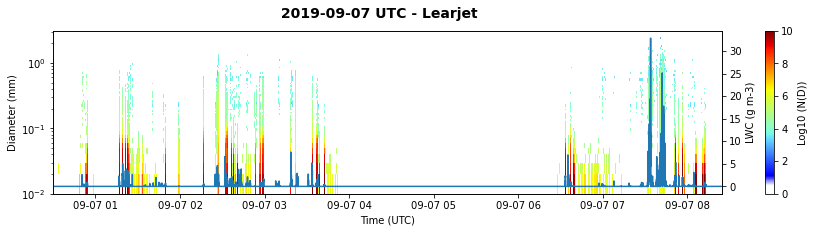

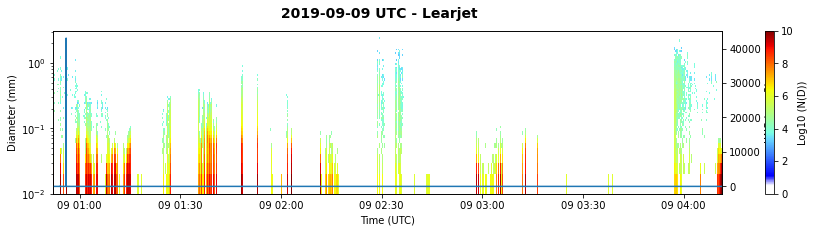

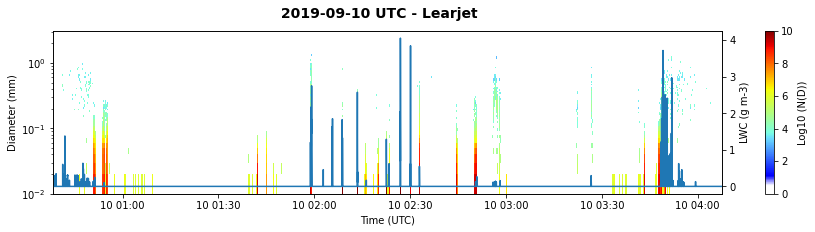

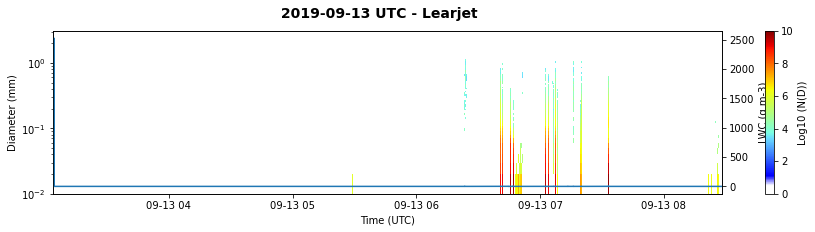

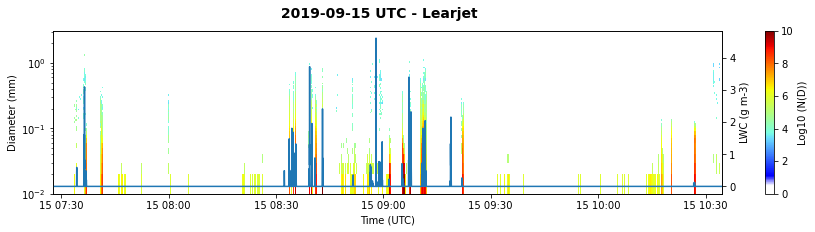

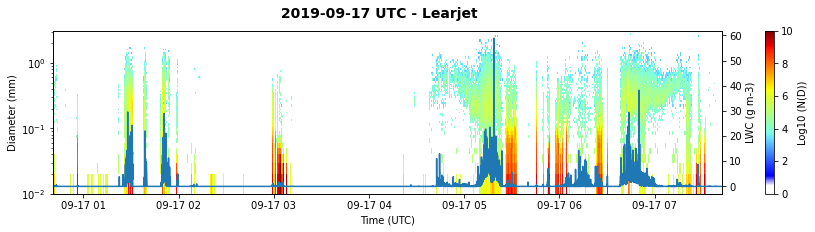

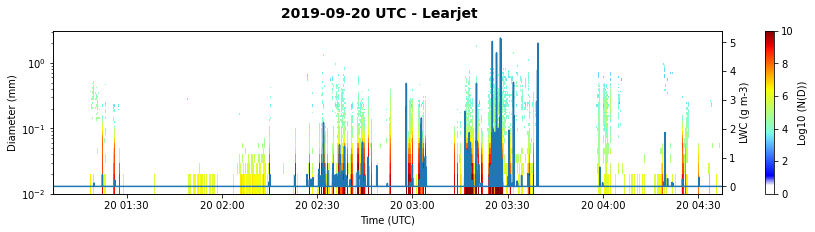

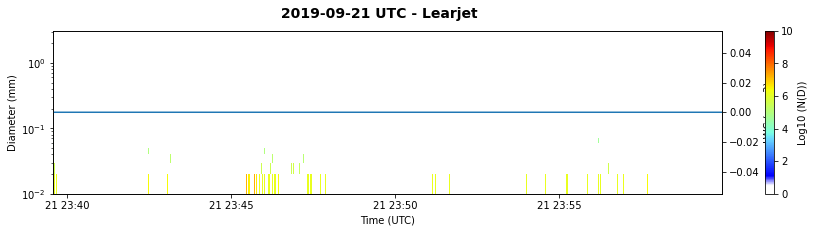

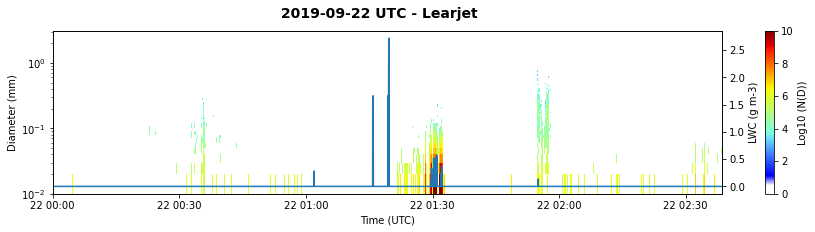

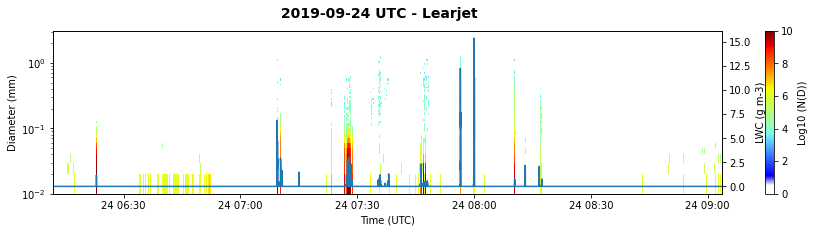

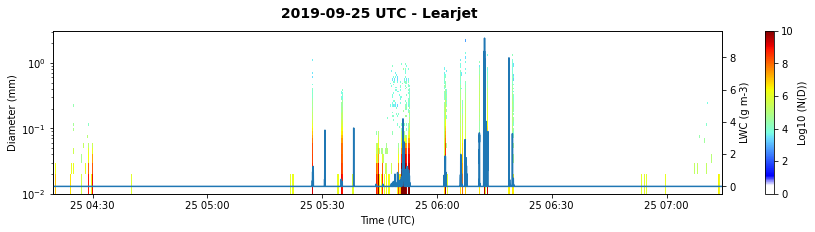

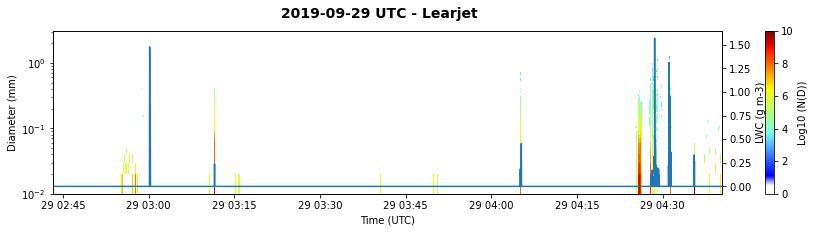

In [10]:
for _idx, data in xr_2ds.groupby('time.day'):

    fig, ax1 = plt.subplots(figsize=(12, 3))
    cbar = ax1.pcolormesh(data.time.values, data.diameter / 1e3, 
                   np.log10(data.psd.T.values * 1e6), 
                      vmin=0, vmax=10, cmap=my_cmap)
    ax1.set_yscale('log')
    params = pds_parameters(data)
    lwc = params.lwc.where(params.lwc >0.1, 0)
    ax11 = ax1.twinx()
    ax11.plot(lwc.time, lwc.sum('diameter'))
    add_colorbar_outside(cbar, ax1, 'Log10 (N(D))')
    ax1.set_xlabel('Time (UTC)')
    ax1.set_ylabel('Diameter (mm)')
    ax11.set_ylabel('LWC (g m-3)')
    title = f"{pd.to_datetime(data.time.values[0]): %Y-%m-%d} UTC - {data.attrs['aircraft']}"
    fig.suptitle(title, fontsize=14, fontweight='bold', y=0.99)

In [11]:
event = xr_2ds.sel(time=slice('2019-09-07 07:31:30', '2019-09-07 07:34:30'))
parms_res = pds_parameters(event)

(0.01, 10)

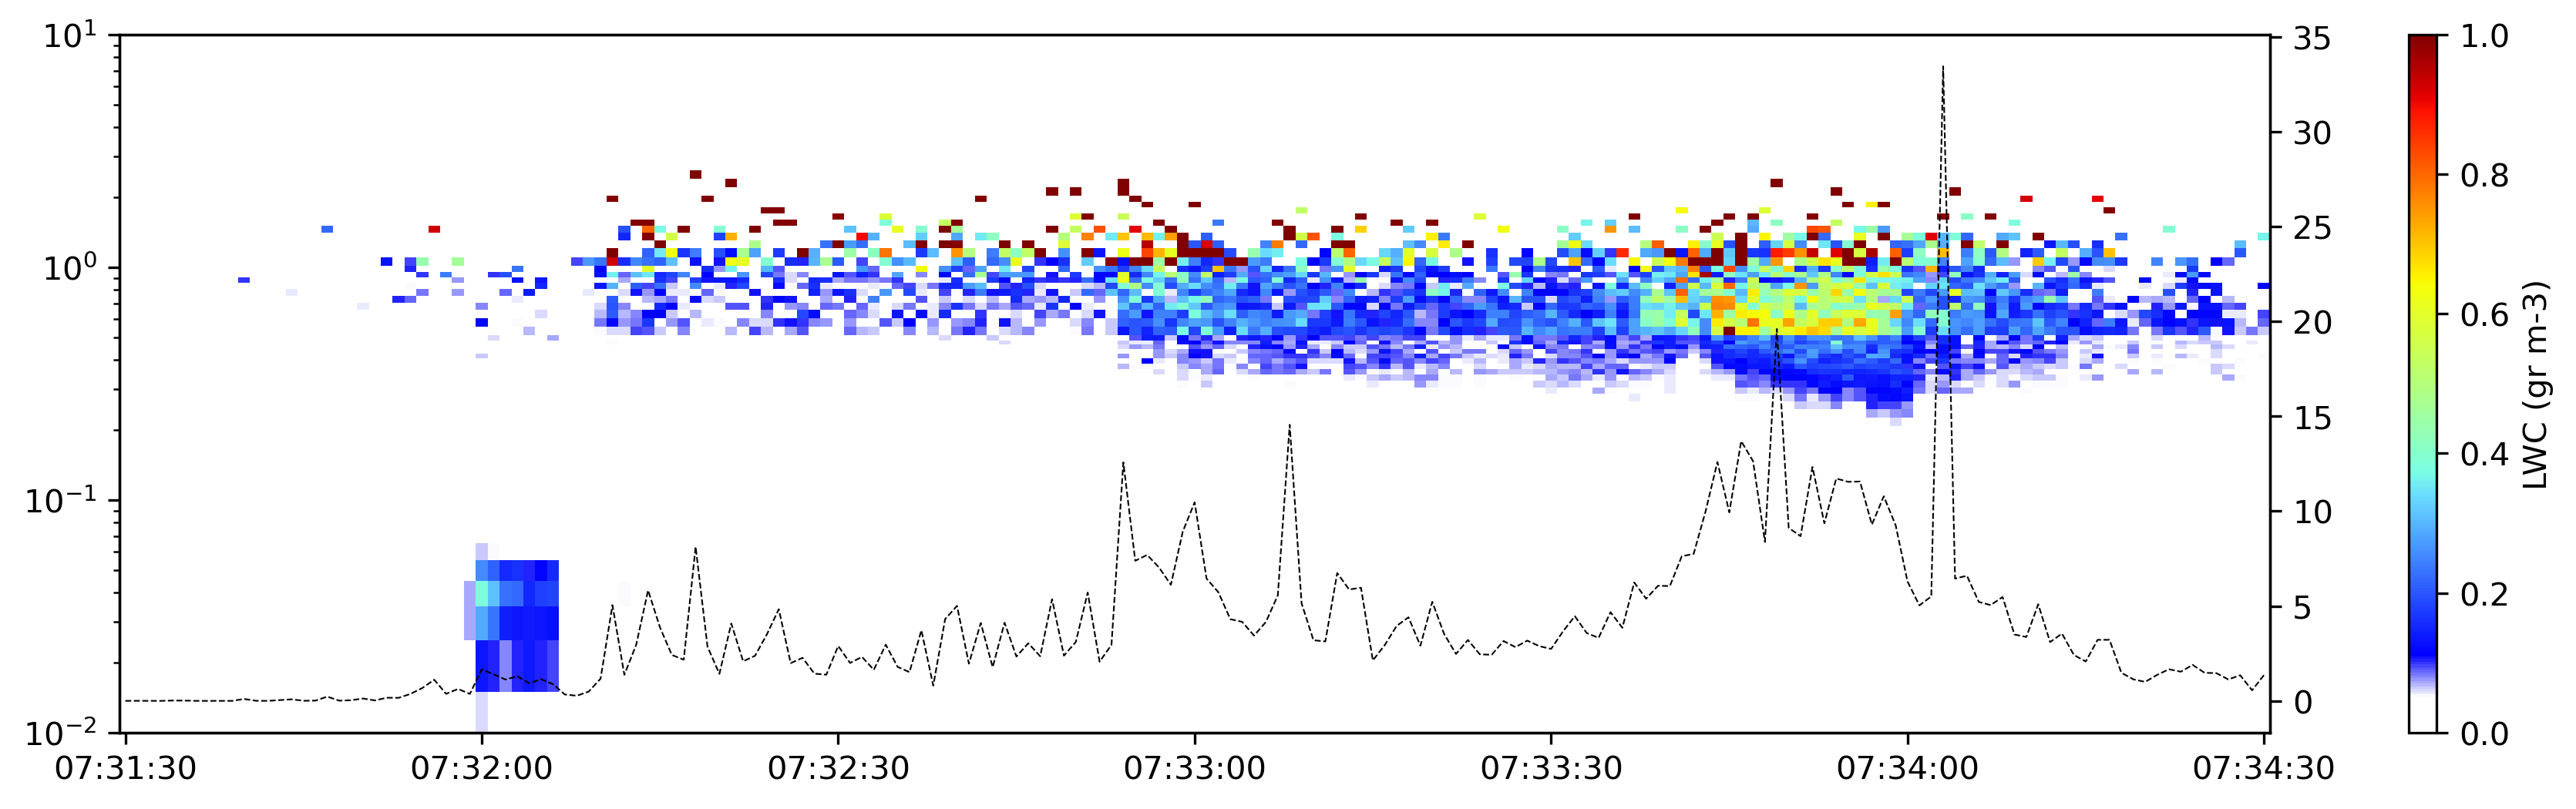

In [12]:
fig, ax = plt.subplots( figsize=(12,4), dpi=300, sharex=True)
cbar1 = ax.pcolormesh(parms_res.time, 
                       parms_res.diameter / 1e3, 
                       parms_res.lwc.T.values, 
                       vmin=0, vmax=1, cmap=my_cmap, shading='nearest')
ax11 = ax.twinx()
ax11.plot(parms_res.time, parms_res.lwc.sum('diameter'), c='k', ls='--', lw=0.5)

add_colorbar_outside(cbar1, ax, 'LWC (gr m-3)')
ax.set_yscale('log')
ax.set_ylim(0.01, 10)

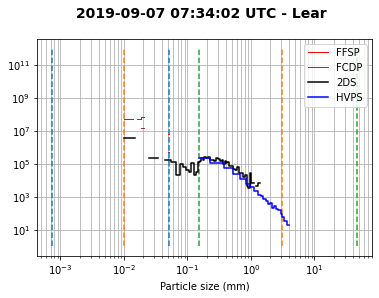

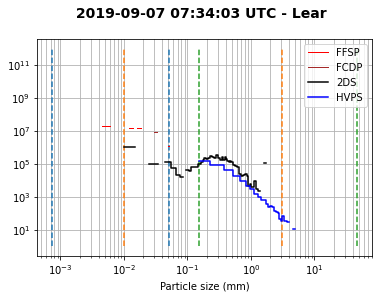

In [13]:
for i in xr_2ds.sel(time=slice('2019-09-07 07:34:02', '2019-09-07 07:34:03')).time:
    fig, ax1 = plt.subplots()
    
    y = xr_fssp.psd.sel(time=i) * 1e6
    y = y.where(y > 0, np.nan)

    ax1.step(x=xr_fssp.diameter * 1e-3, y=y, where='mid', c='r', lw=1, label= 'FFSP')
    
    y = xr_fcdp.psd.sel(time=i) * 1e6
    y = y.where(y > 0, np.nan)

    ax1.step(x=xr_fcdp.diameter * 1e-3, y=y, where='mid', c='brown', lw=1, label= 'FCDP')
    
    y = xr_2ds.psd.sel(time=i) * 1e6
    y = y.where(y > 0, np.nan)

    ax1.step(x=xr_2ds.diameter * 1e-3, y=y, where='mid', label='2DS', c='k')

    y = xr_hvps.psd.sel(time=i) * 1e6
    y = y.where(y > 0, np.nan)
    ax1.step(x=xr_hvps.diameter* 1e-3, y=y, where='mid', label='HVPS', c='b')
    
    ax1.vlines(x=xr_fssp.diameter.min() * 1e-3, ymin=1e0, ymax=1e12, colors='C0', linestyles='dashed')
    ax1.vlines(x=xr_fssp.diameter.max() * 1e-3, ymin=1e0, ymax=1e12, colors='C0', linestyles='dashed')
    
    ax1.vlines(x=xr_2ds.diameter.min() * 1e-3, ymin=1e0, ymax=1e12, colors='C1', linestyles='dashed')
    ax1.vlines(x=xr_2ds.diameter.max() * 1e-3, ymin=1e0, ymax=1e12, colors='C1', linestyles='dashed')
    
    ax1.vlines(x=xr_hvps.diameter.min() * 1e-3, ymin=1e0, ymax=1e12, colors='C2', linestyles='dashed')
    ax1.vlines(x=xr_hvps.diameter.max() * 1e-3, ymin=1e0, ymax=1e12, colors='C2', linestyles='dashed')
    
    ax1.set_yscale('log')
    ax1.set_xscale('log')
    ax1.legend()

    ax1.set_xlabel('Particle size (mm)')
    title = f"{pd.to_datetime(i.values): %Y-%m-%d %X} UTC - {aircraft}"
    fig.suptitle(title, fontsize=14, fontweight='bold', y=0.99)
#     ax1.set_ylabel('Concentration (# m-3 m-1)')
    ax1.grid(which='both')
    ax.grid(which='both')
    plt.show()

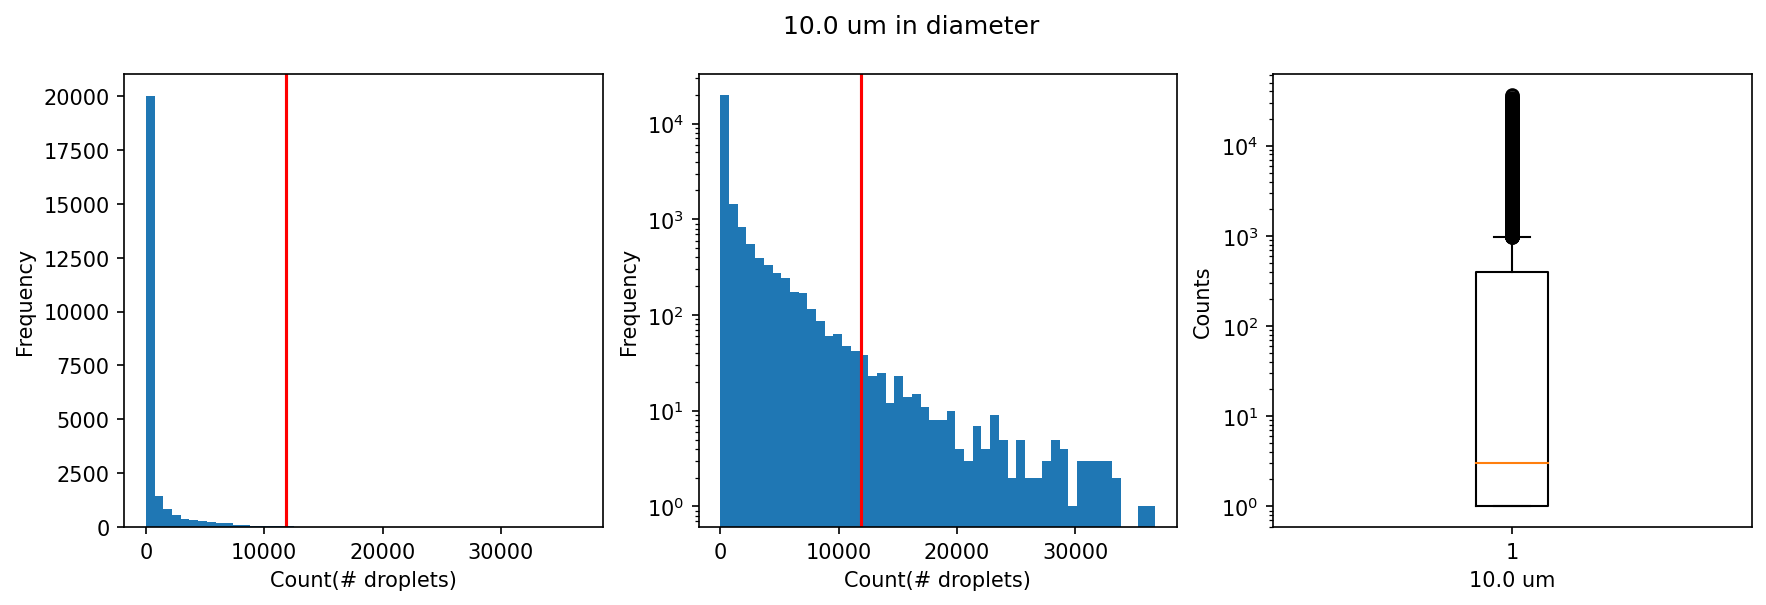

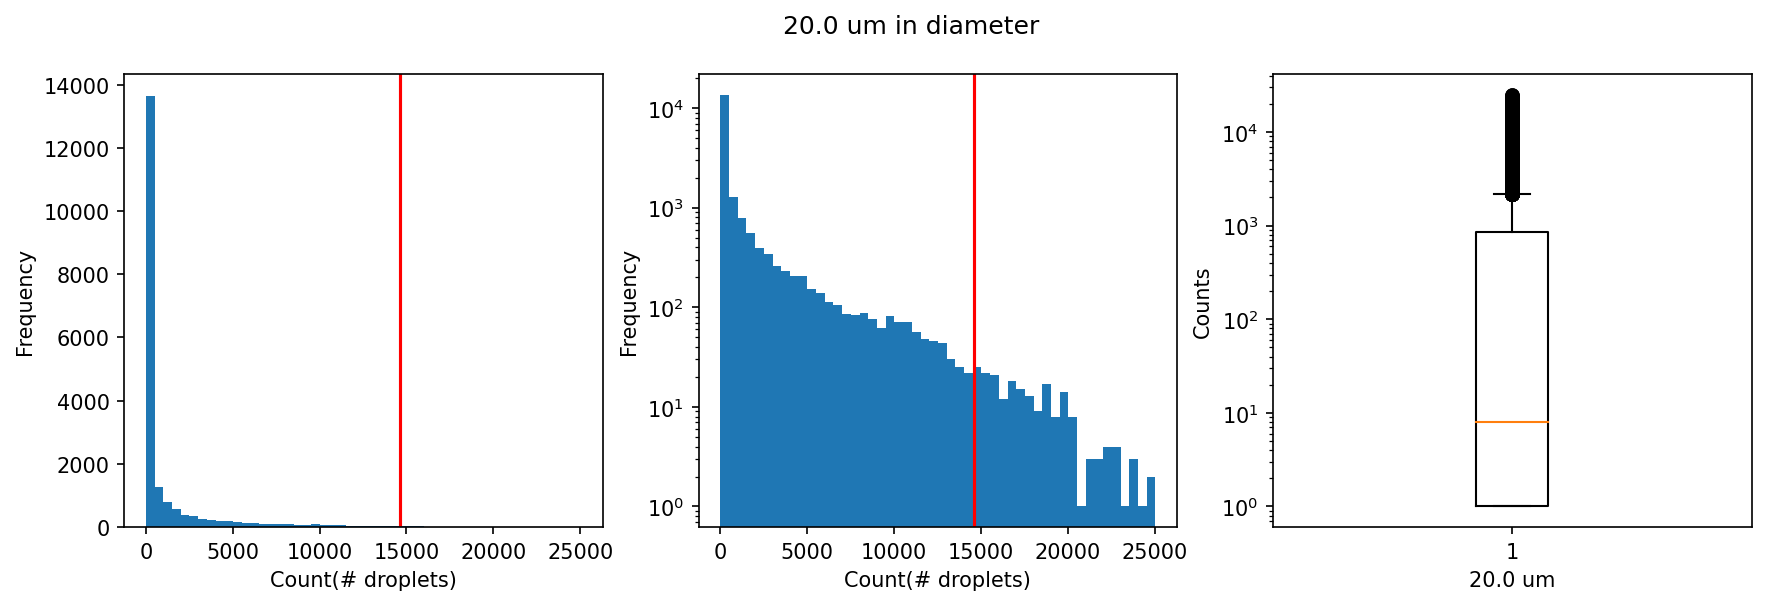

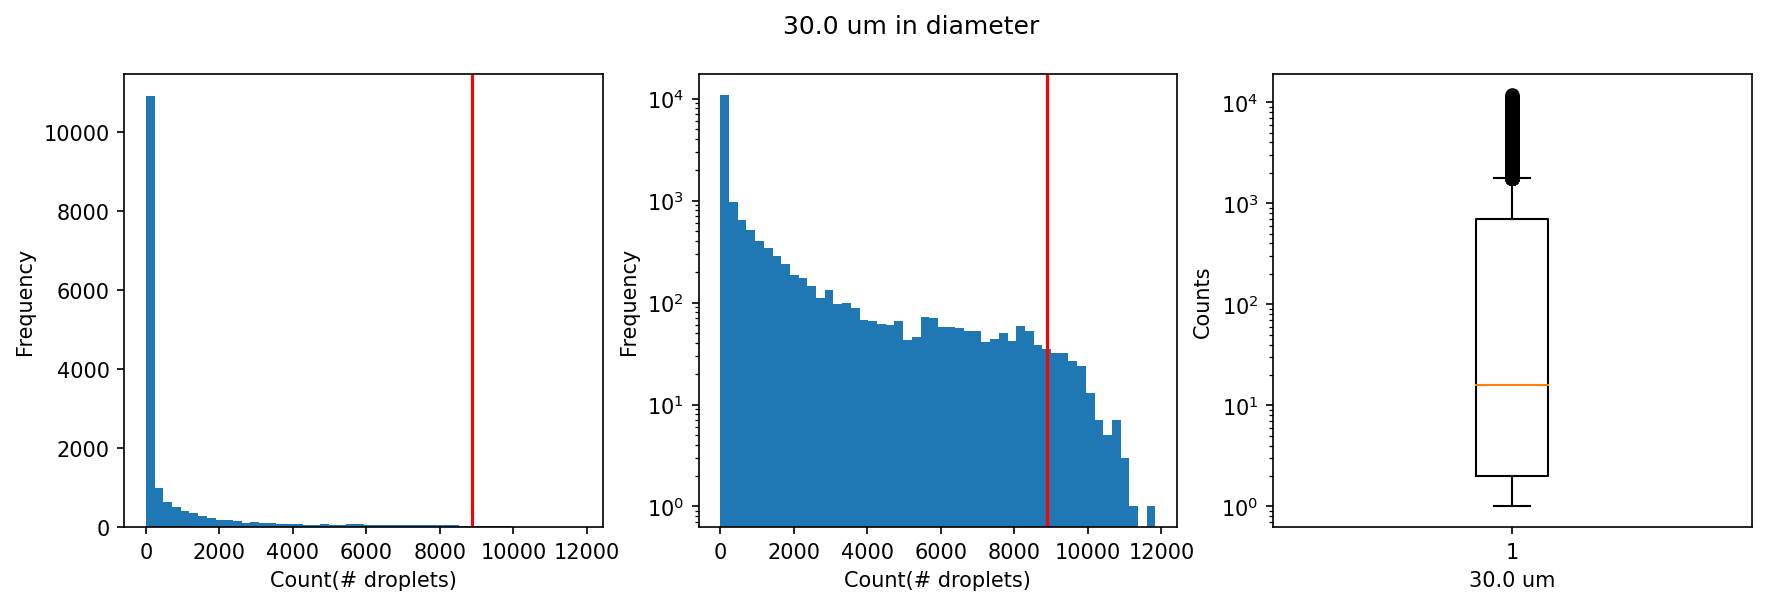

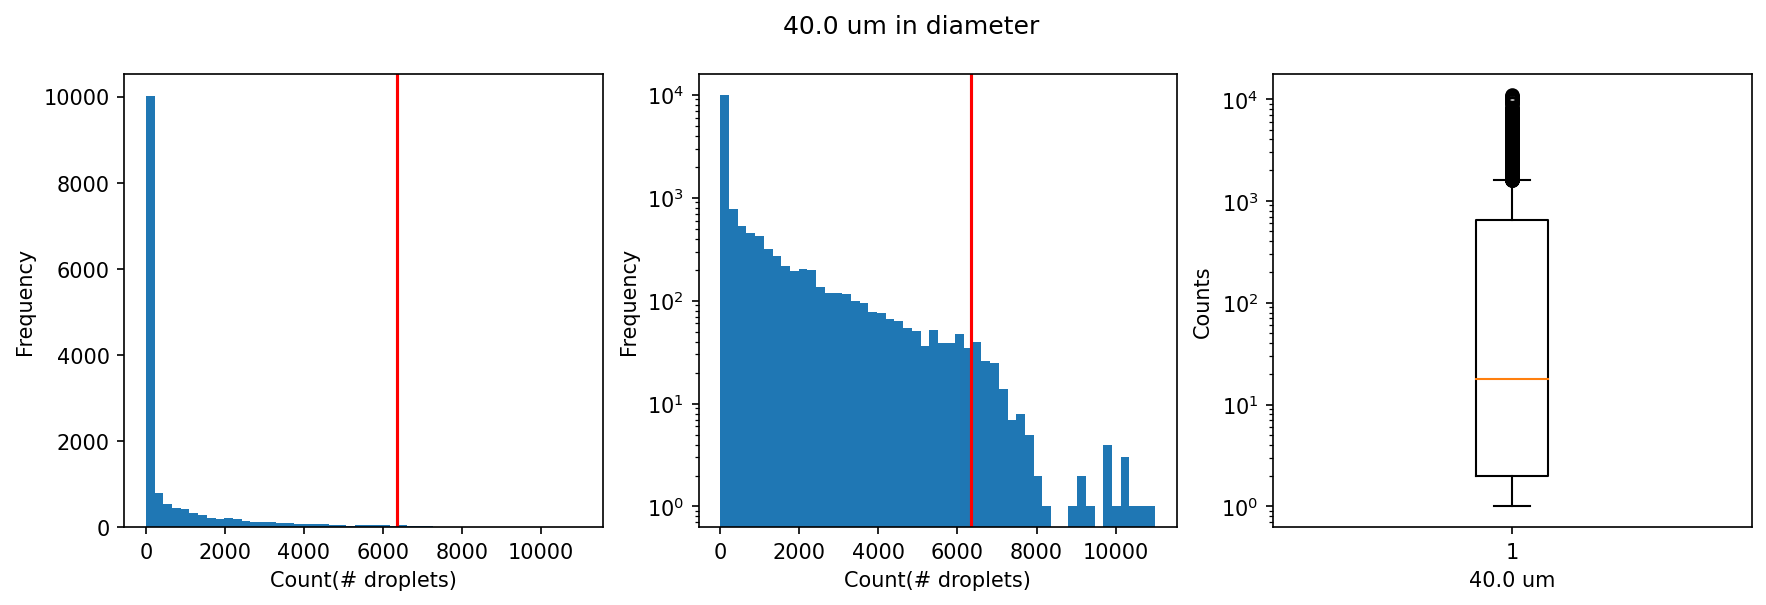

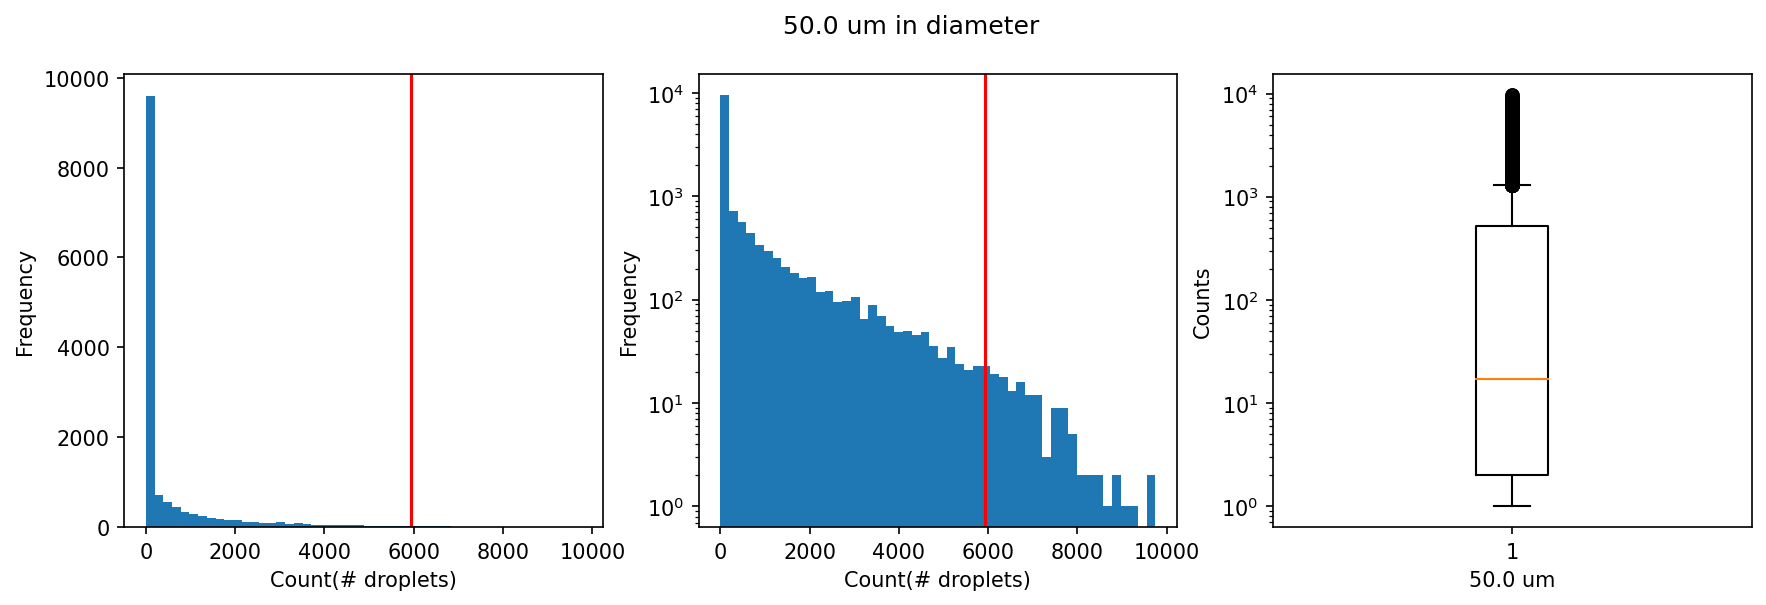

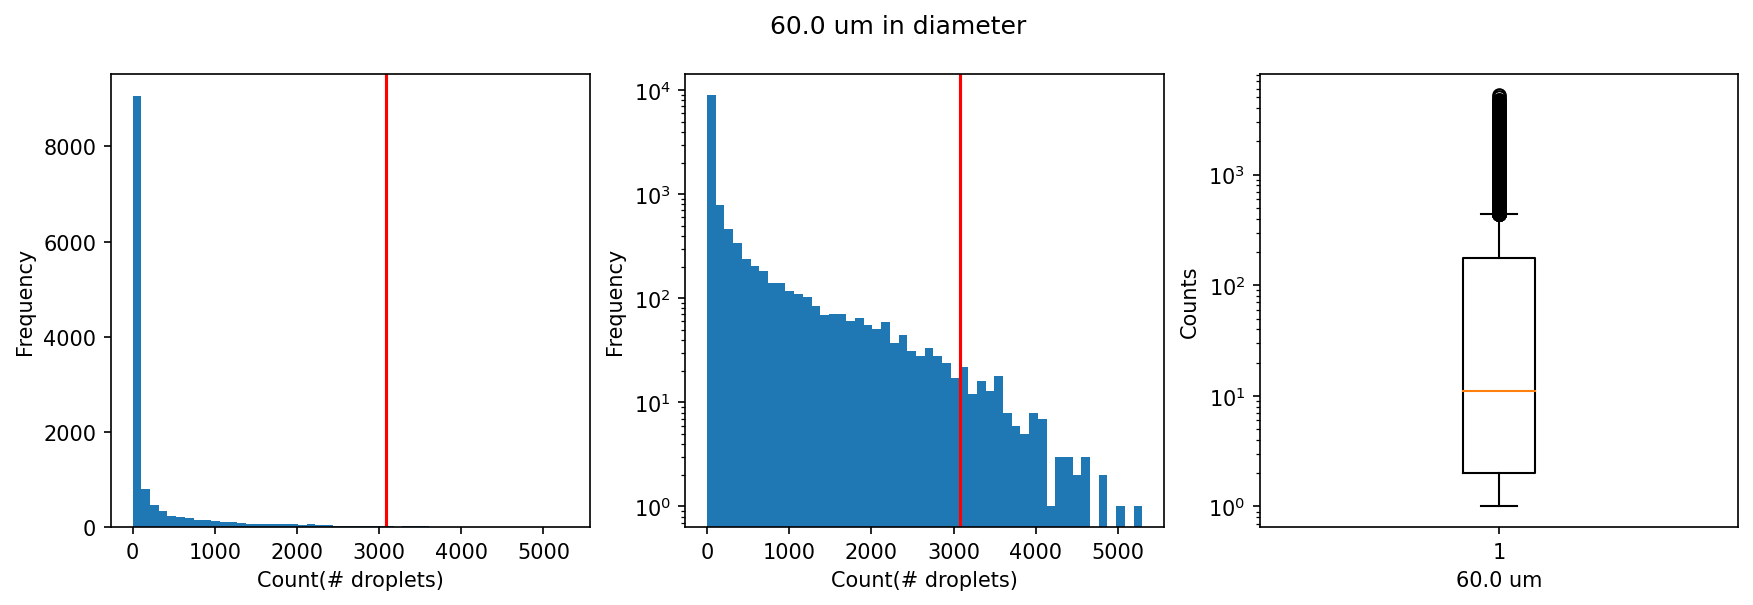

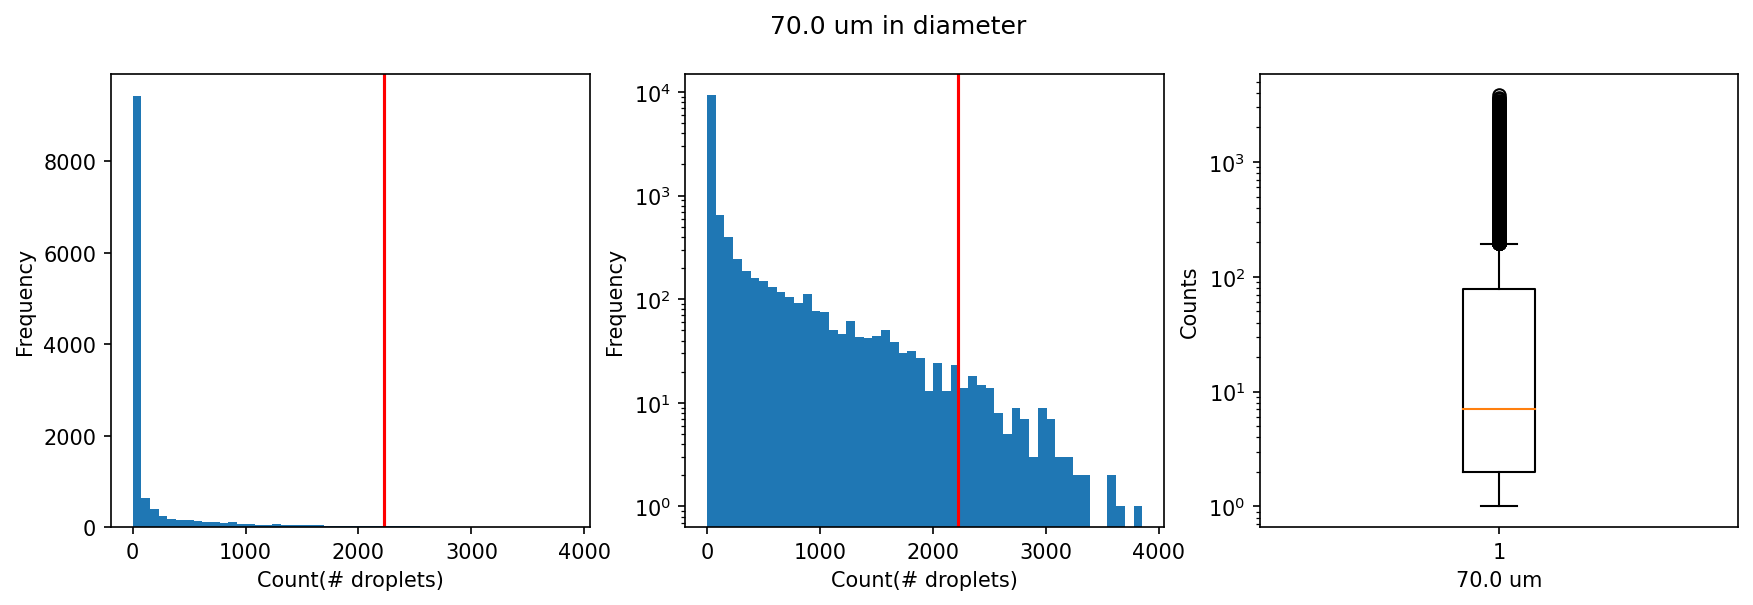

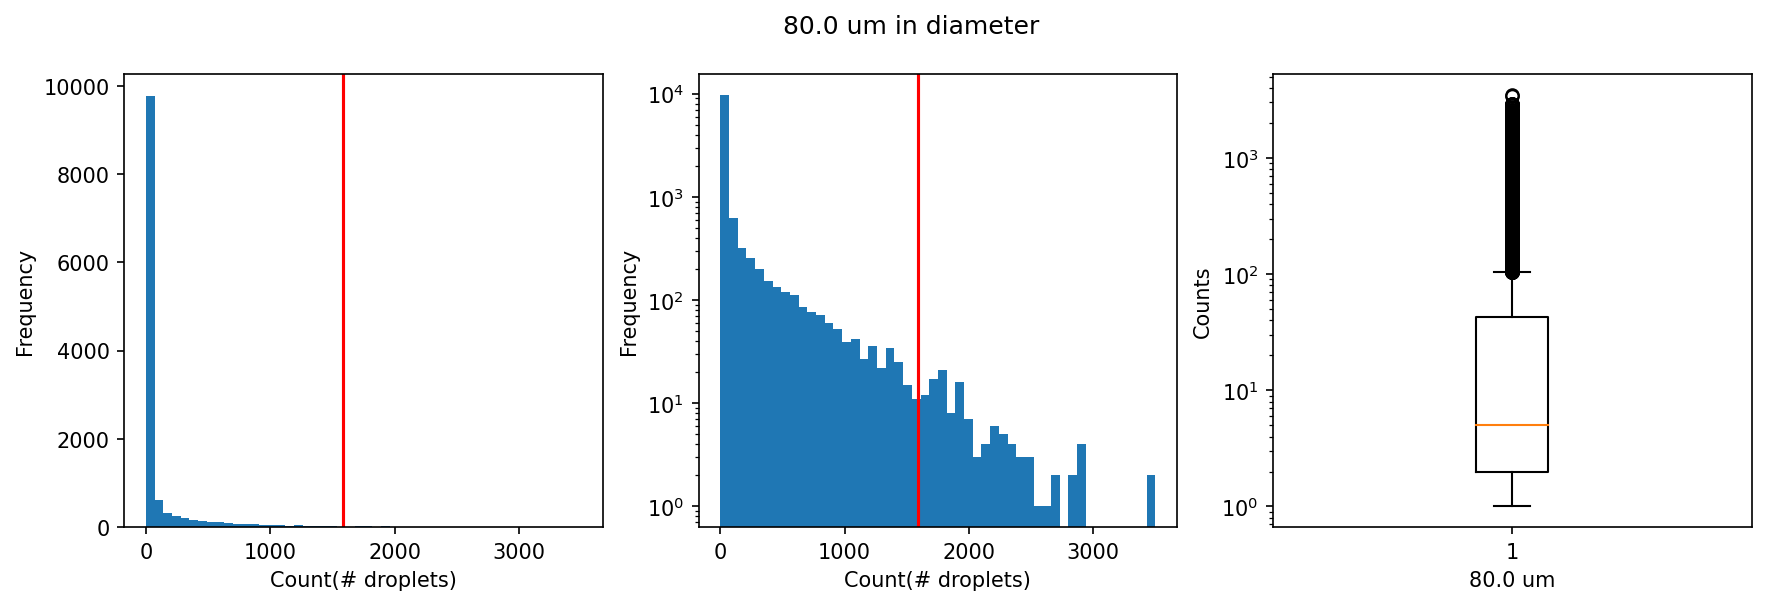

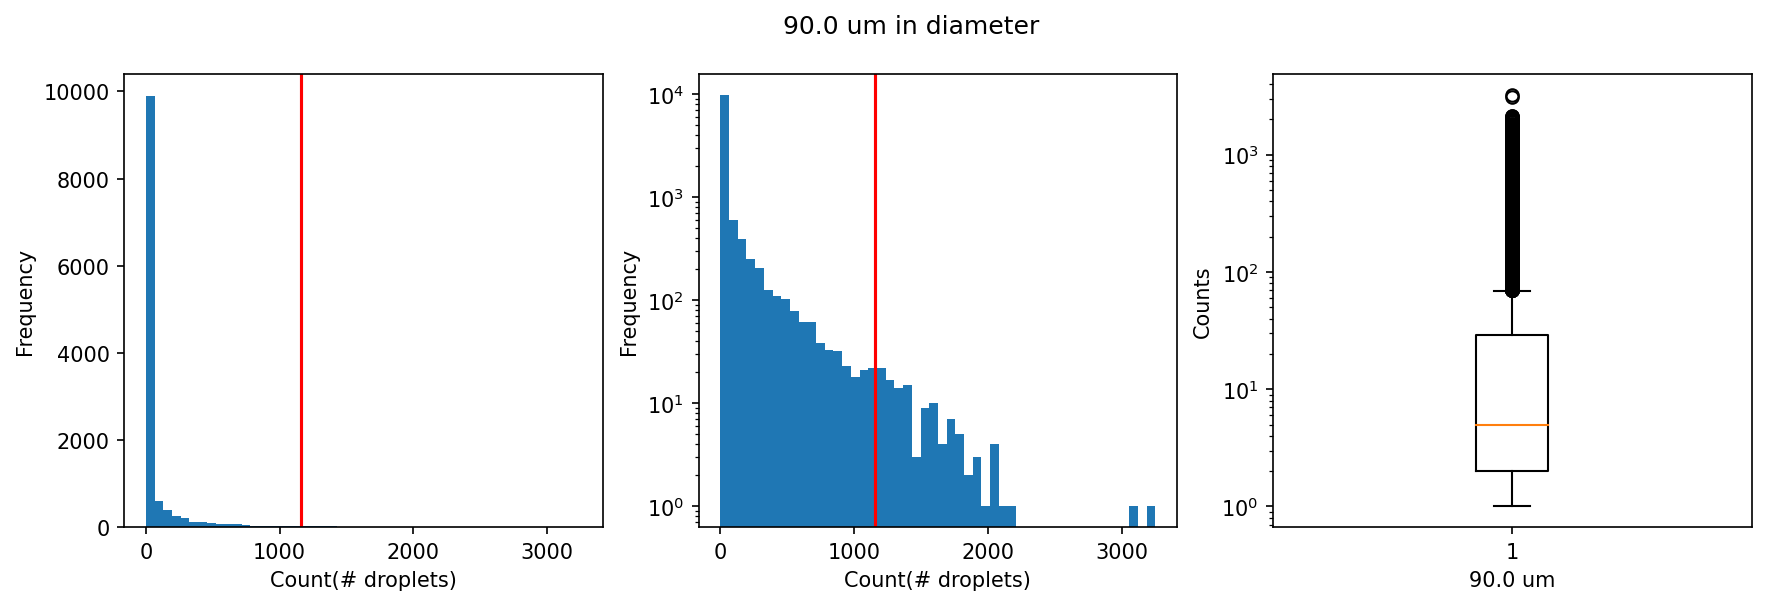

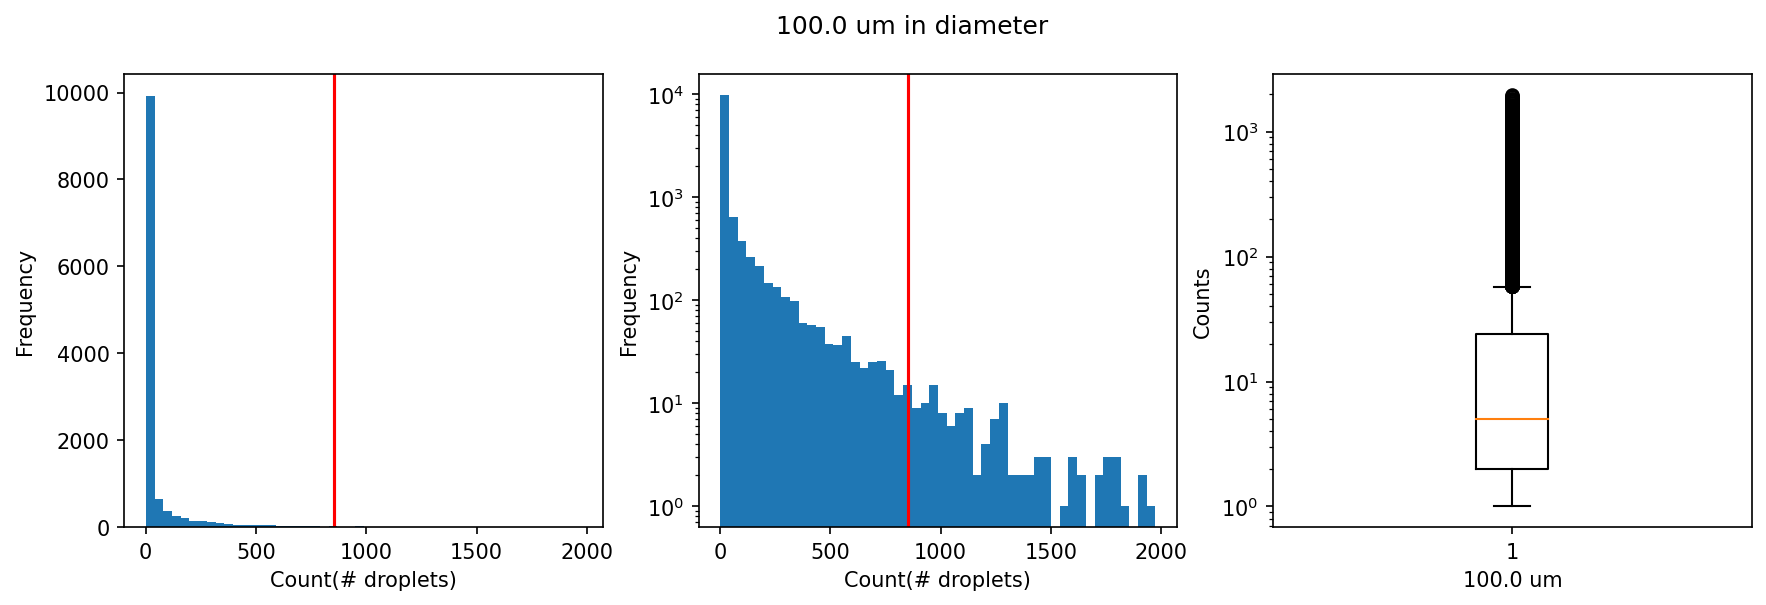

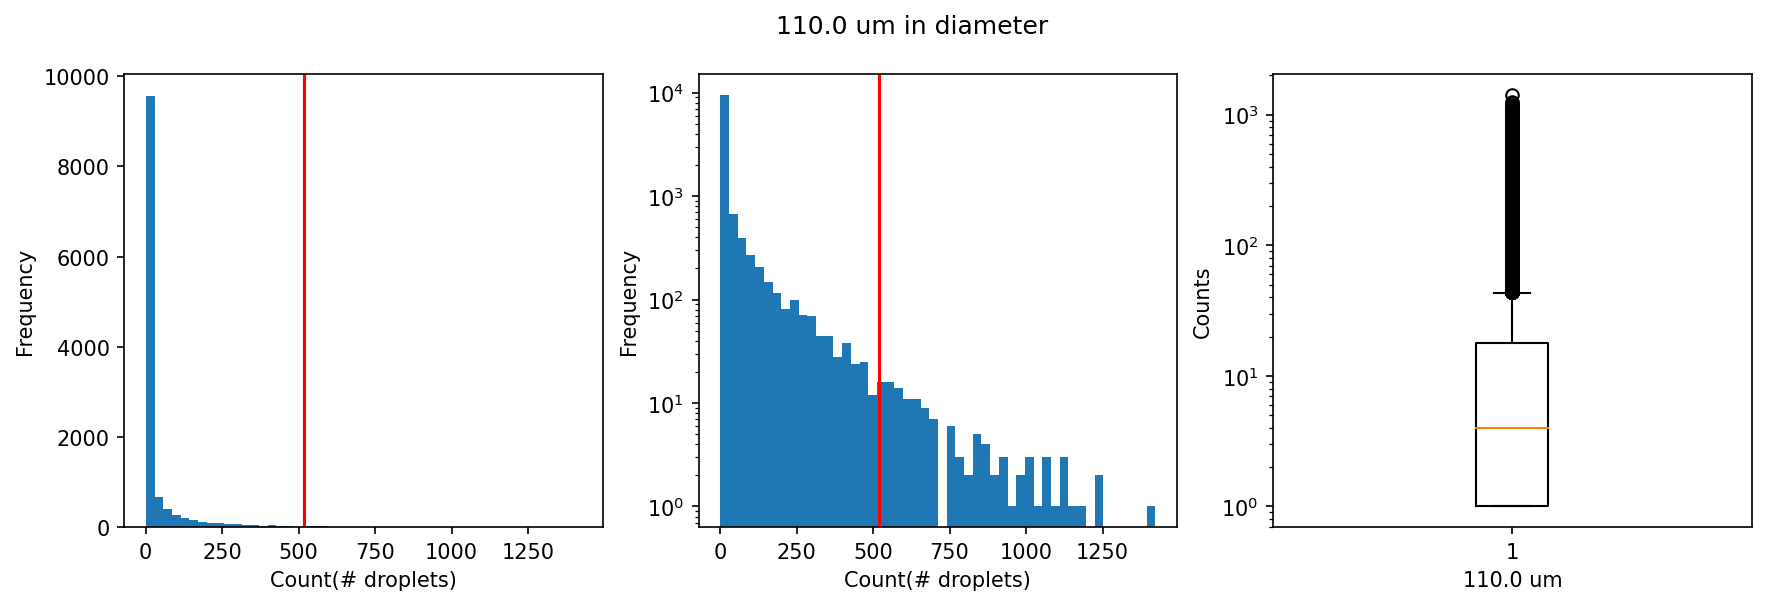

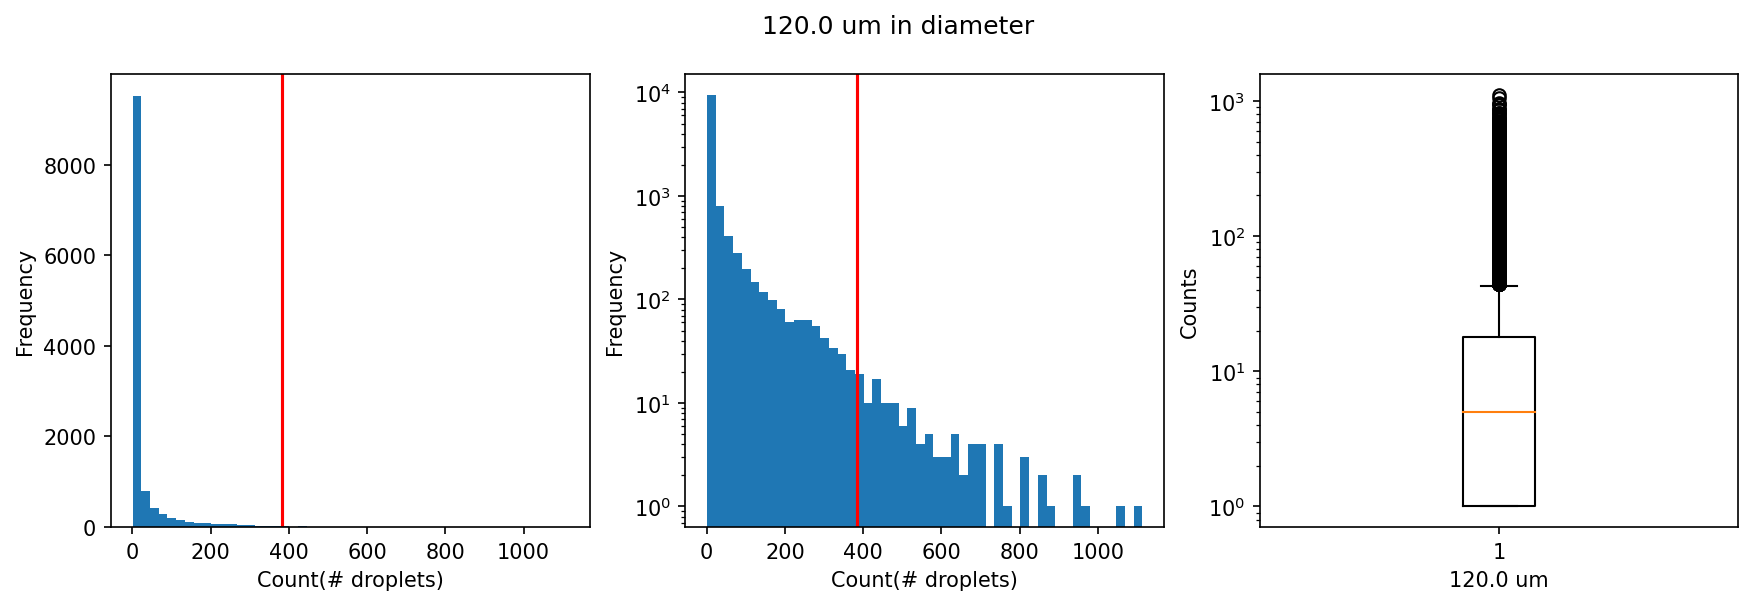

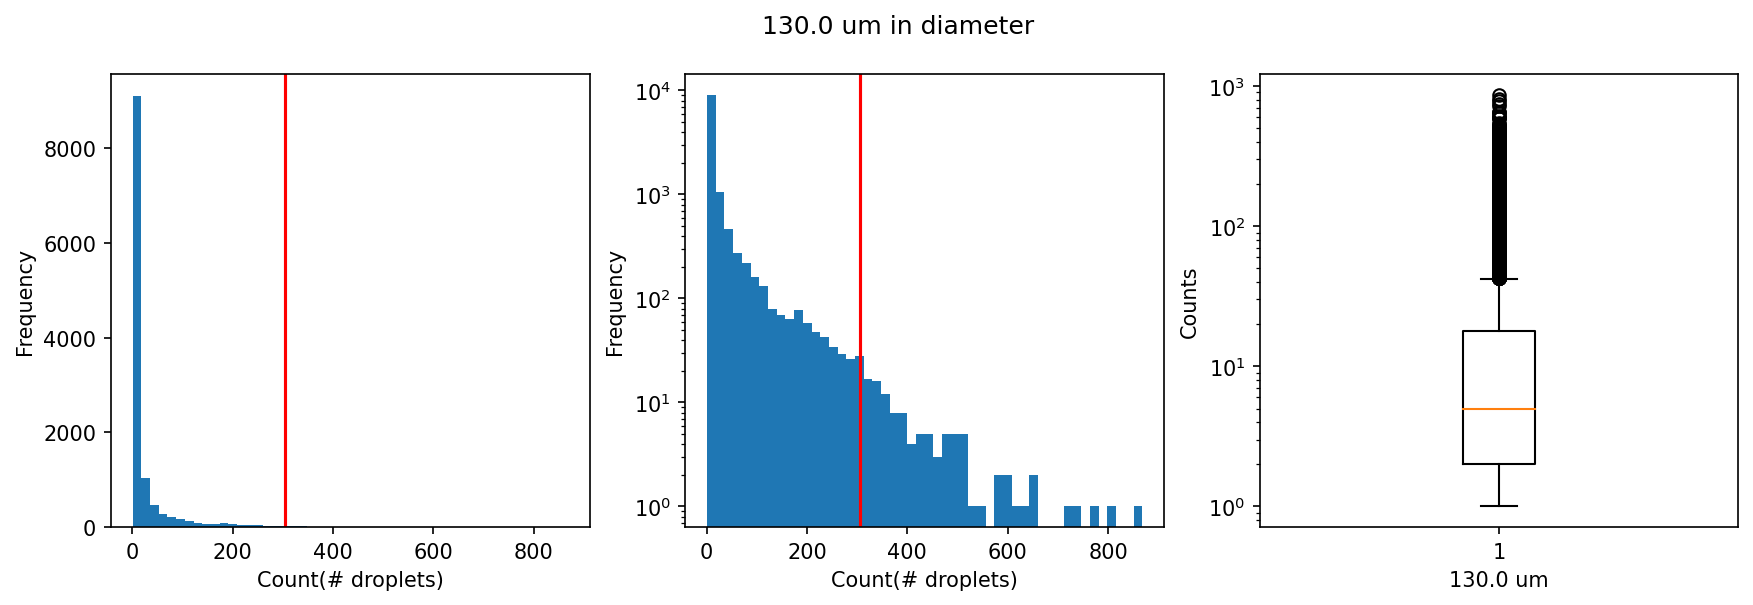

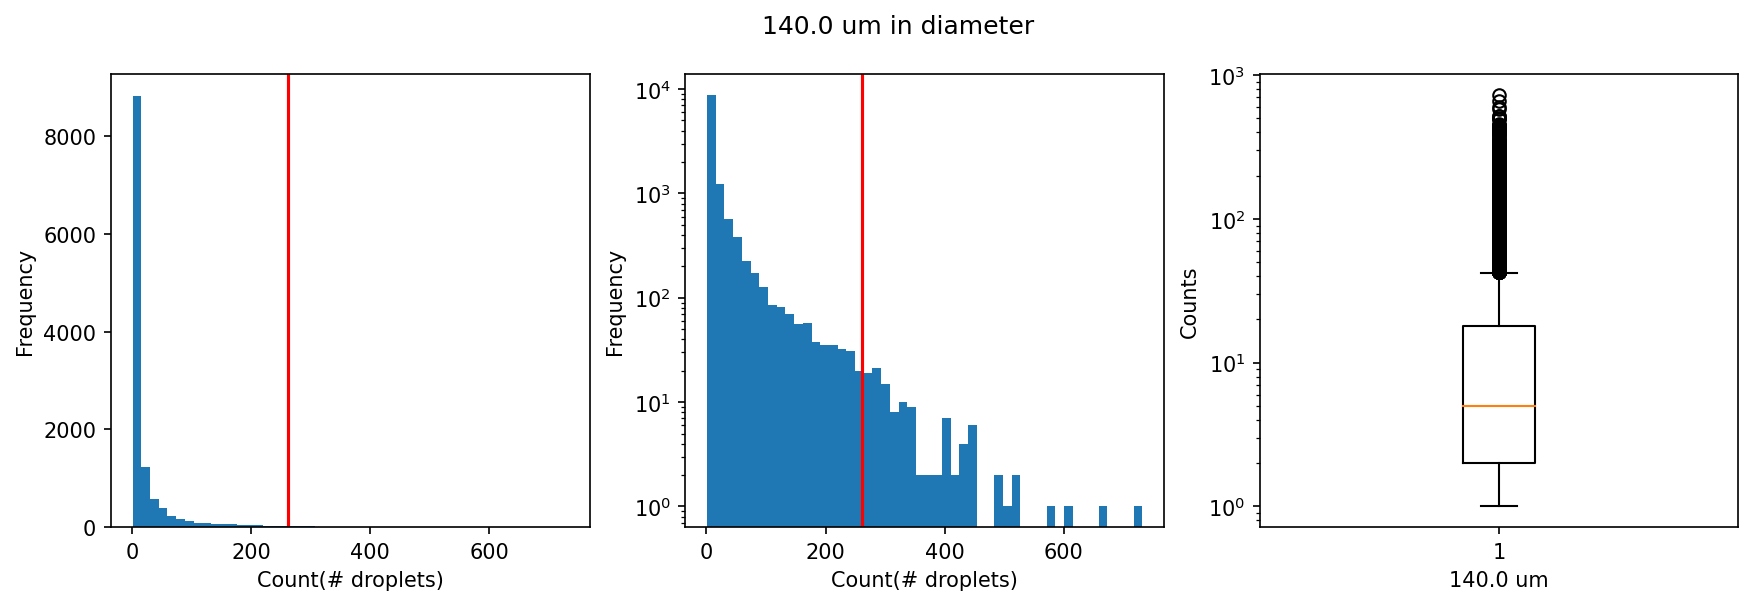

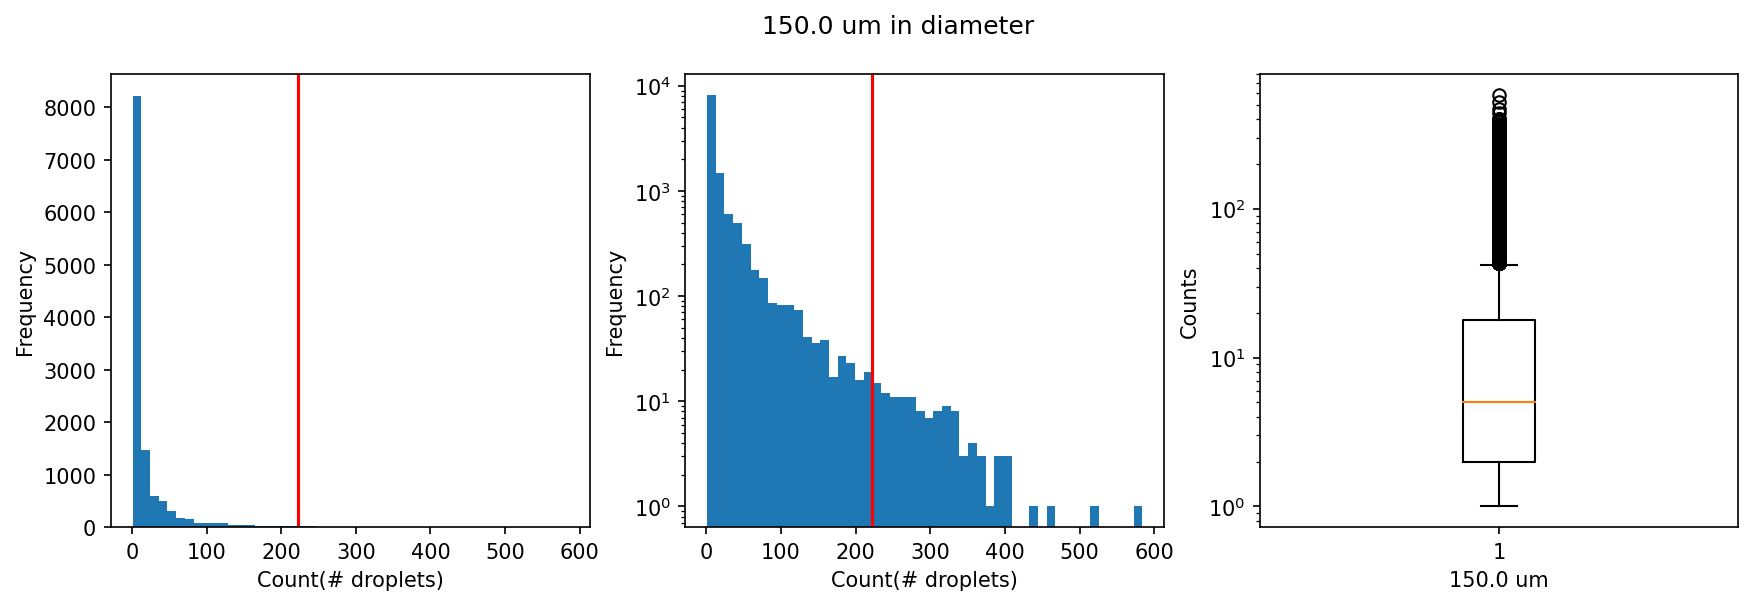

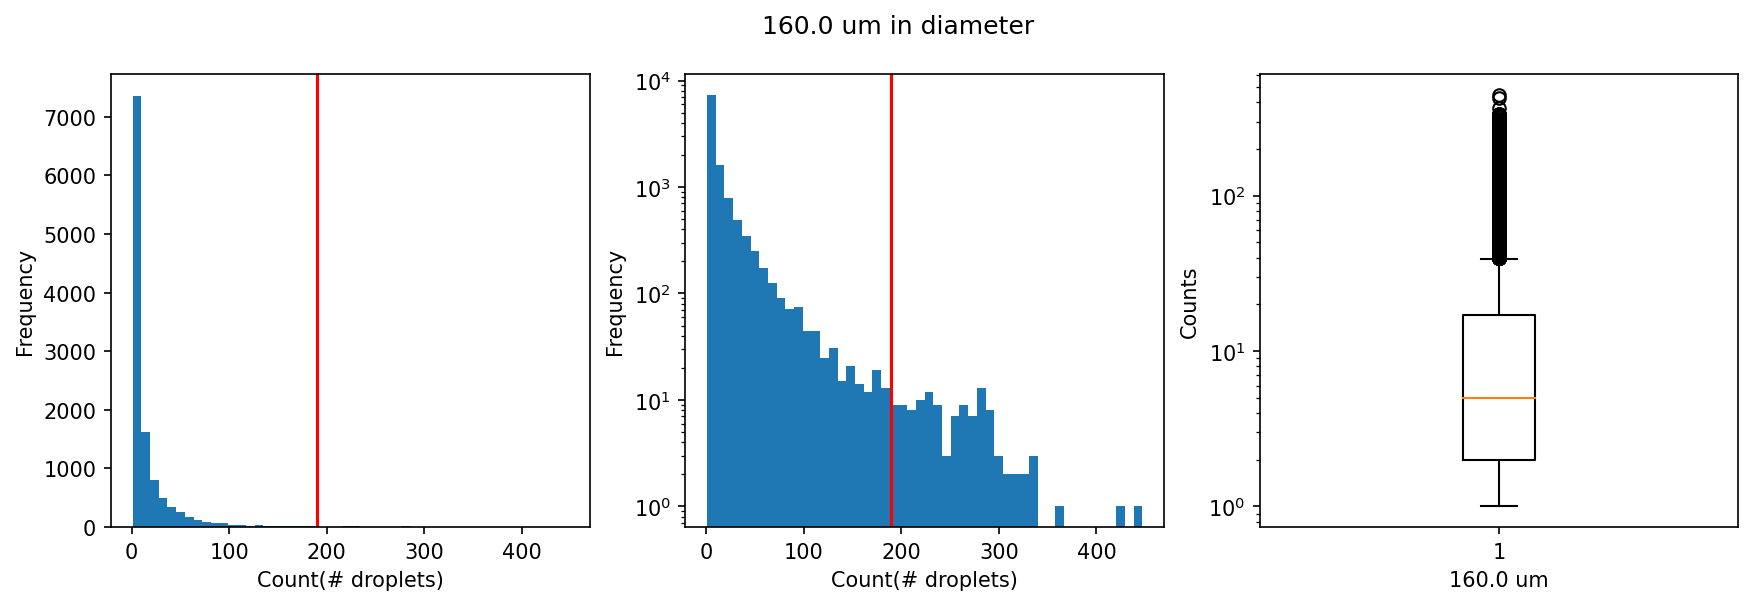

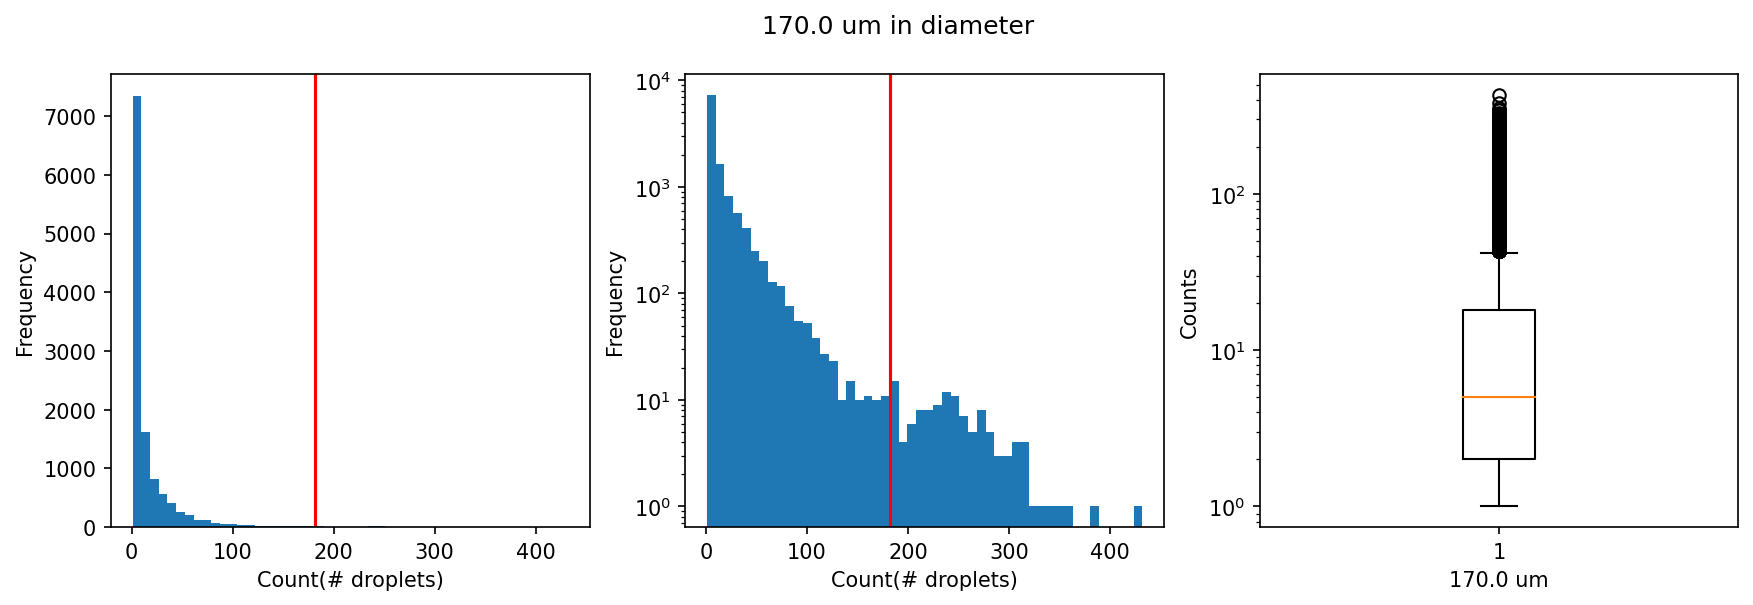

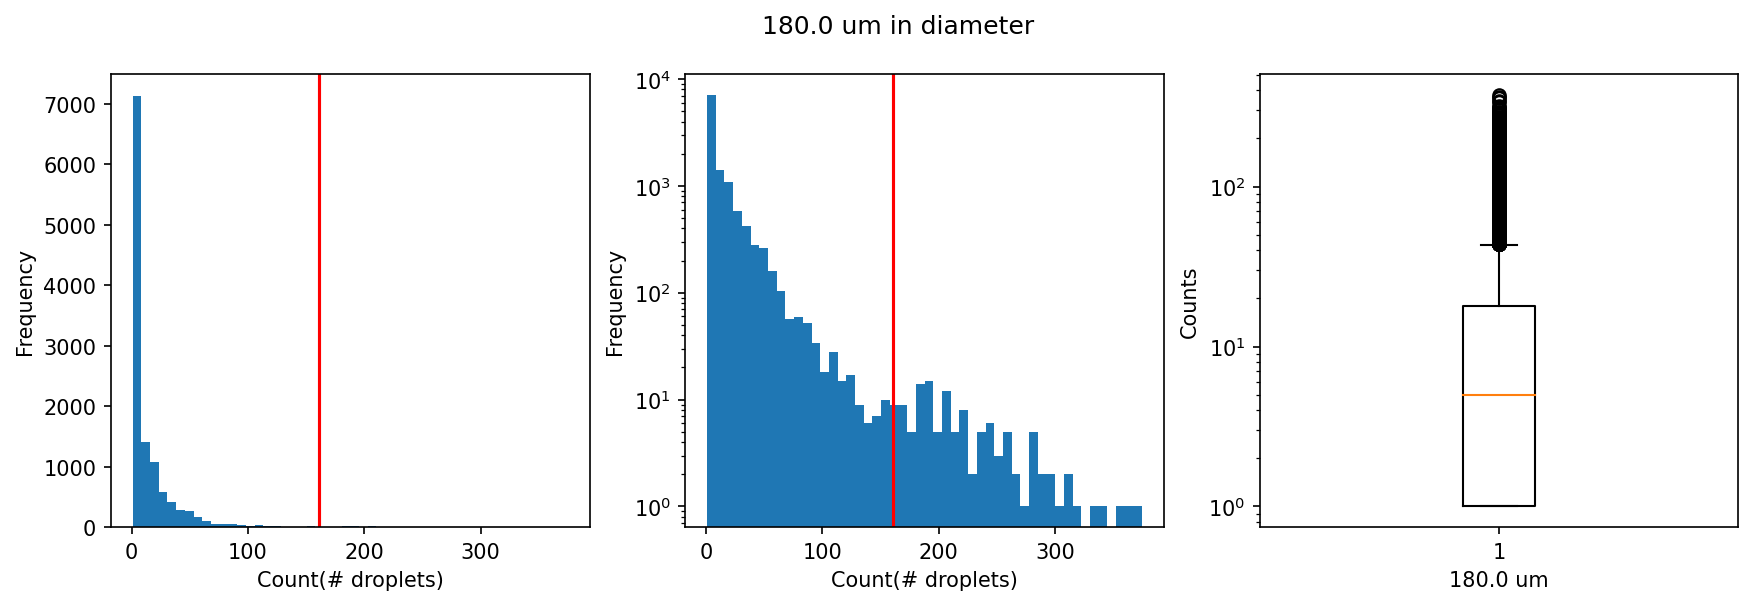

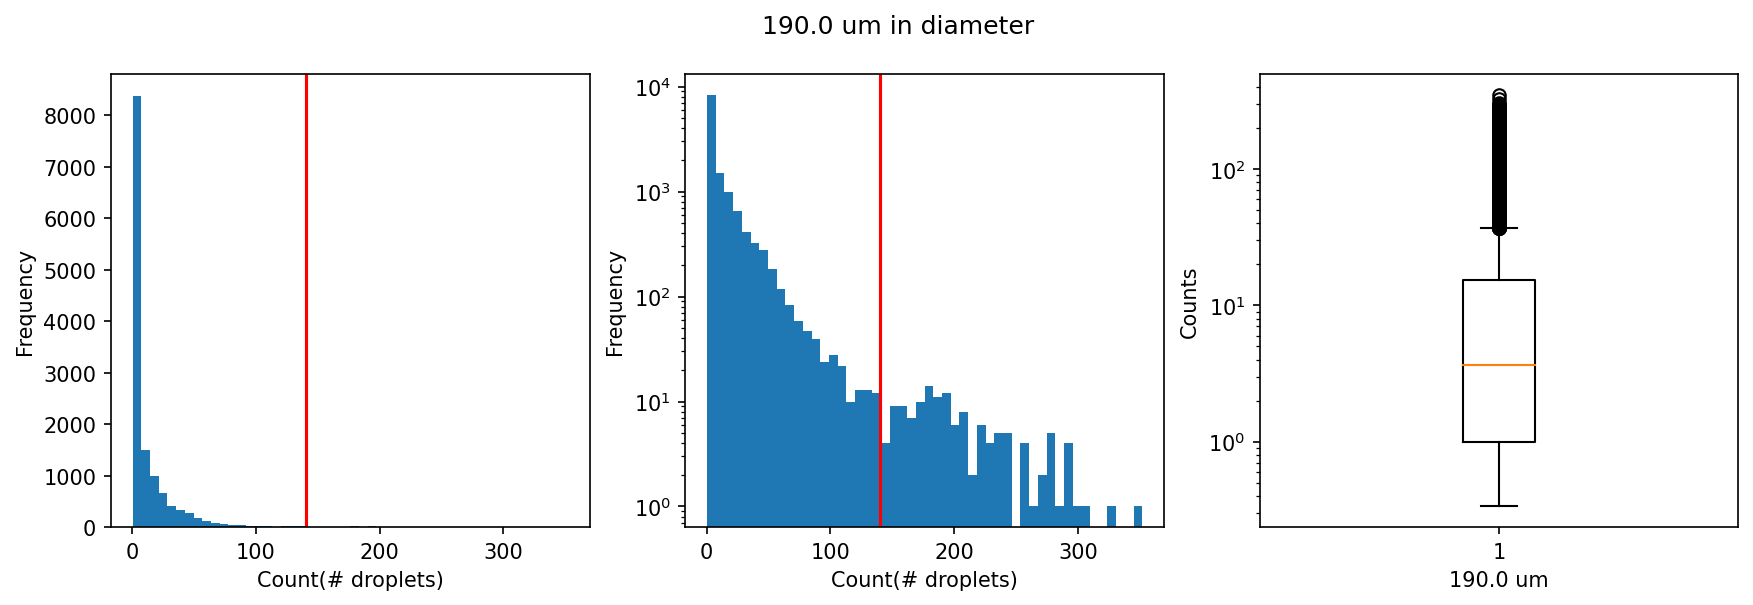

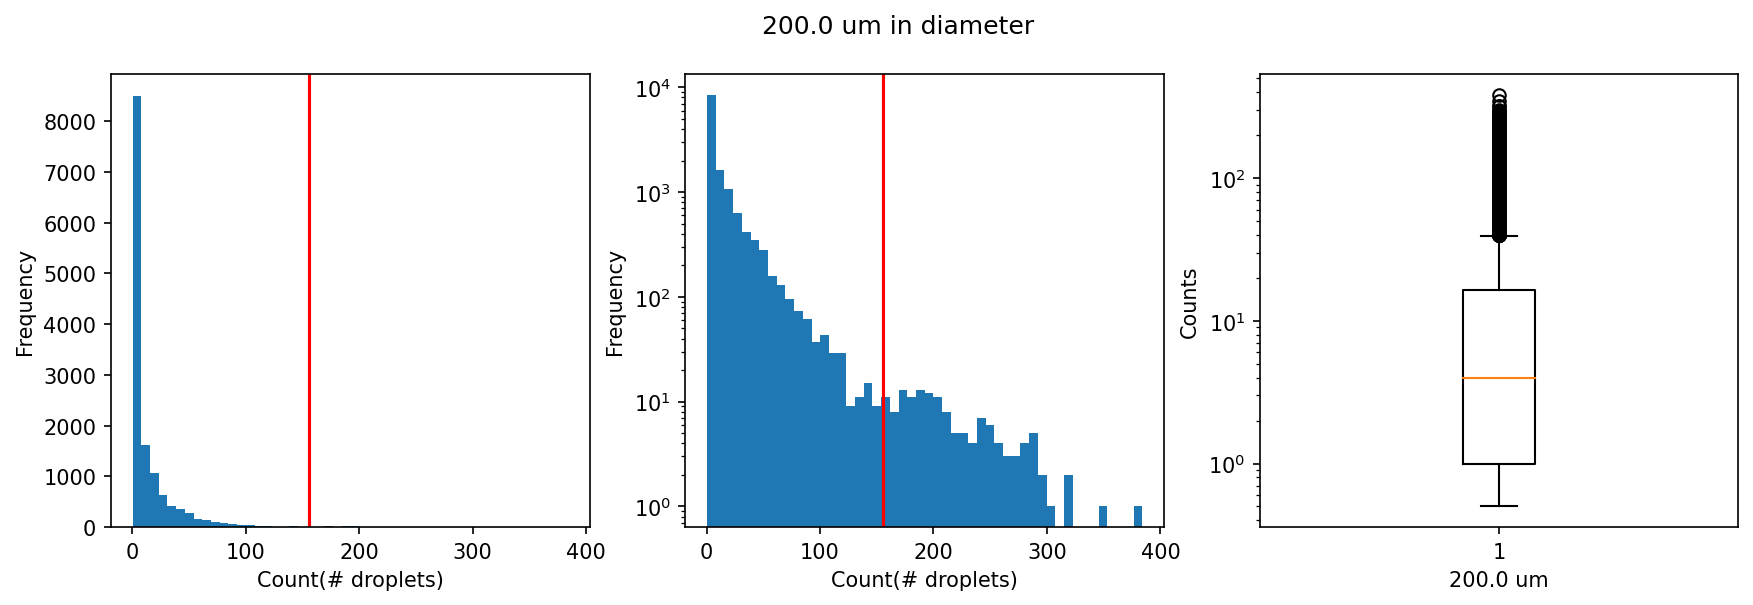

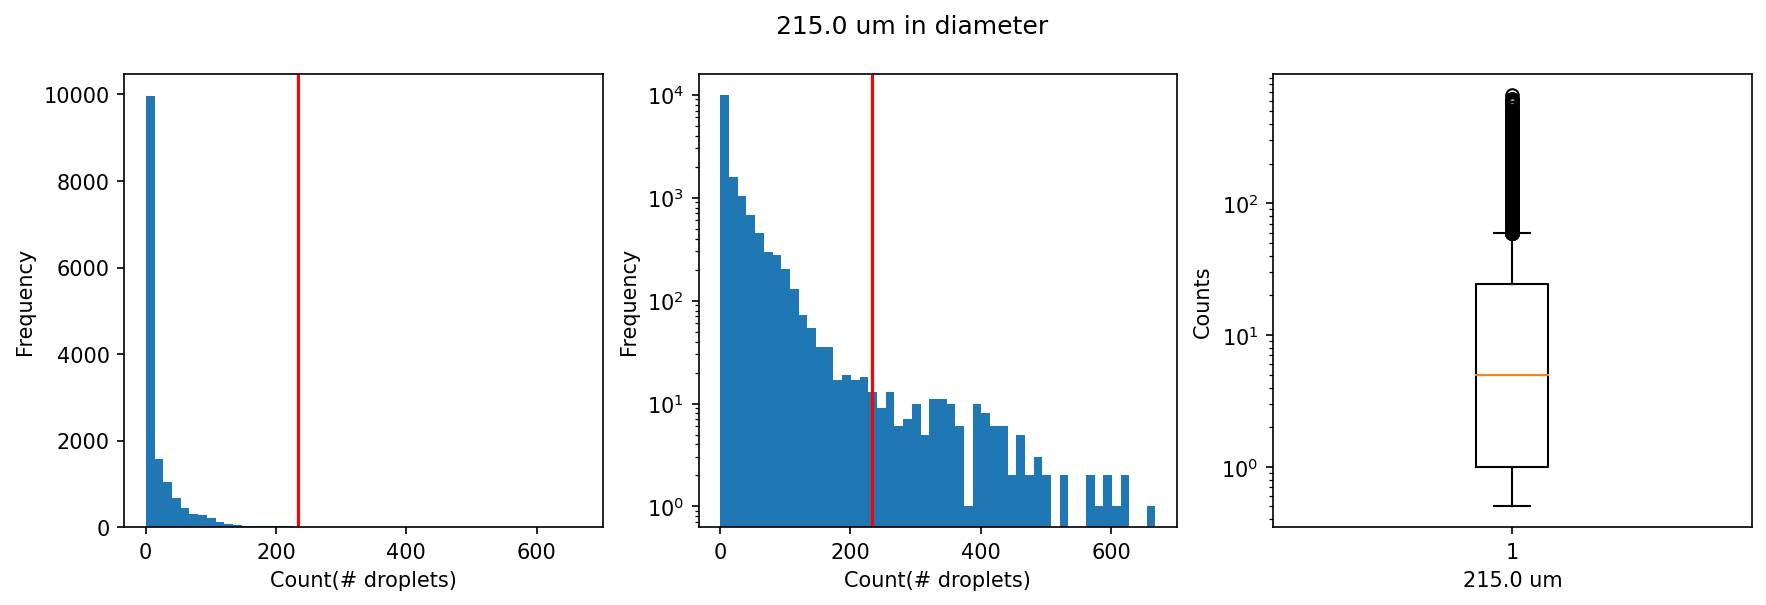

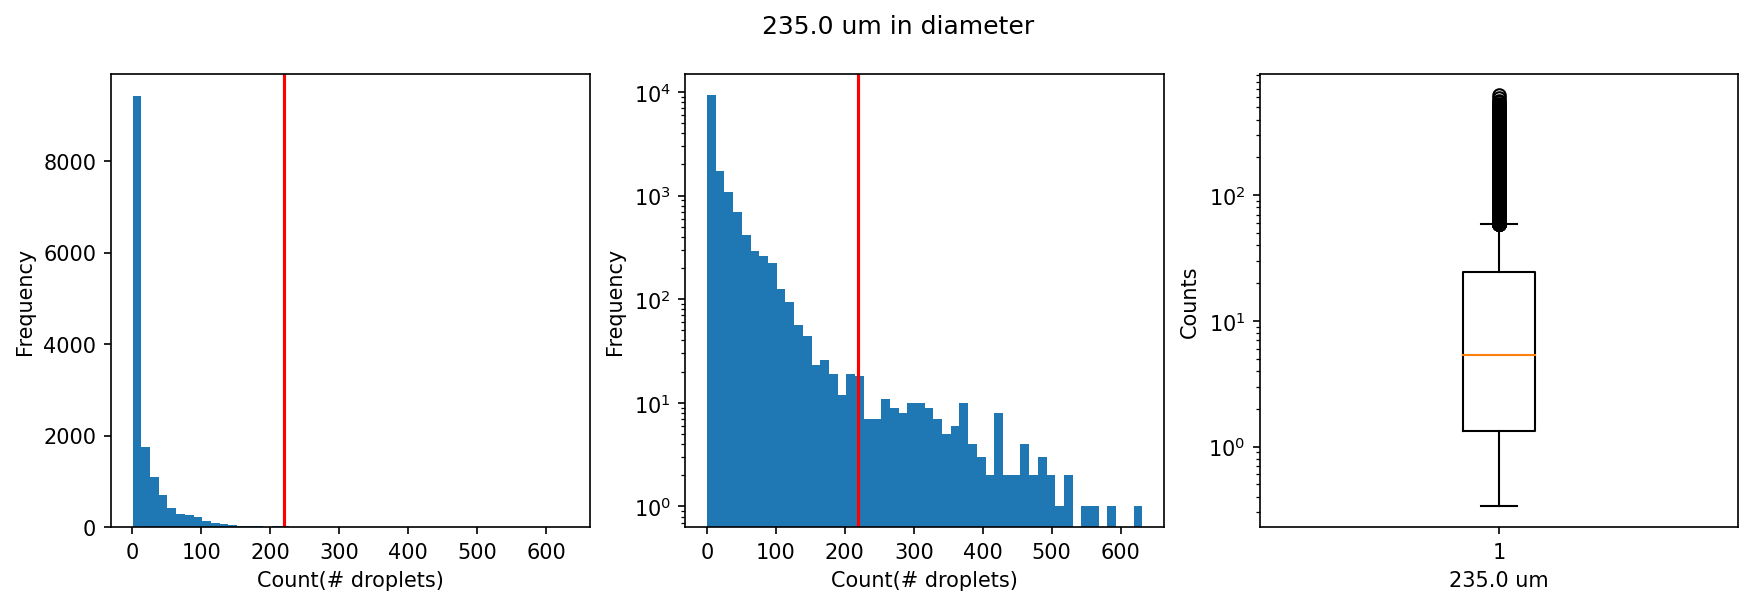

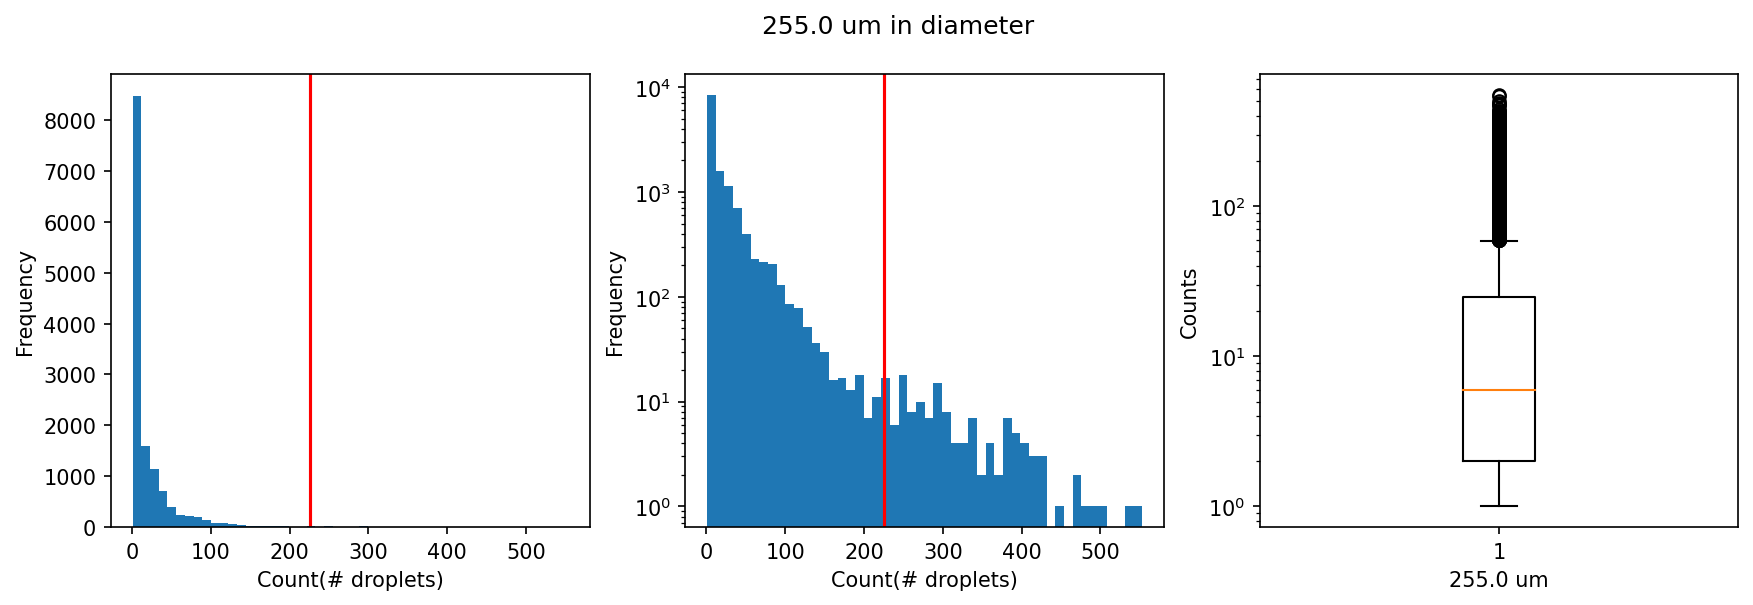

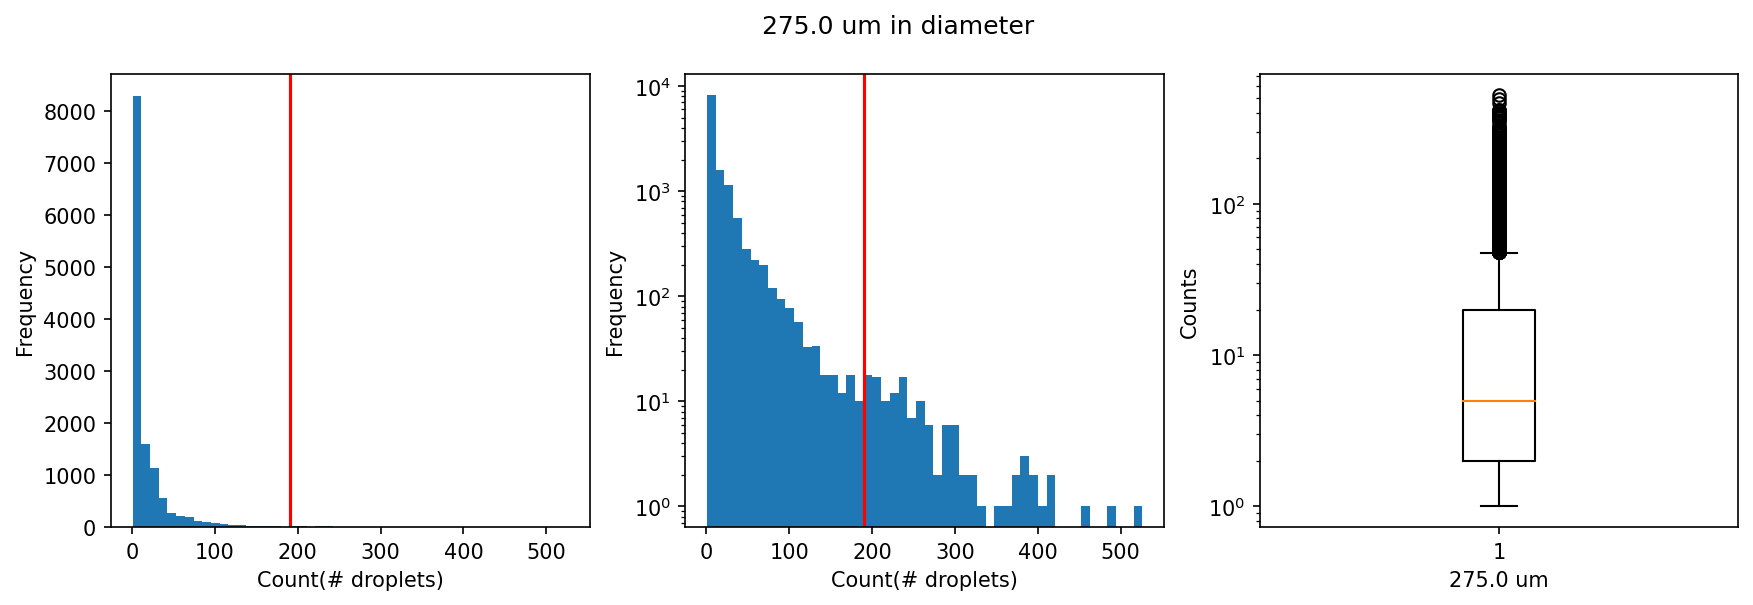

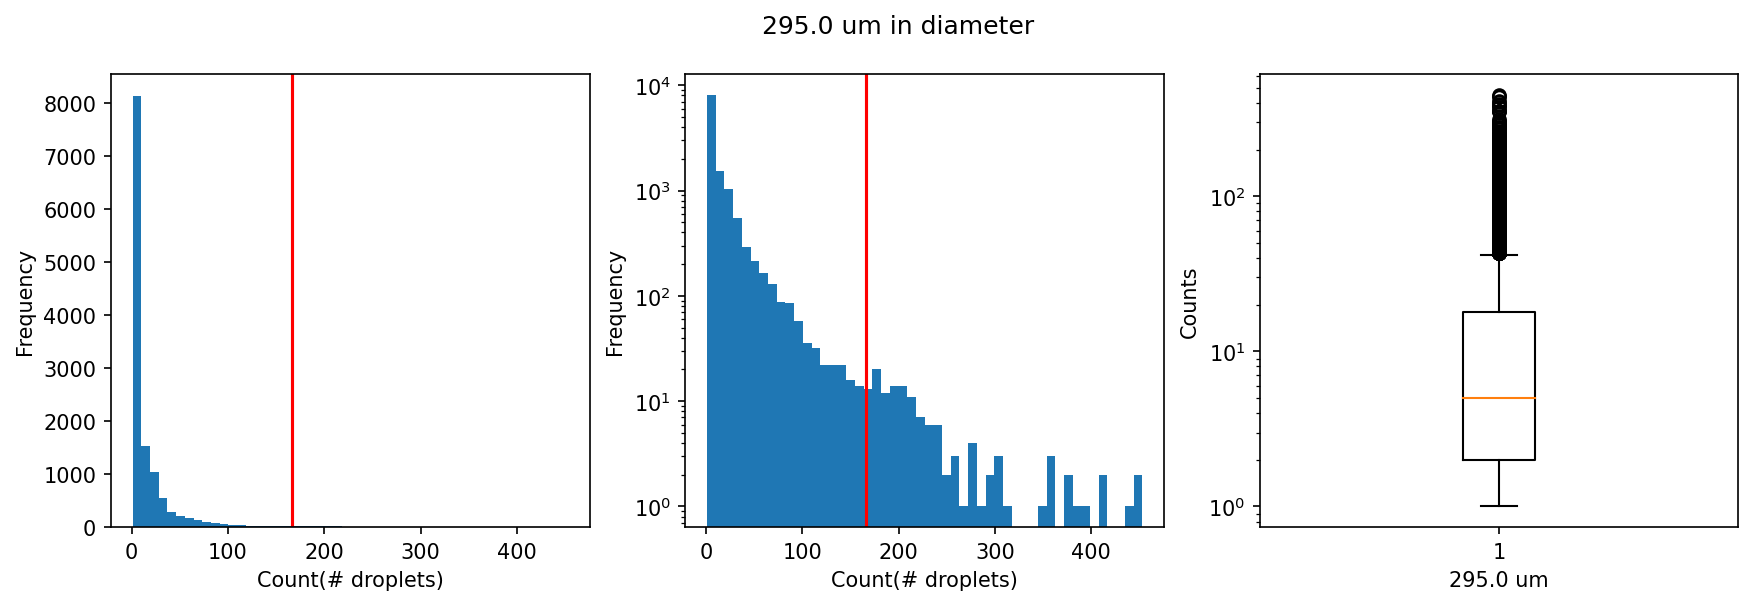

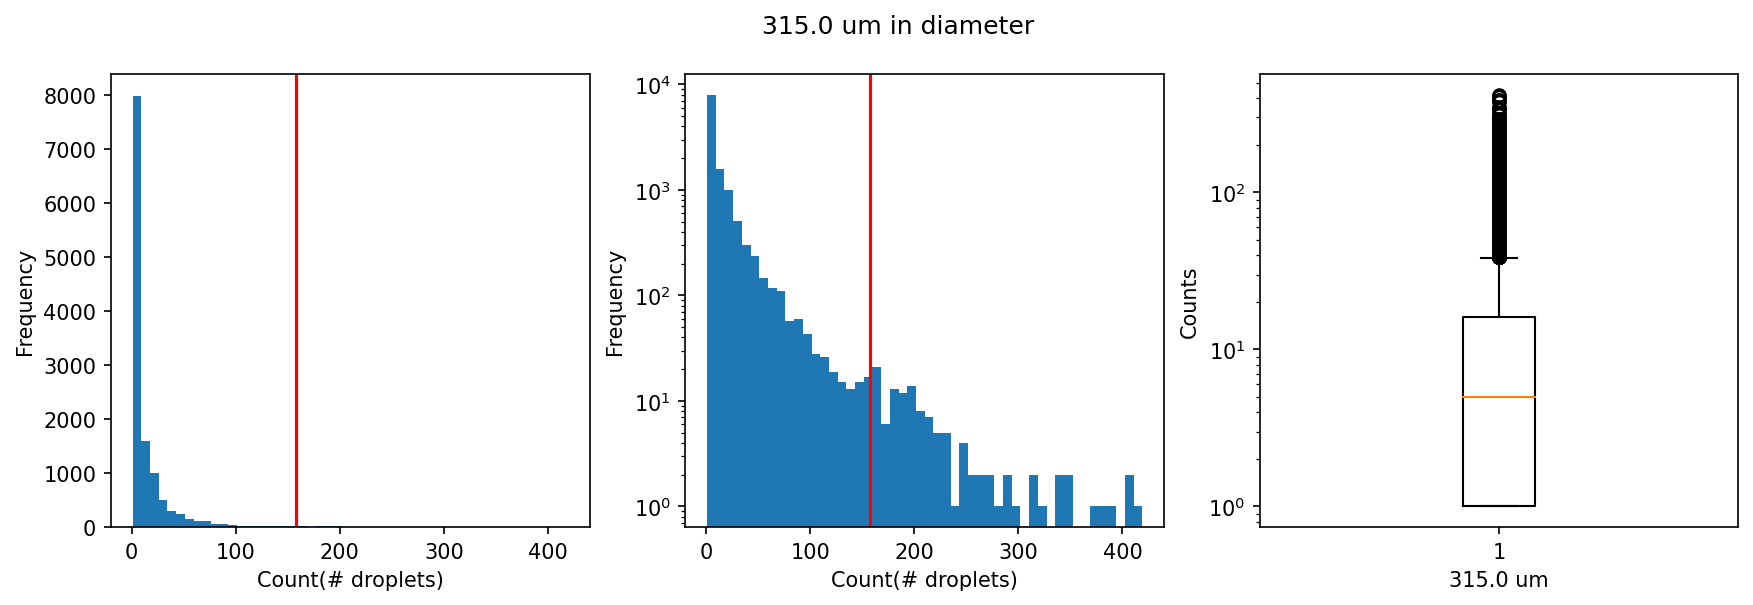

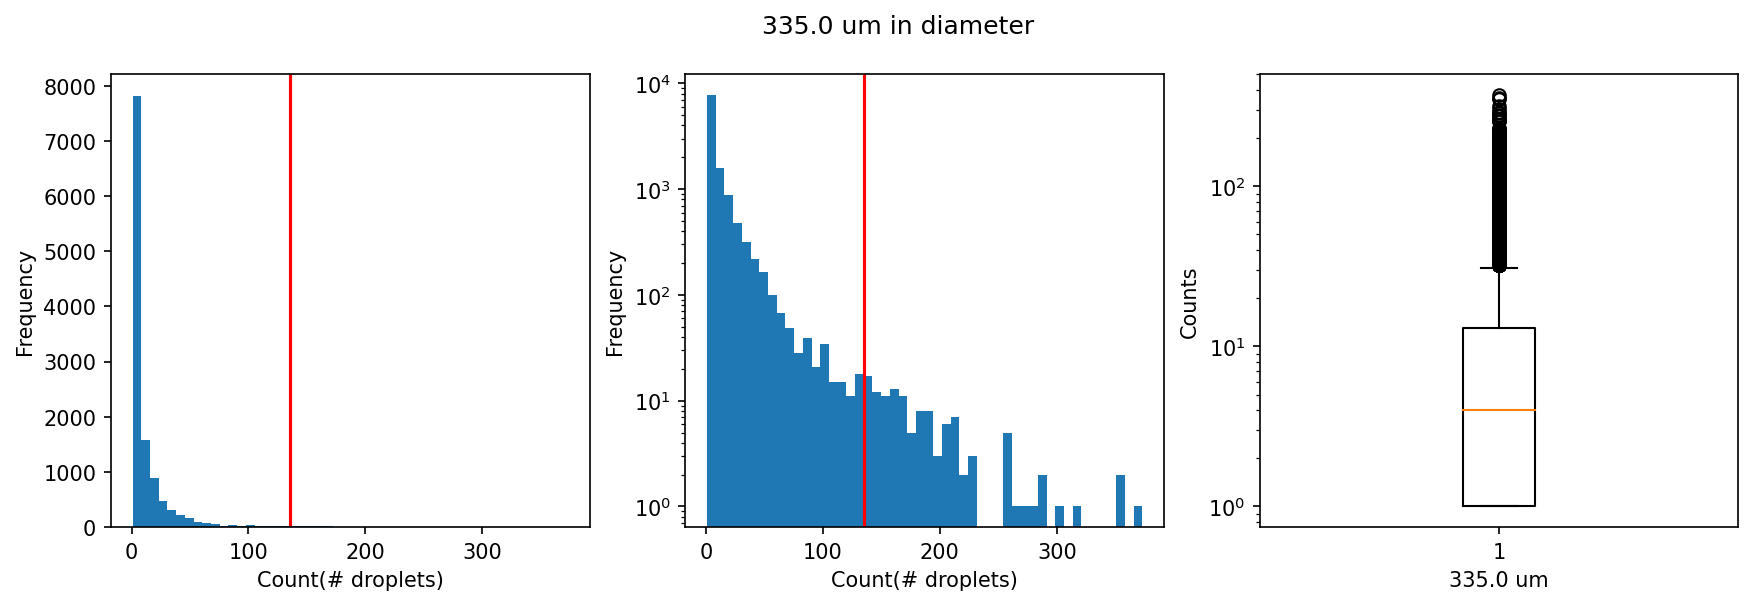

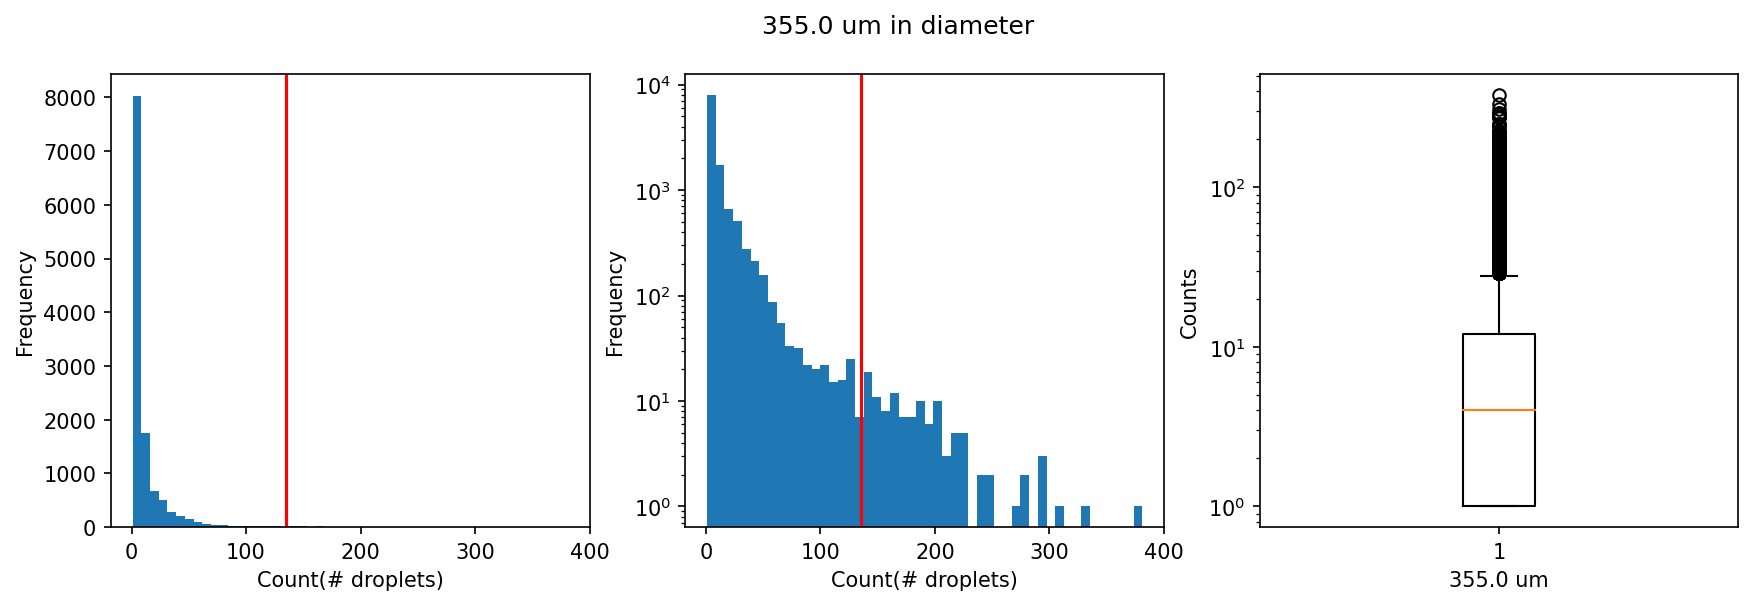

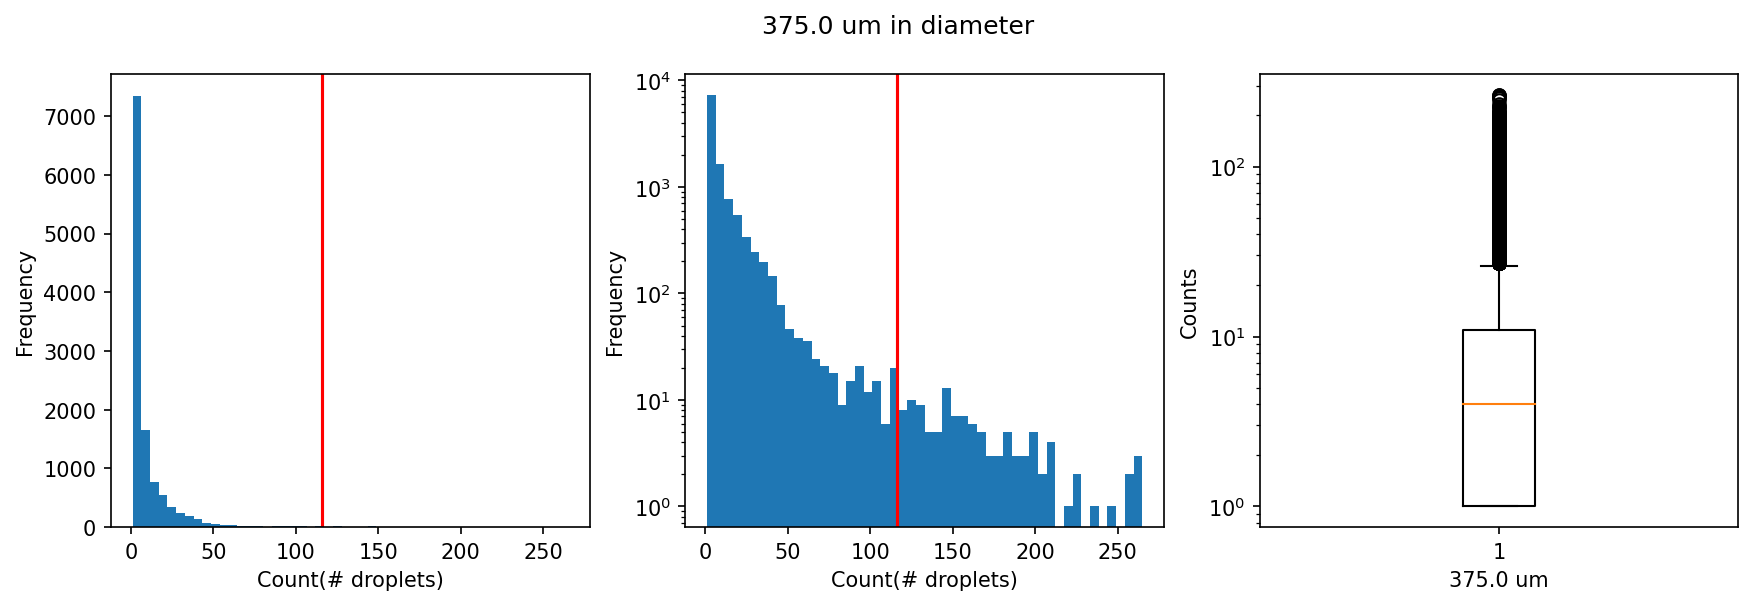

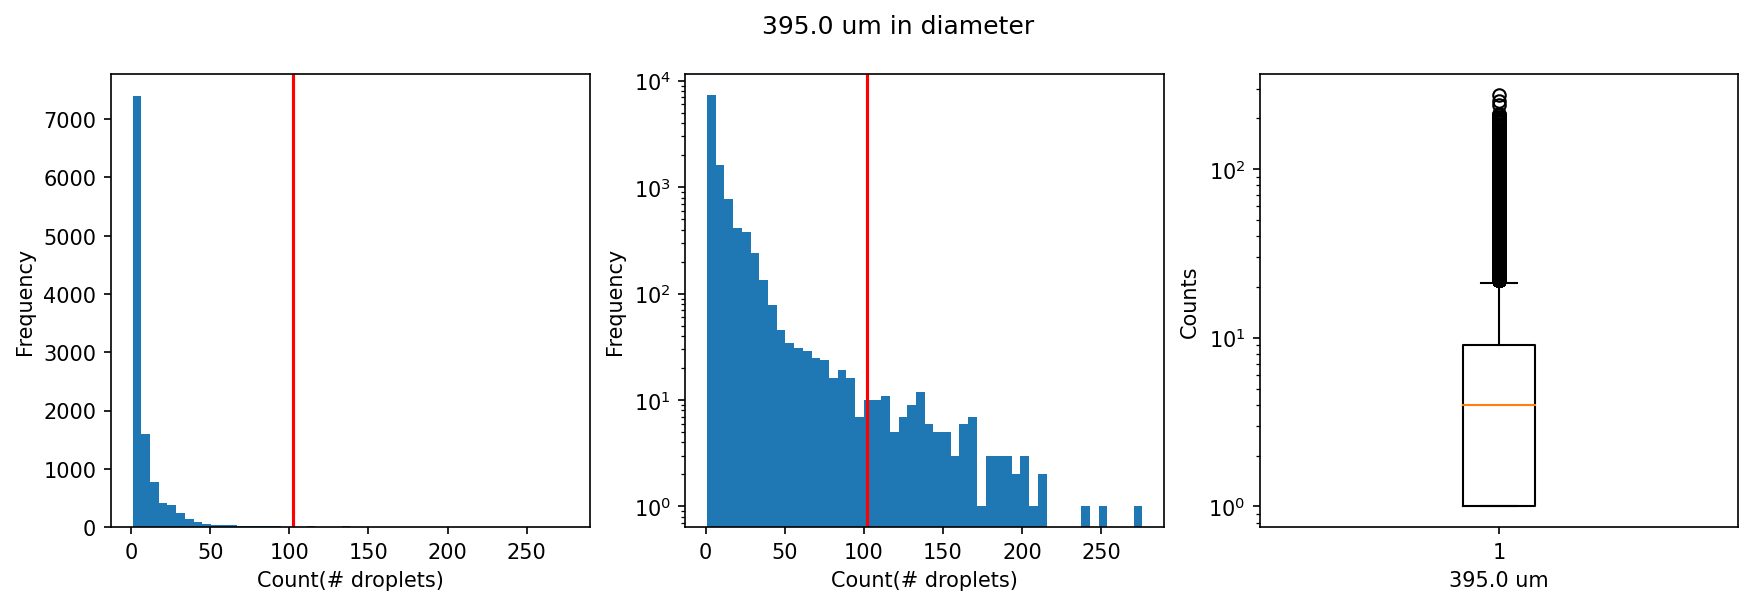

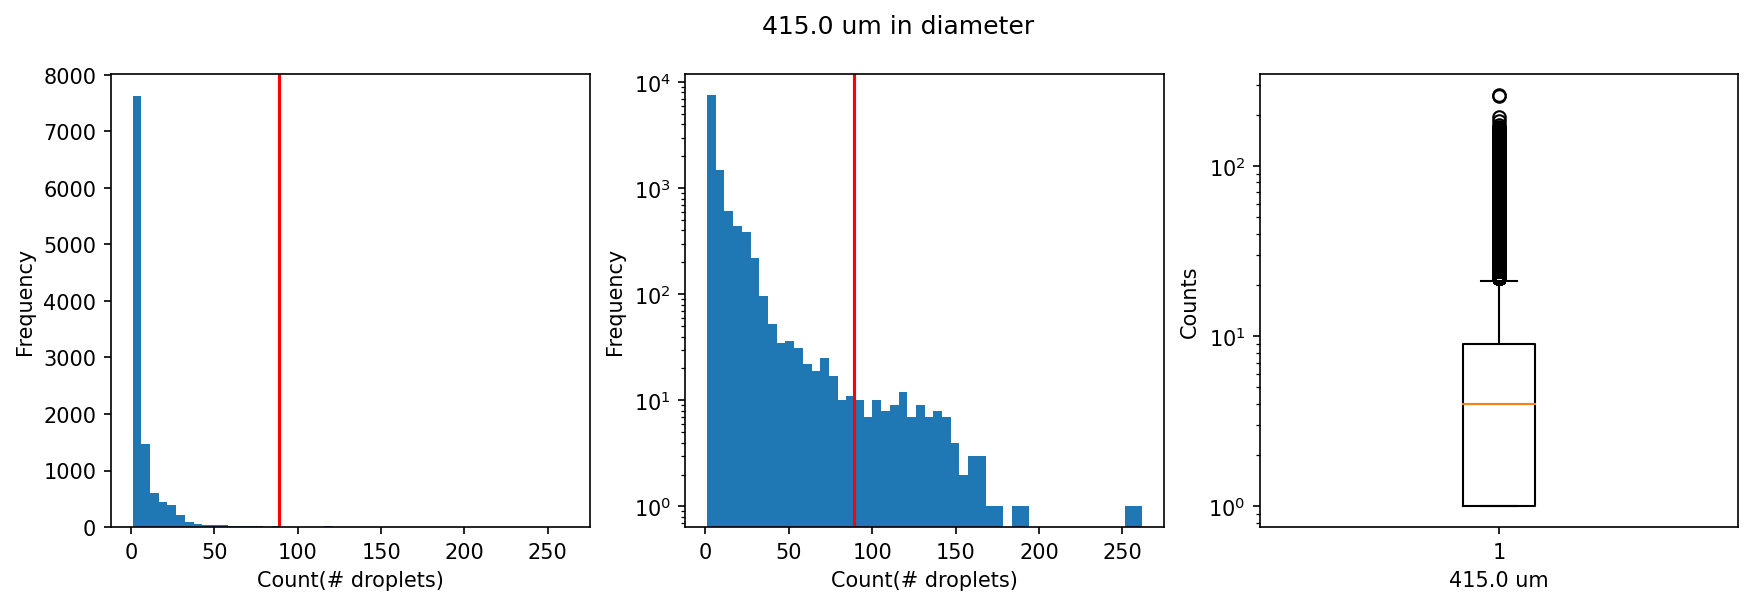

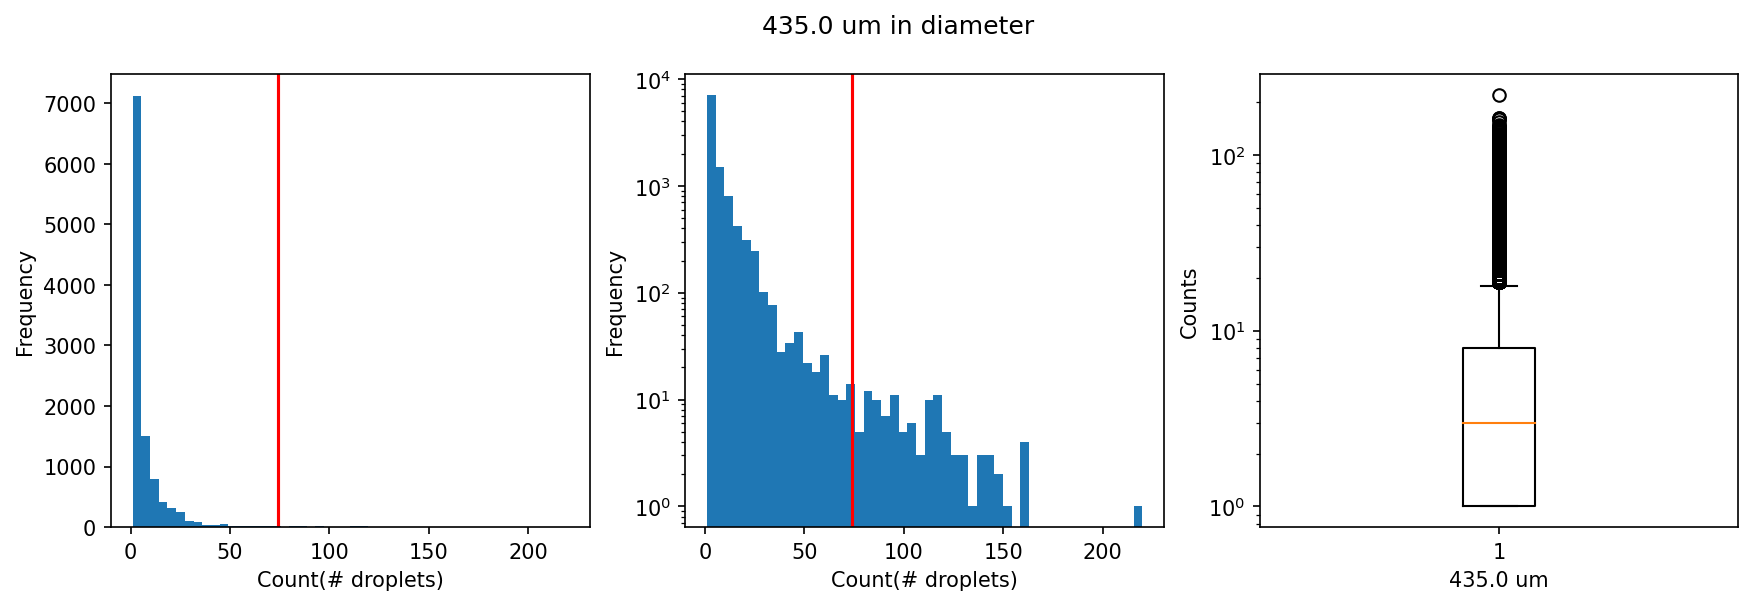

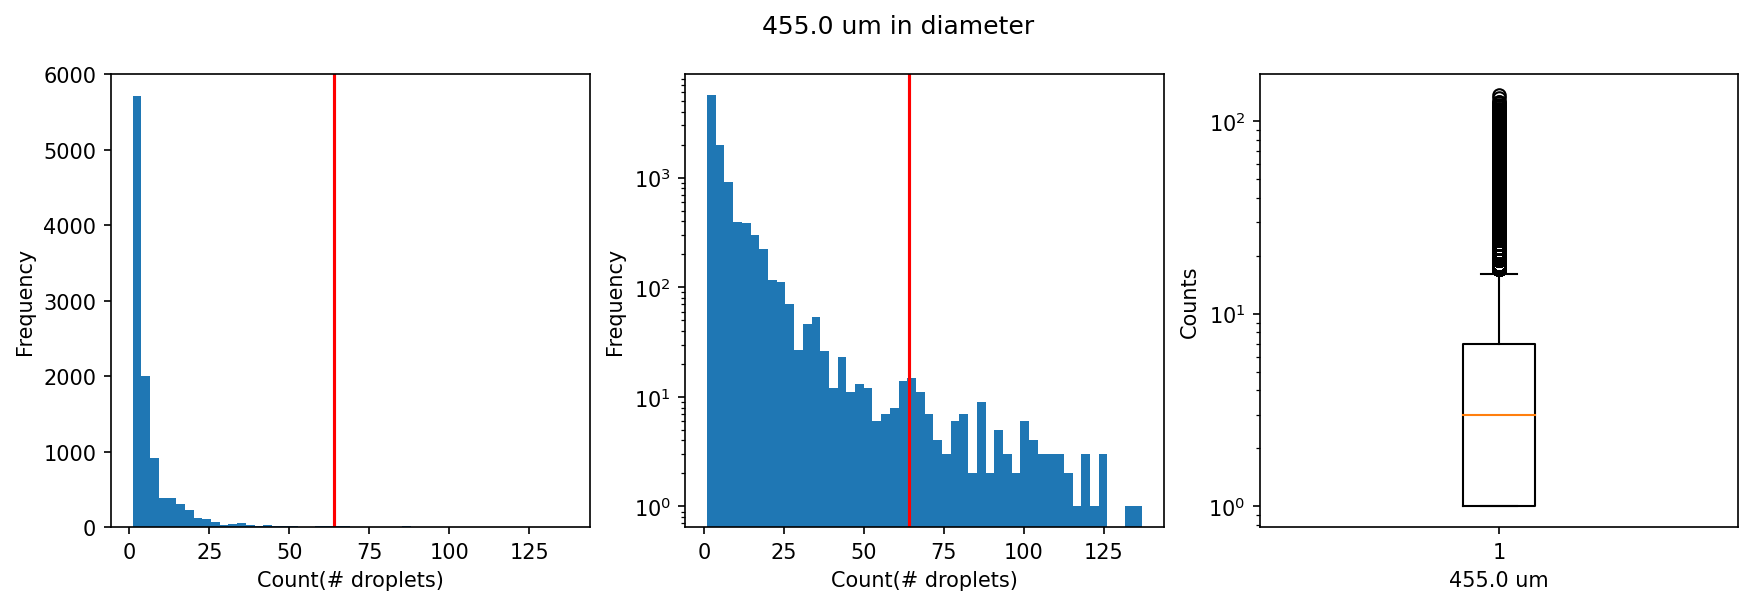

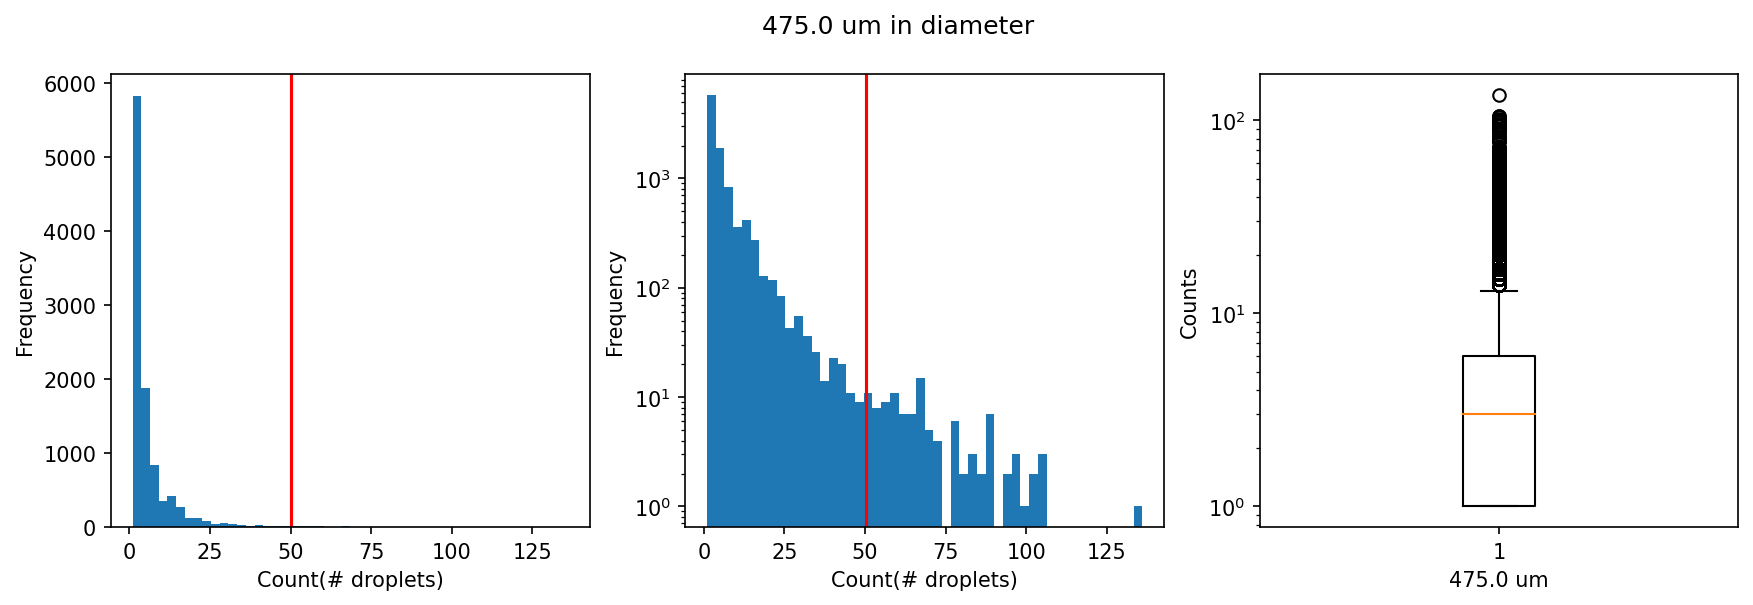

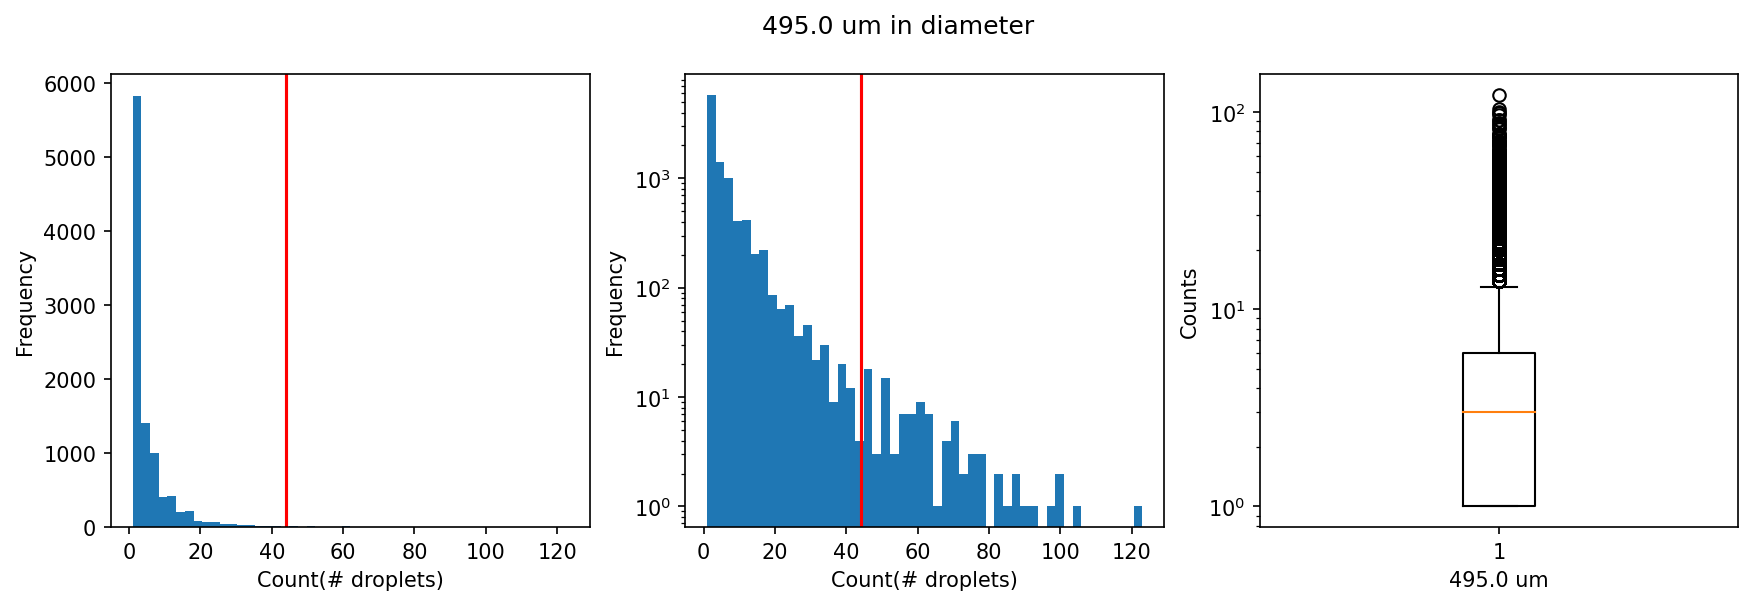

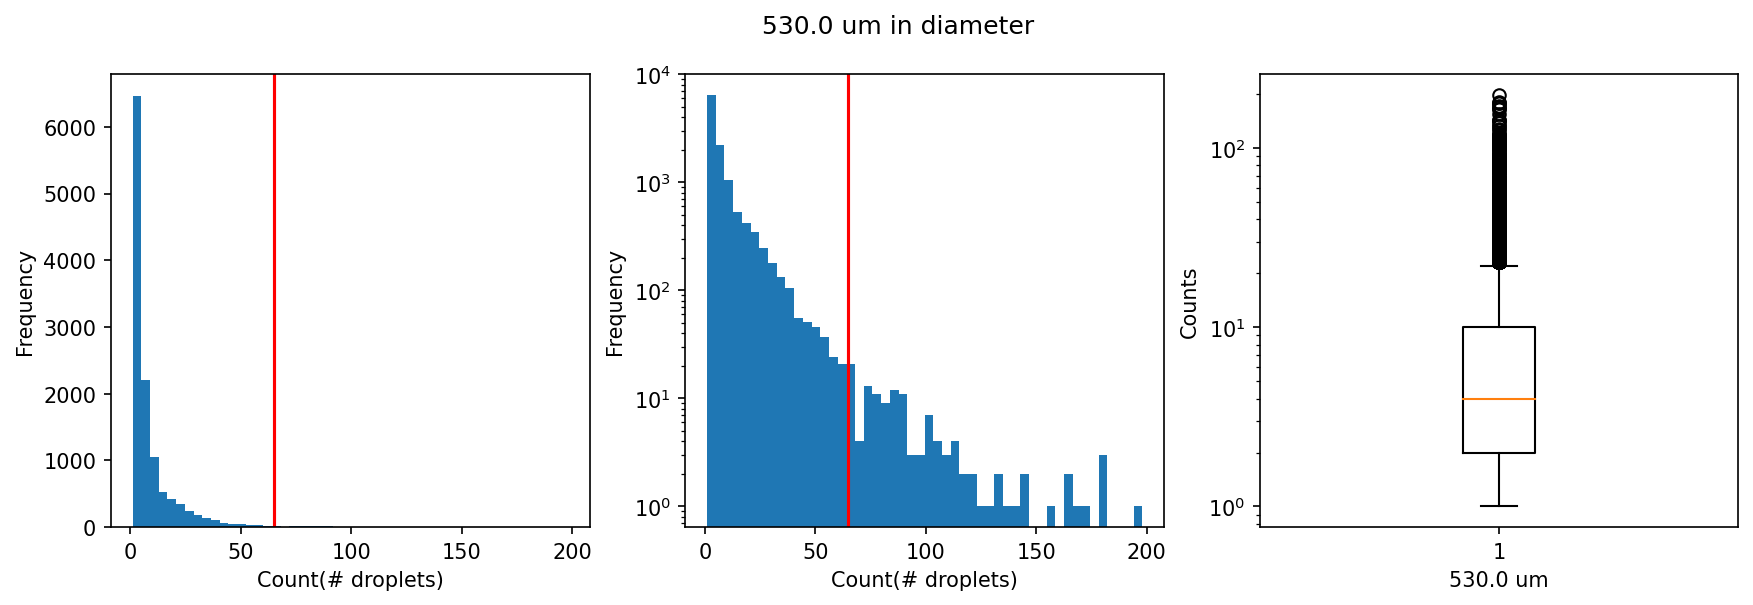

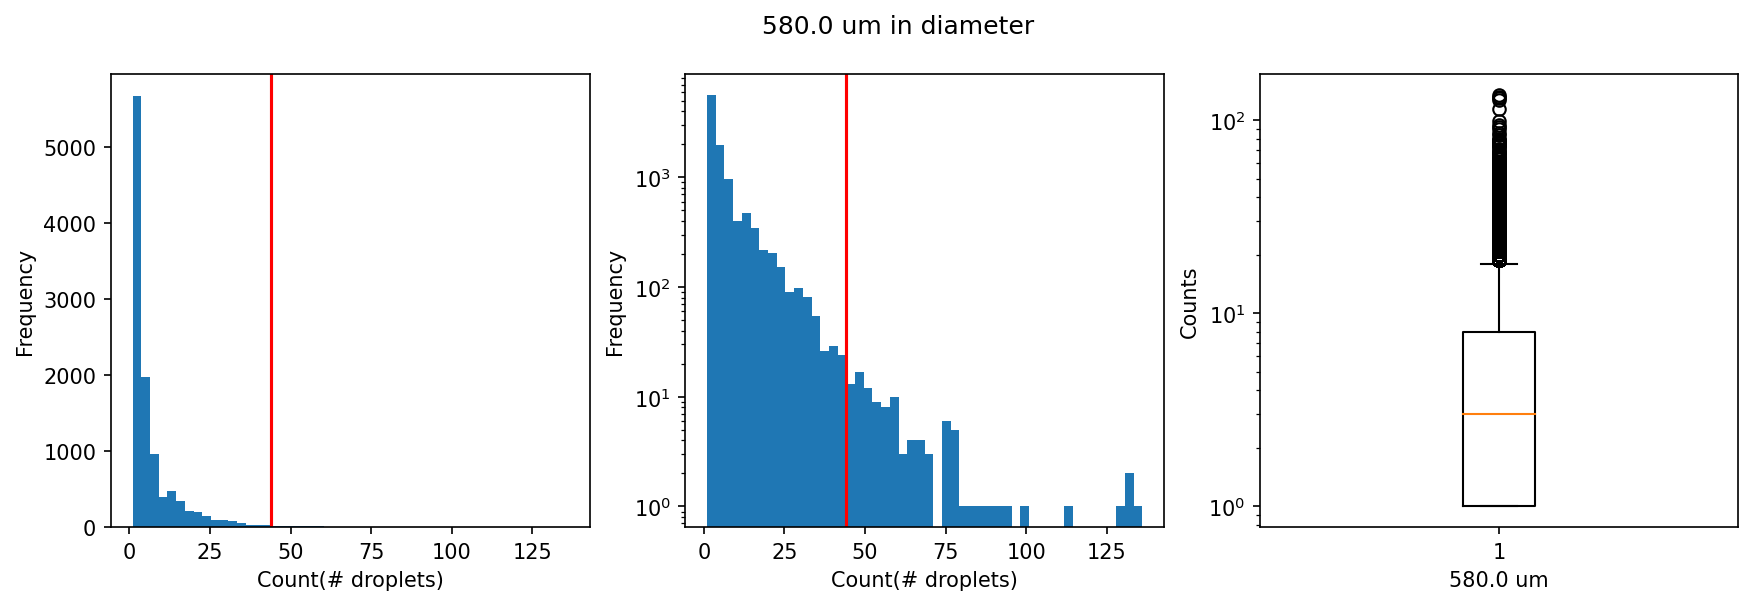

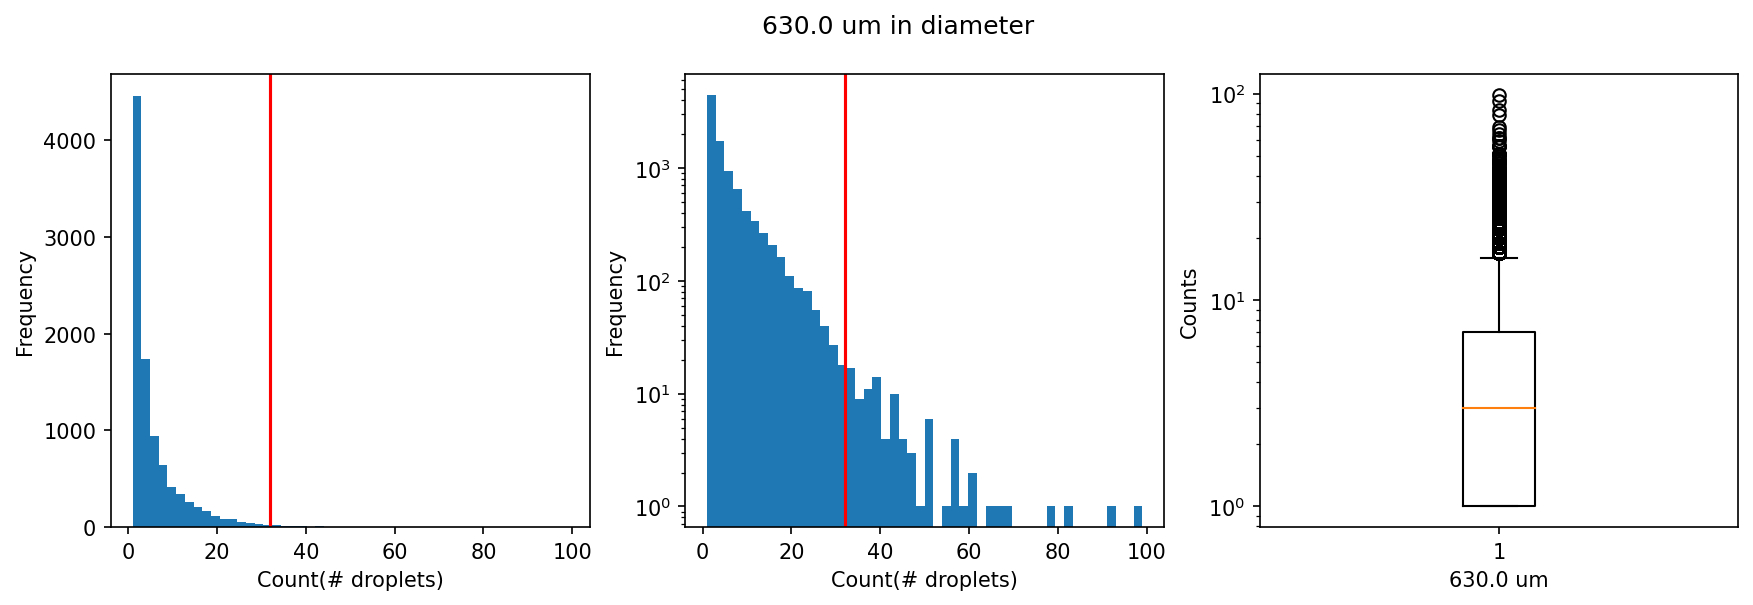

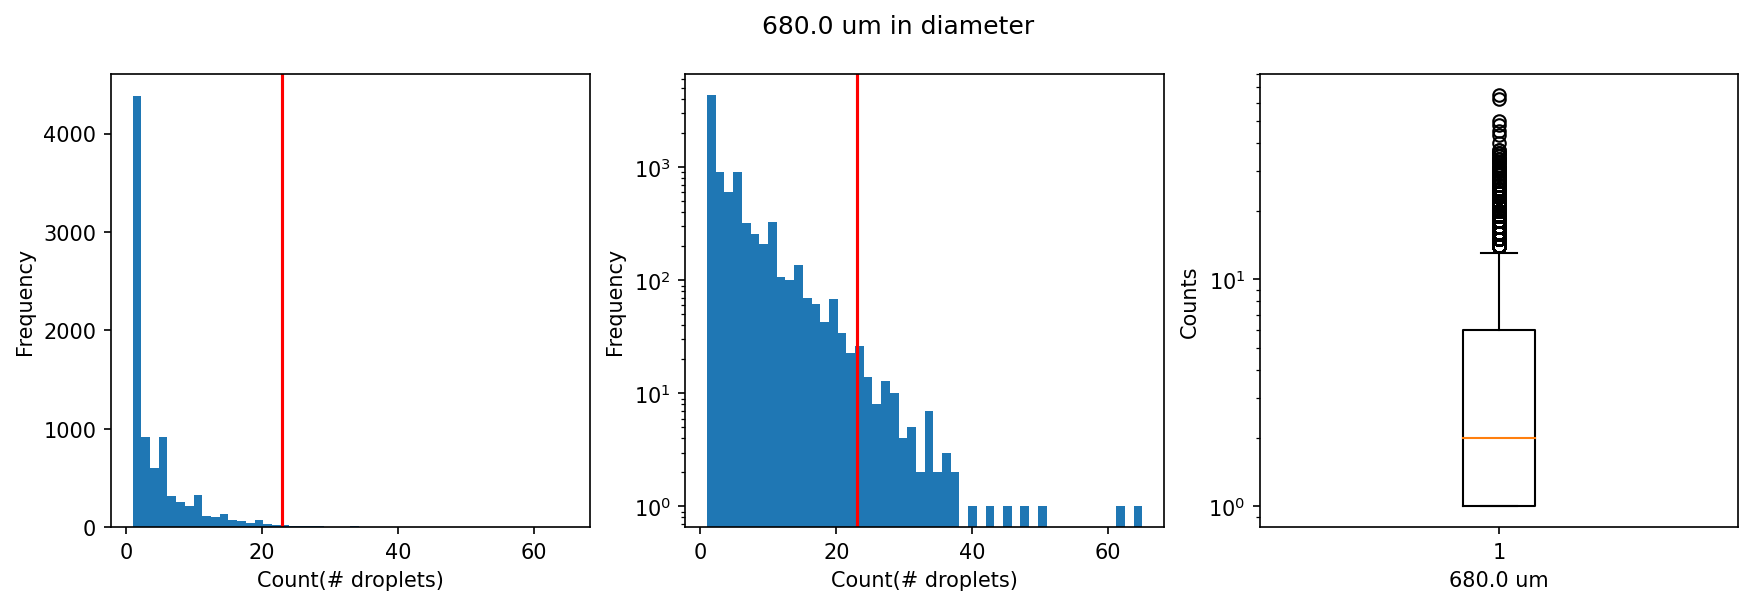

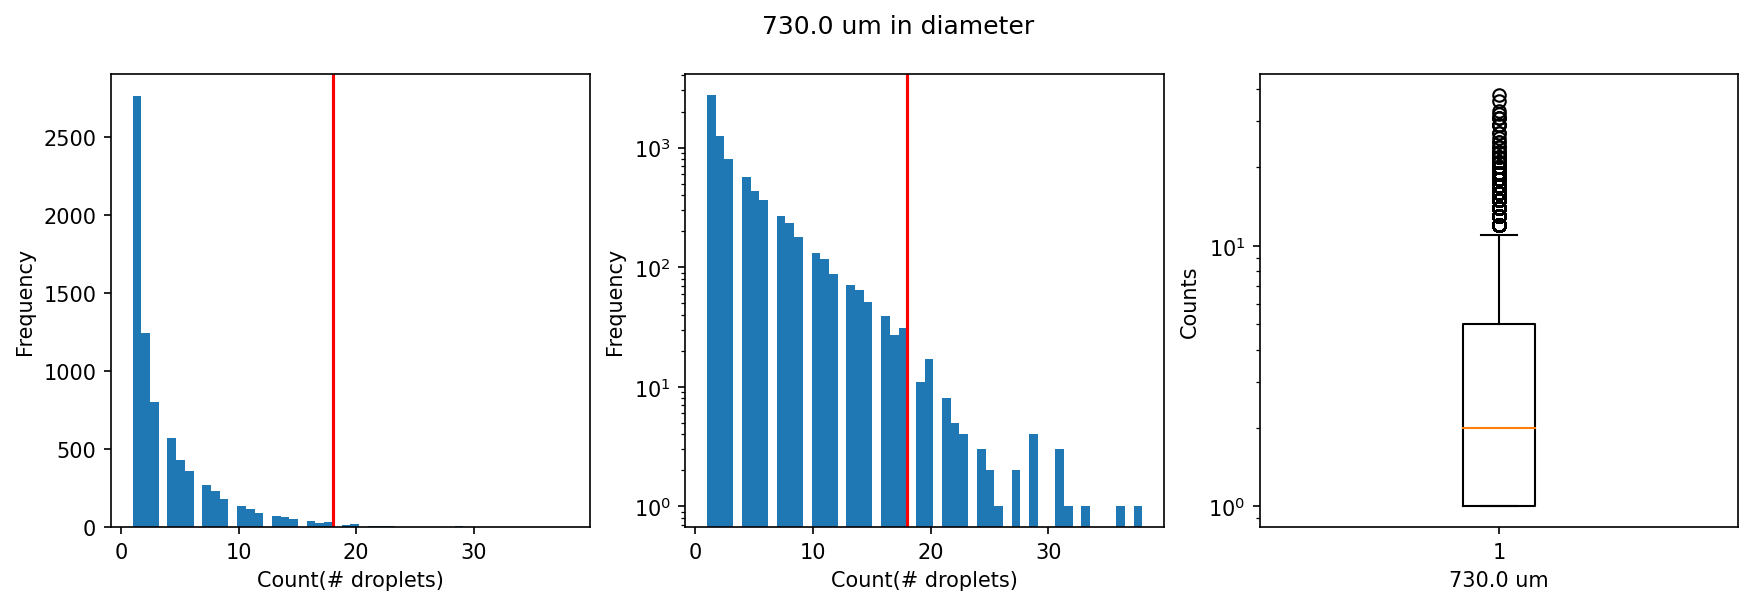

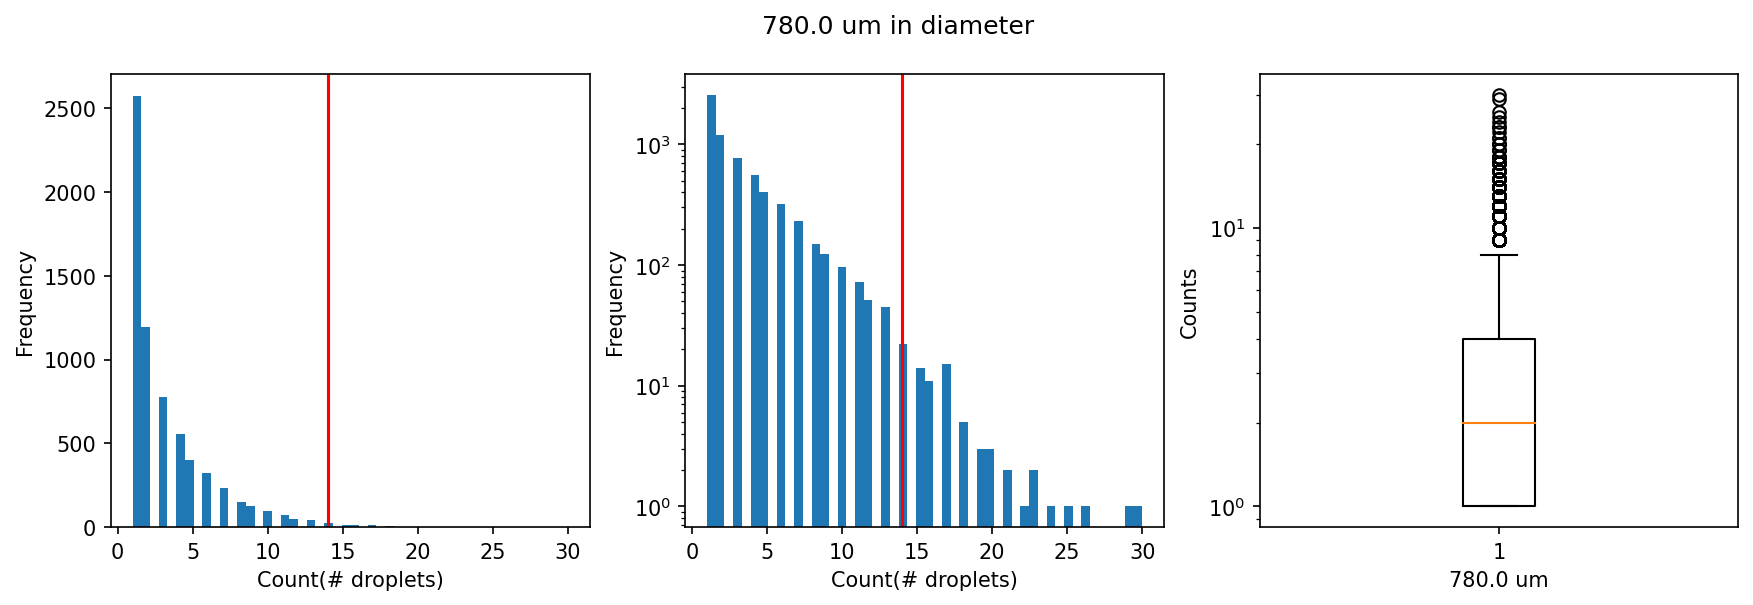

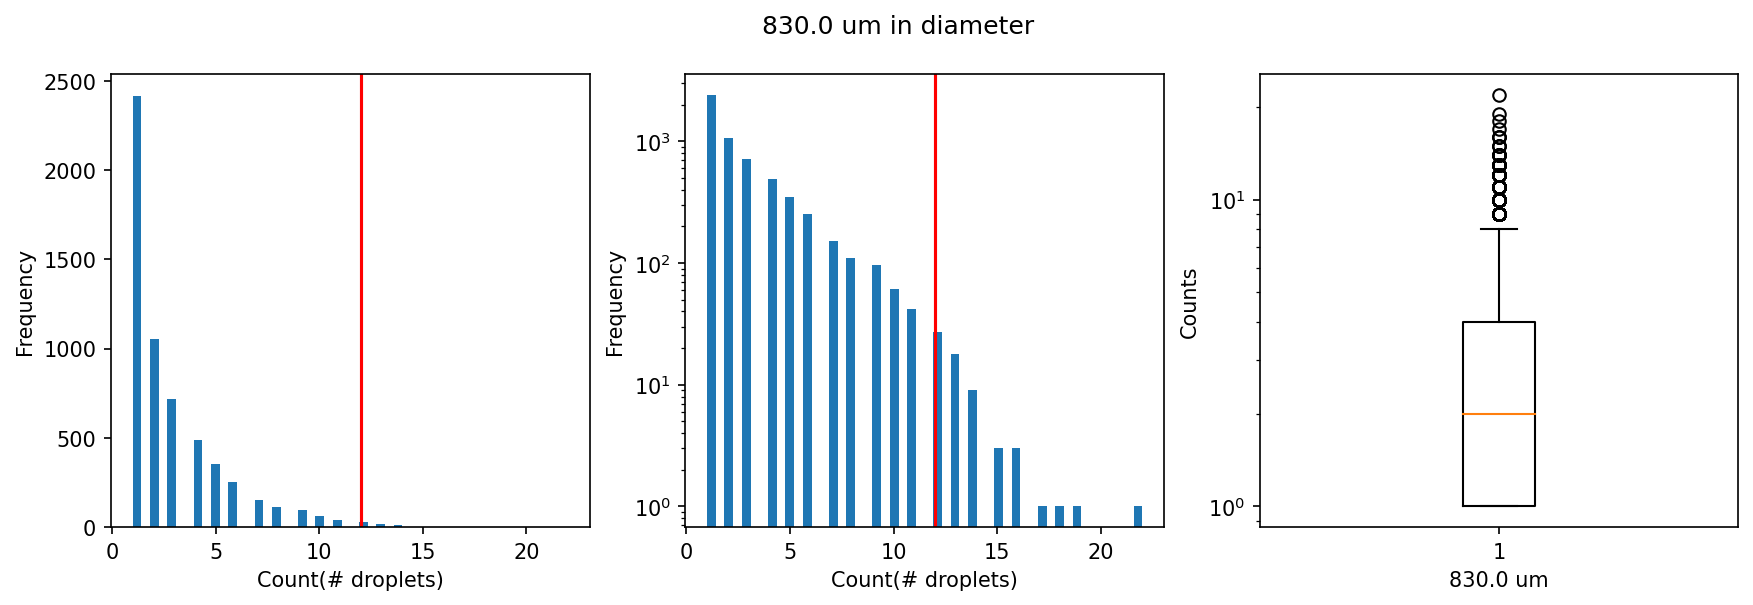

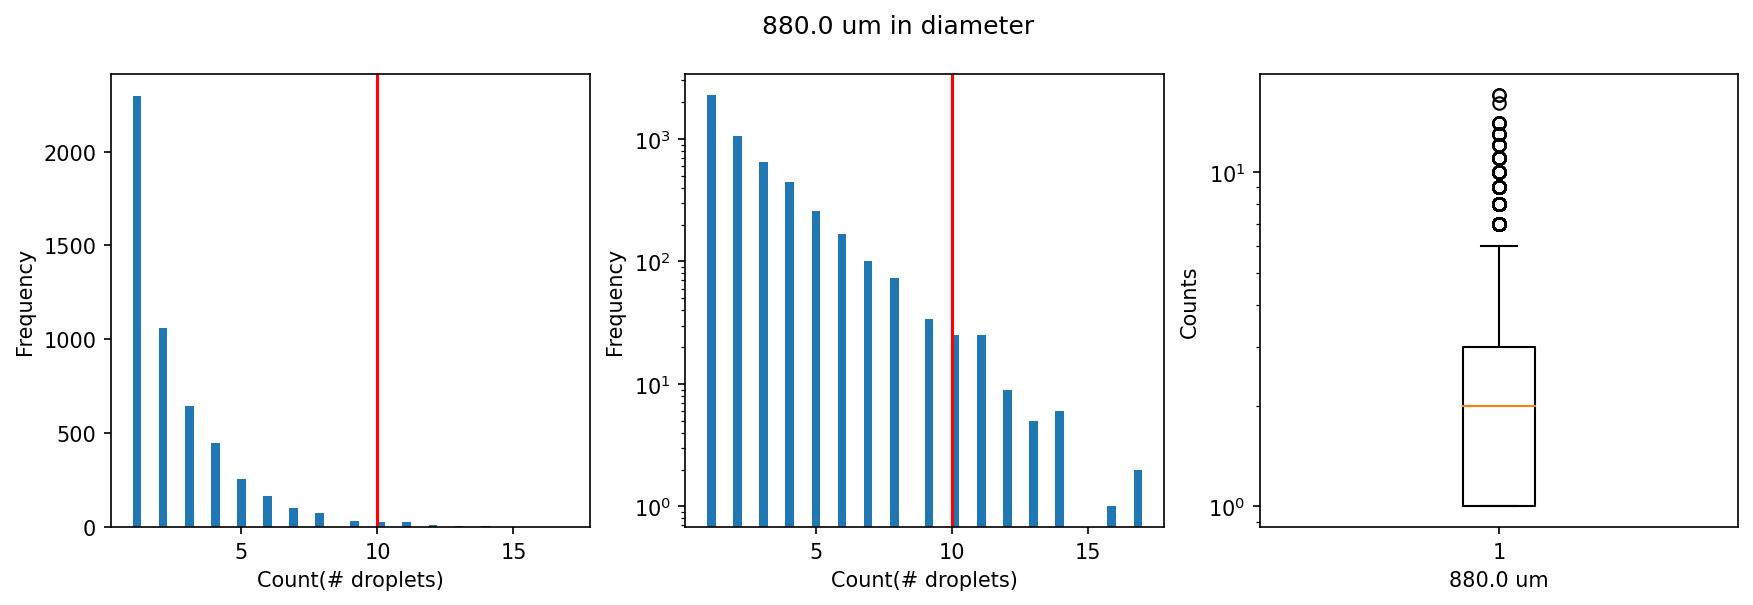

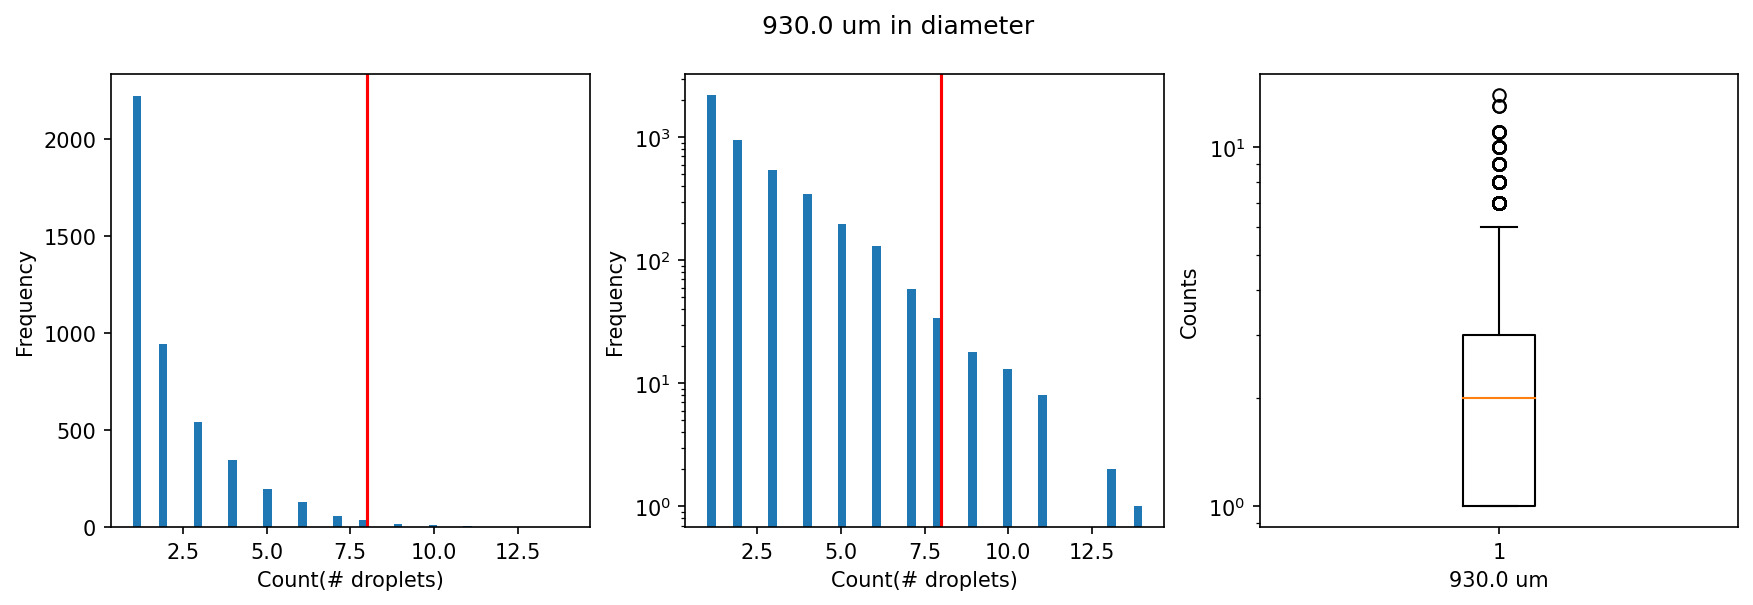

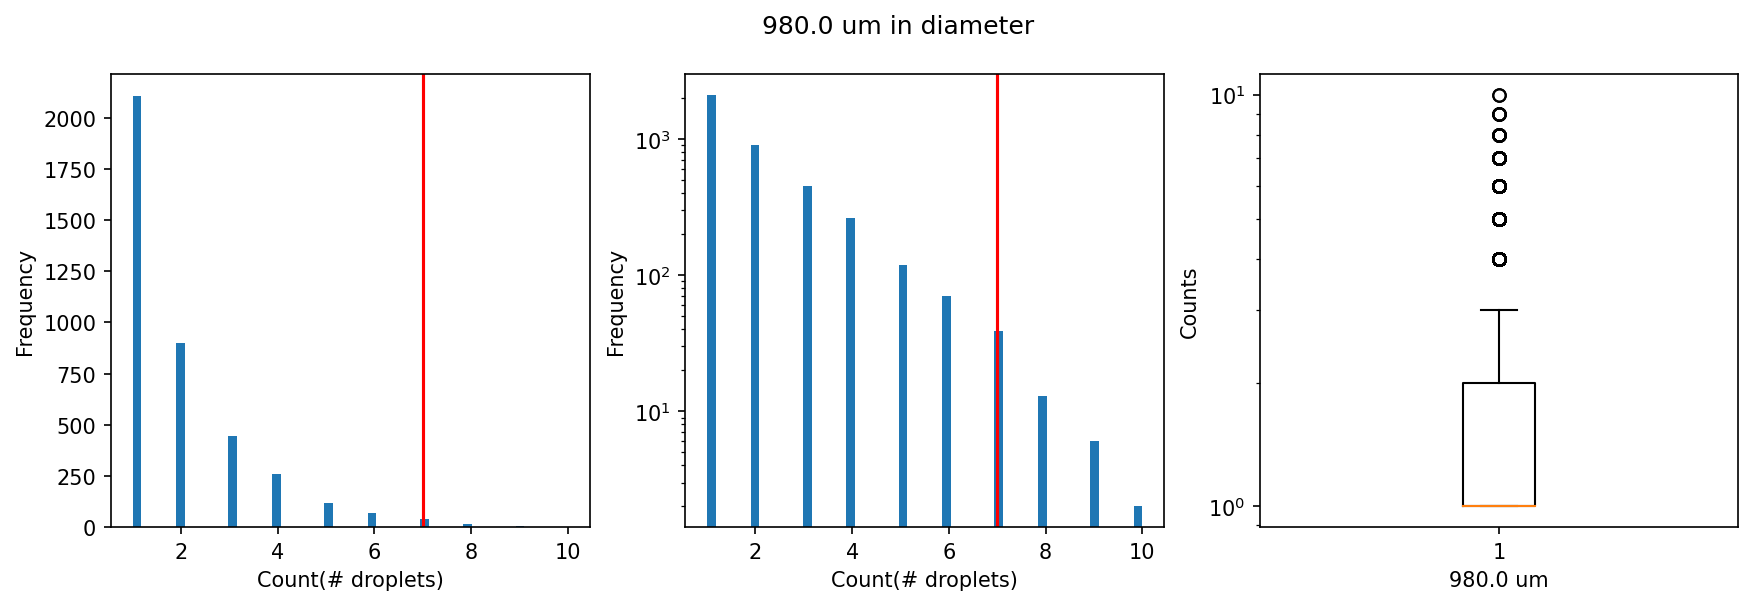

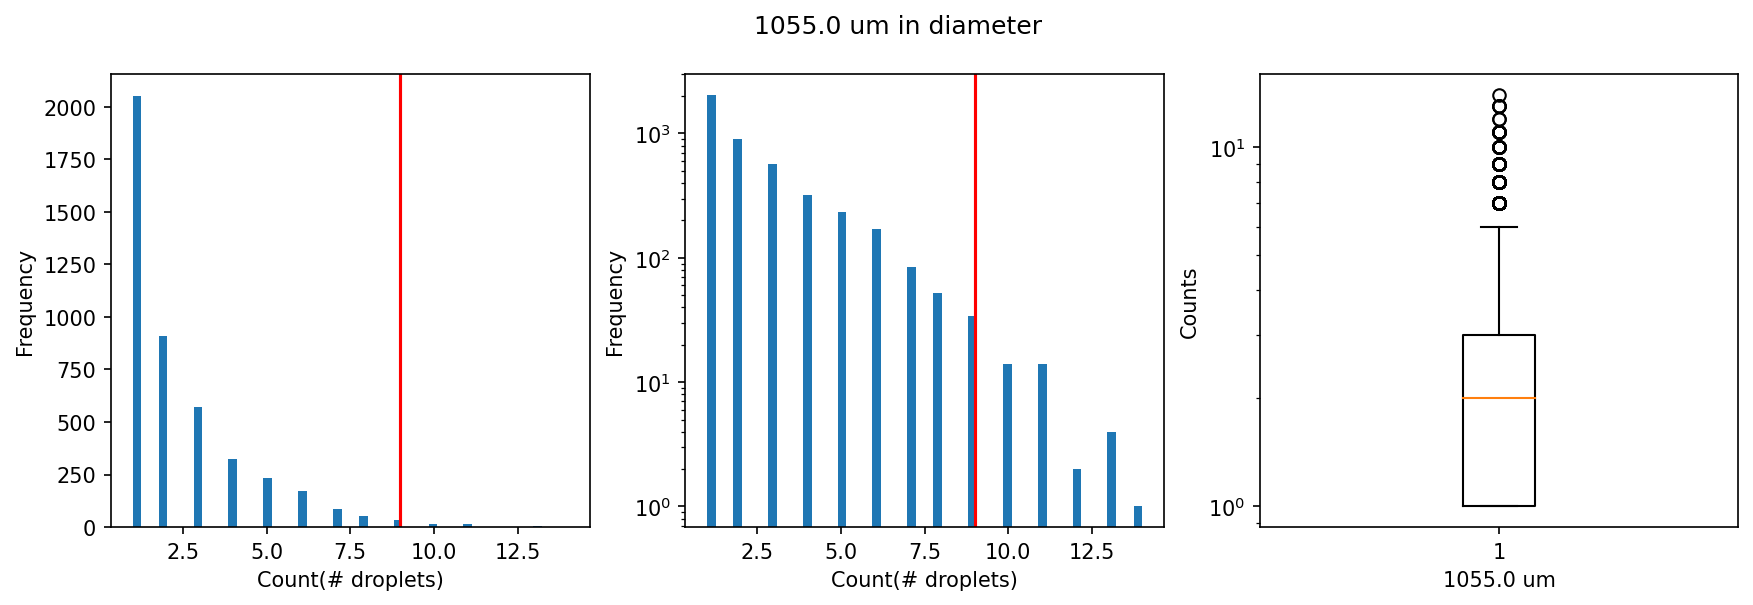

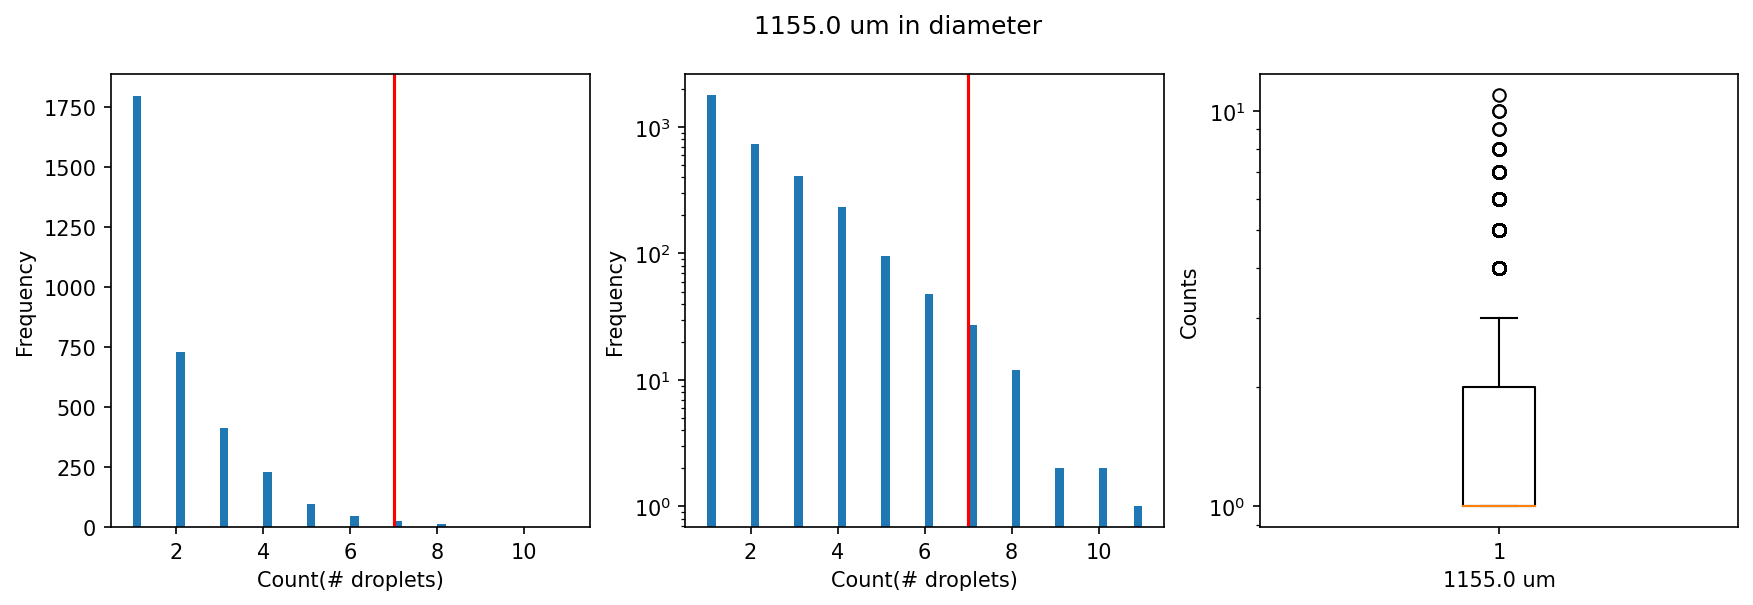

In [45]:
q = 0.99
for i in xr_2ds.diameter.sel(diameter=slice(10, 1200)):
    data =  xr_2ds.cnt_bin.sel(diameter=i)
    data = data[(~data.isnull()) & (data > 0)]
    qtl = data.compute().quantile([q], dim=['time'])
    fig, (ax, ax1, ax2) = plt.subplots(1,3, figsize=(14, 4), dpi=150)
    _ = ax.hist(data, bins=50)#, density=True)
    _ = ax1.hist(data, bins=50)#, density=True)
    _ = ax2.boxplot(data)
    
    ax.axvline(qtl.sel(quantile=q), 0, c='red')
    ax1.axvline(qtl.sel(quantile=q), 0, c='red')
    ax.set_ylabel('Frequency')
    ax1.set_ylabel('Frequency')
    ax.set_xlabel('Count(# droplets)')
    ax1.set_xlabel('Count(# droplets)')
    ax1.set_yscale('log')
    ax2.set_ylabel('Counts')
    ax2.set_yscale('log')
    ax2.set_xlabel(f'{i.values} um')
    fig.suptitle(f'{i.values} um in diameter')
    plt.show()


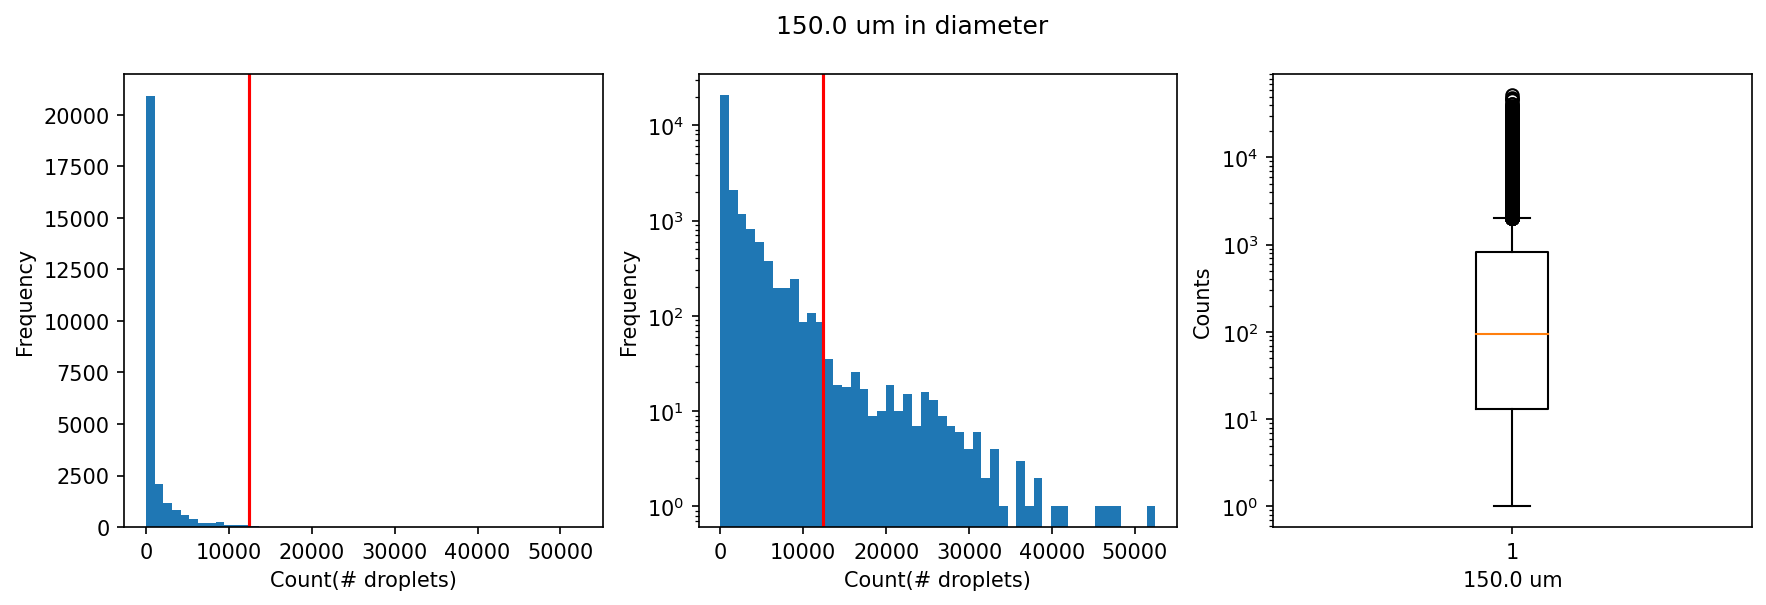

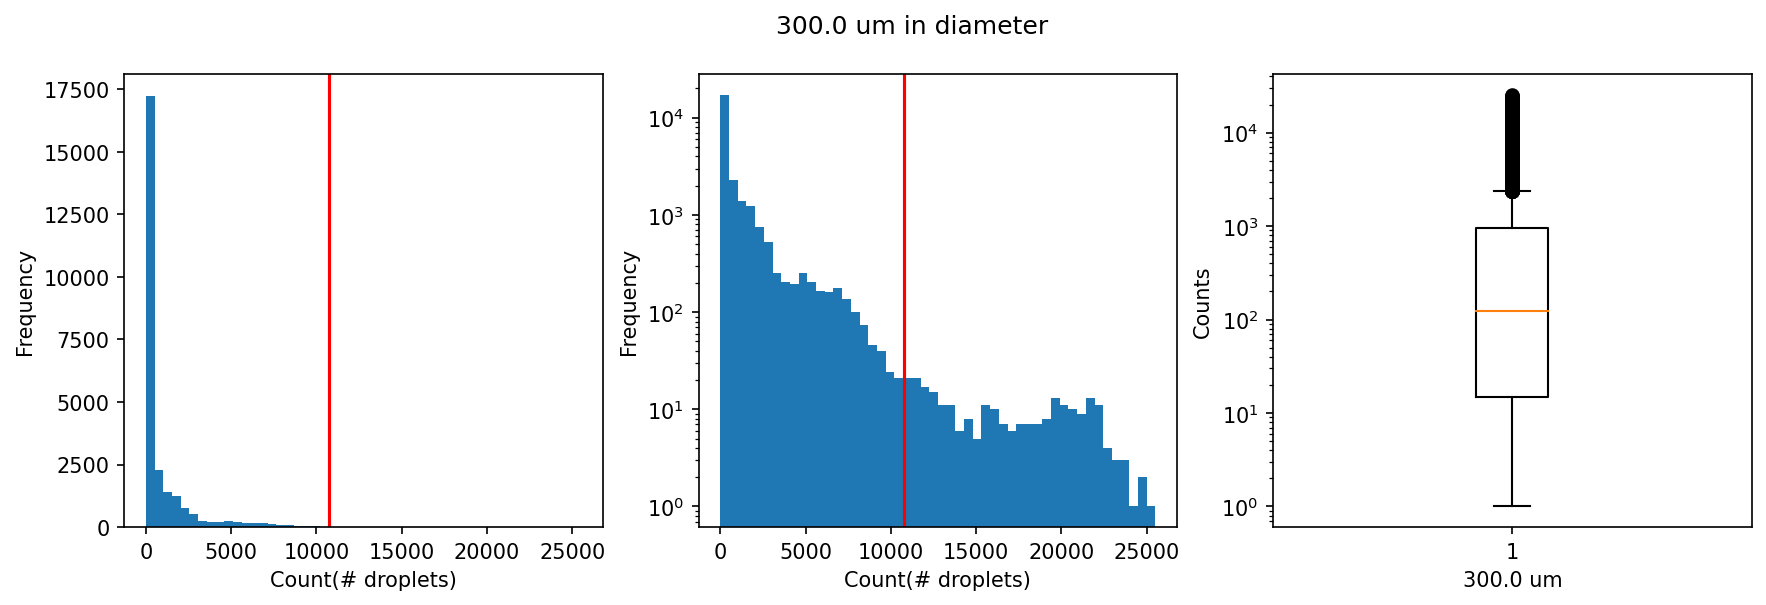

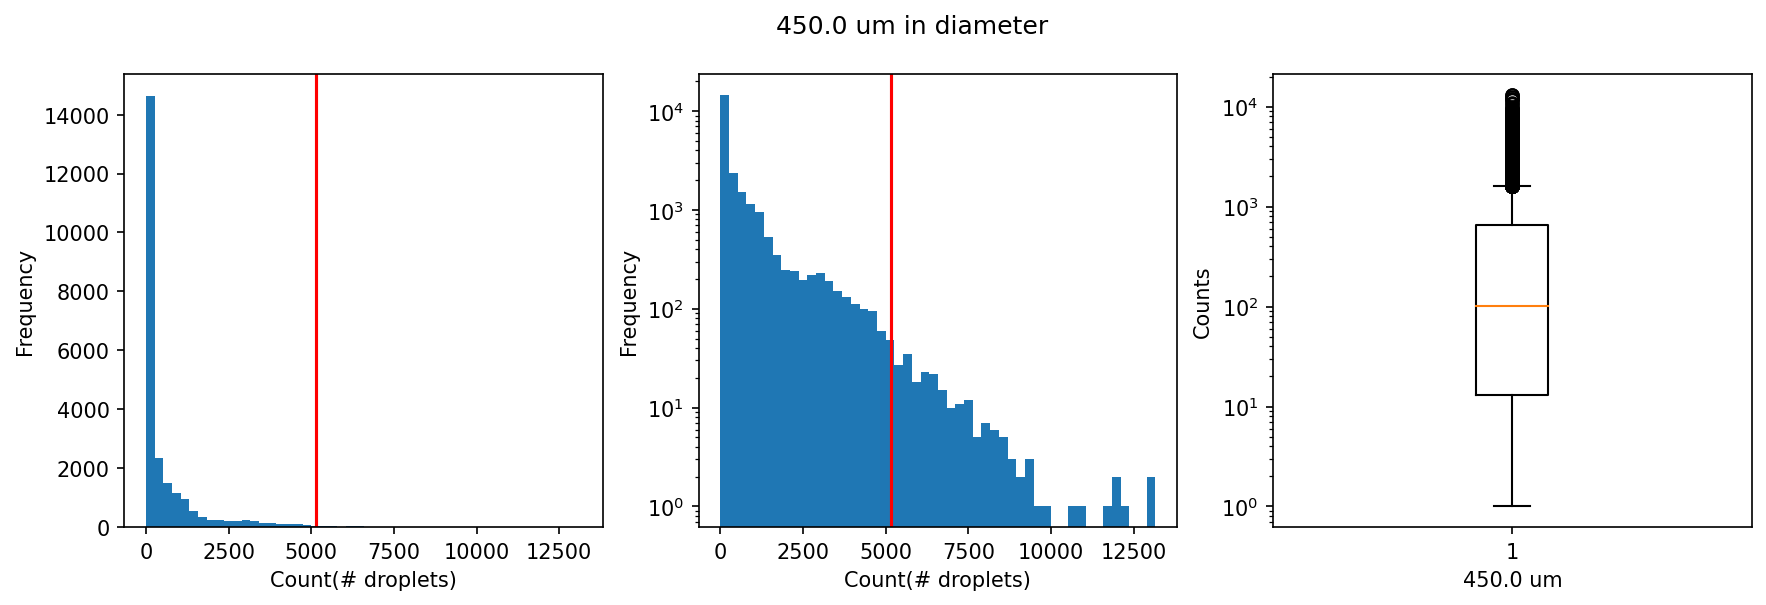

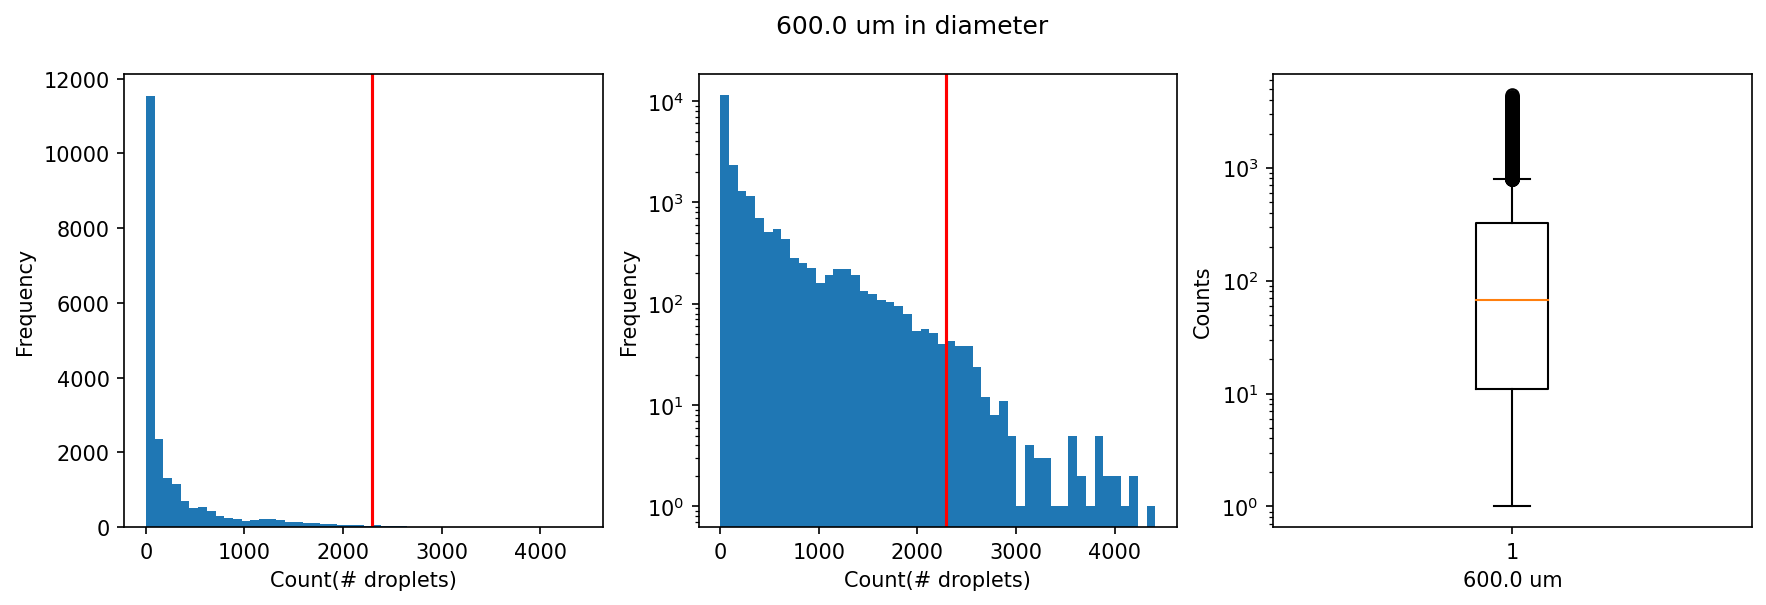

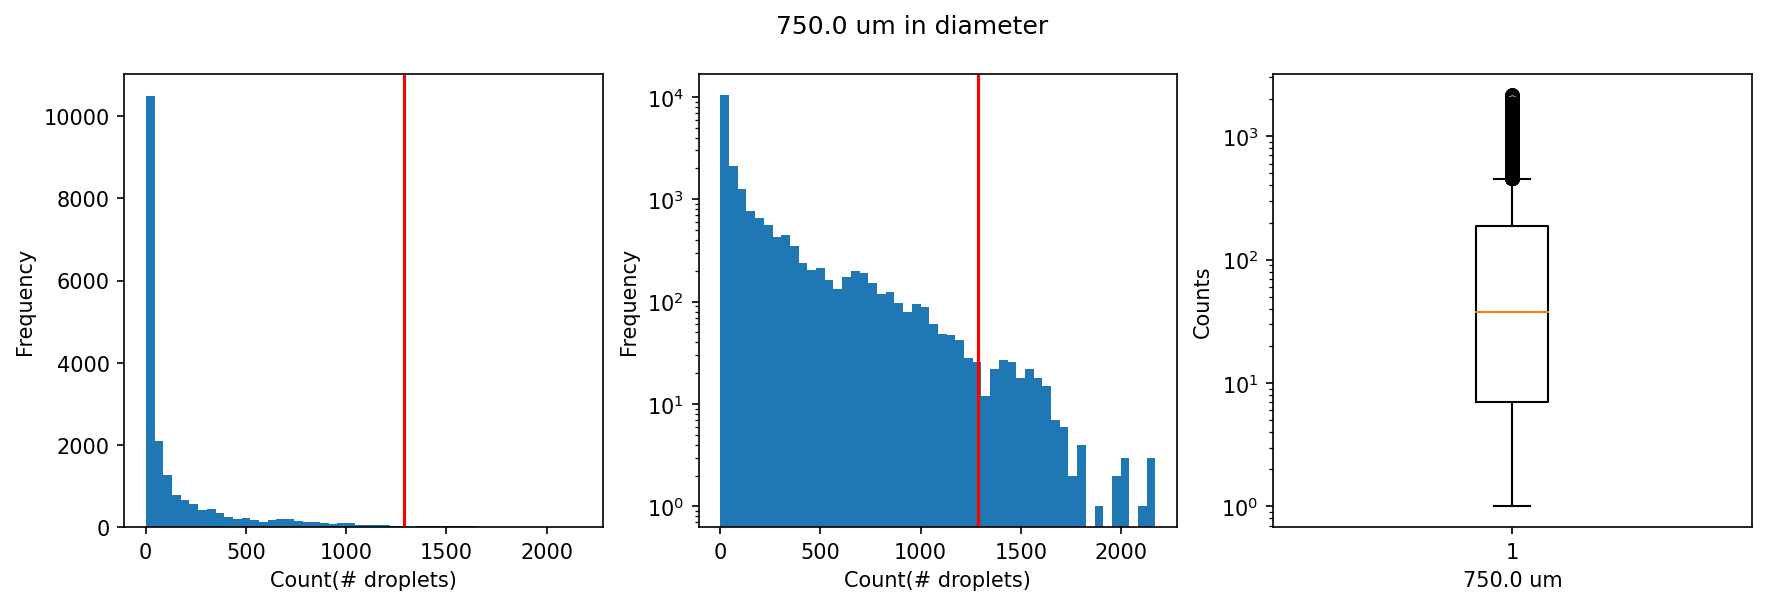

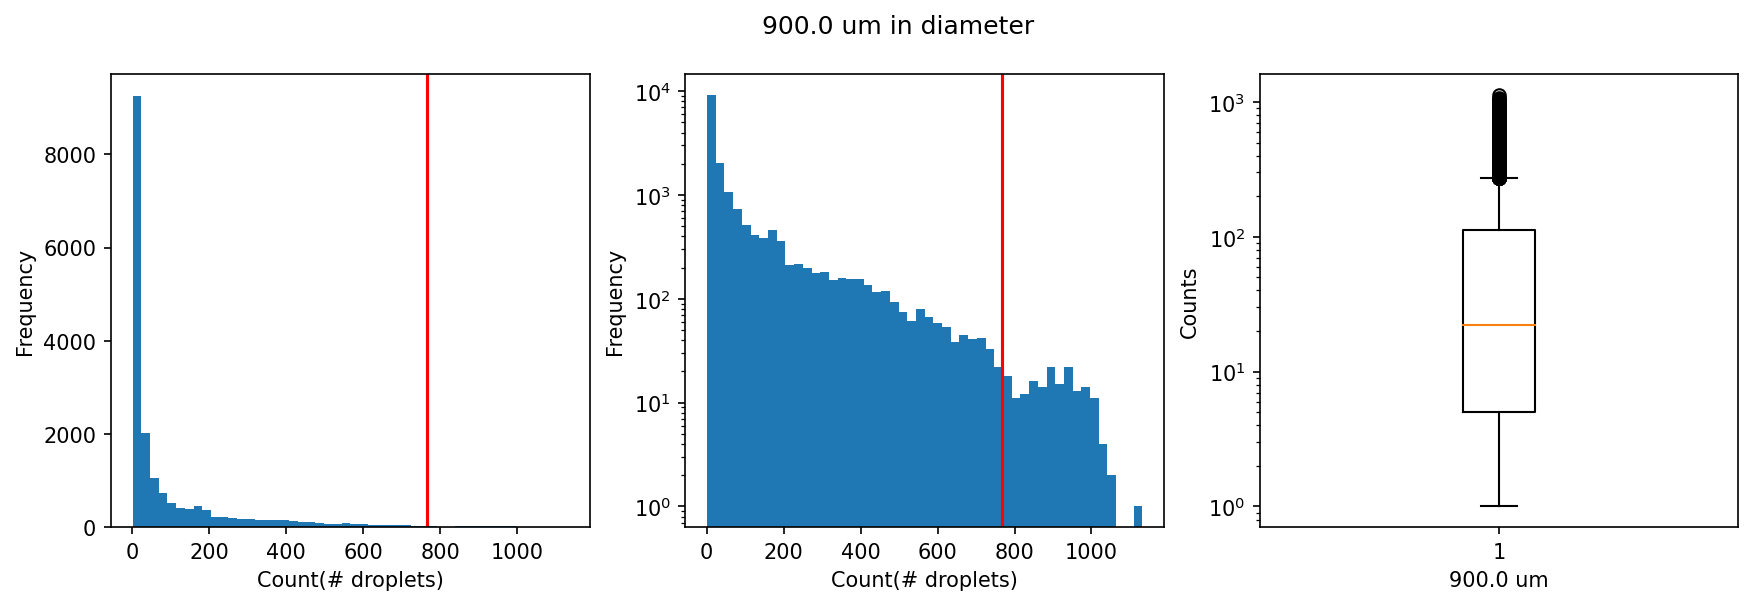

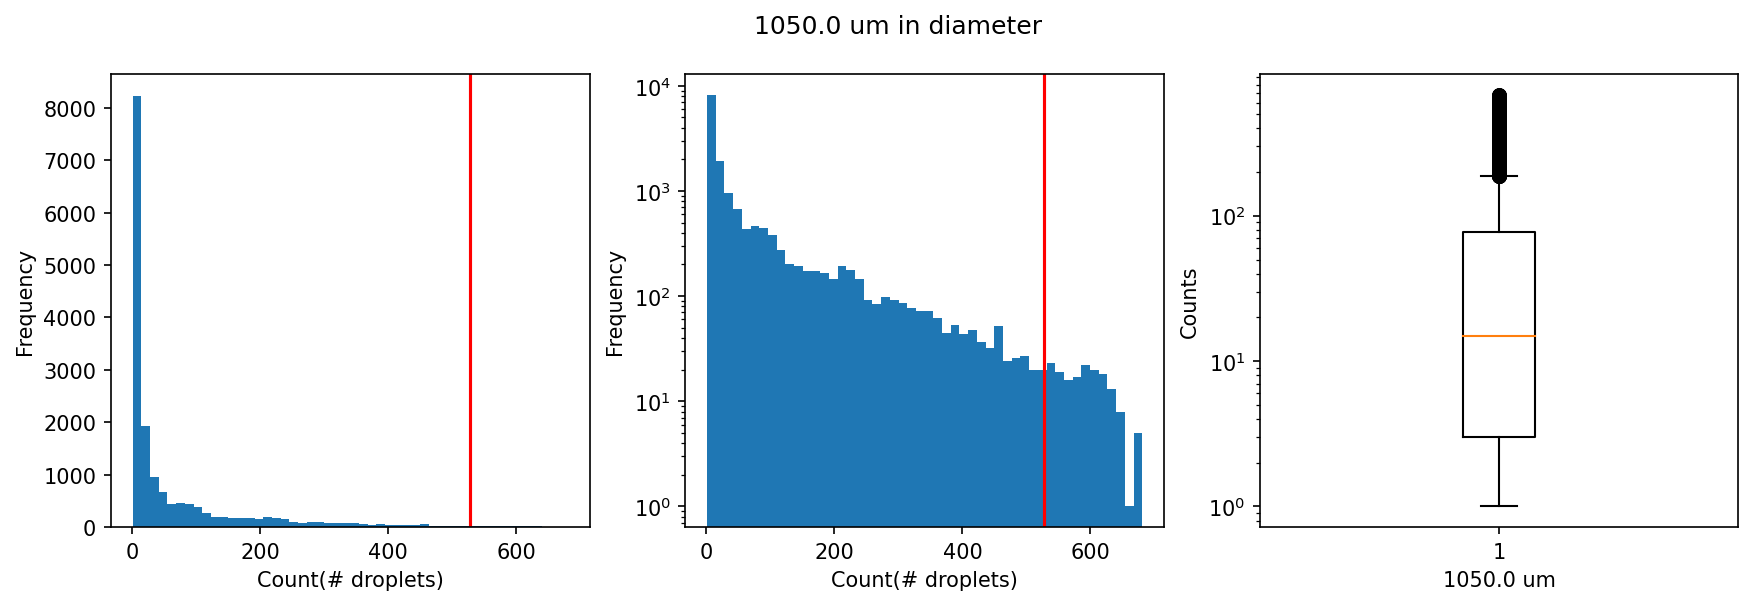

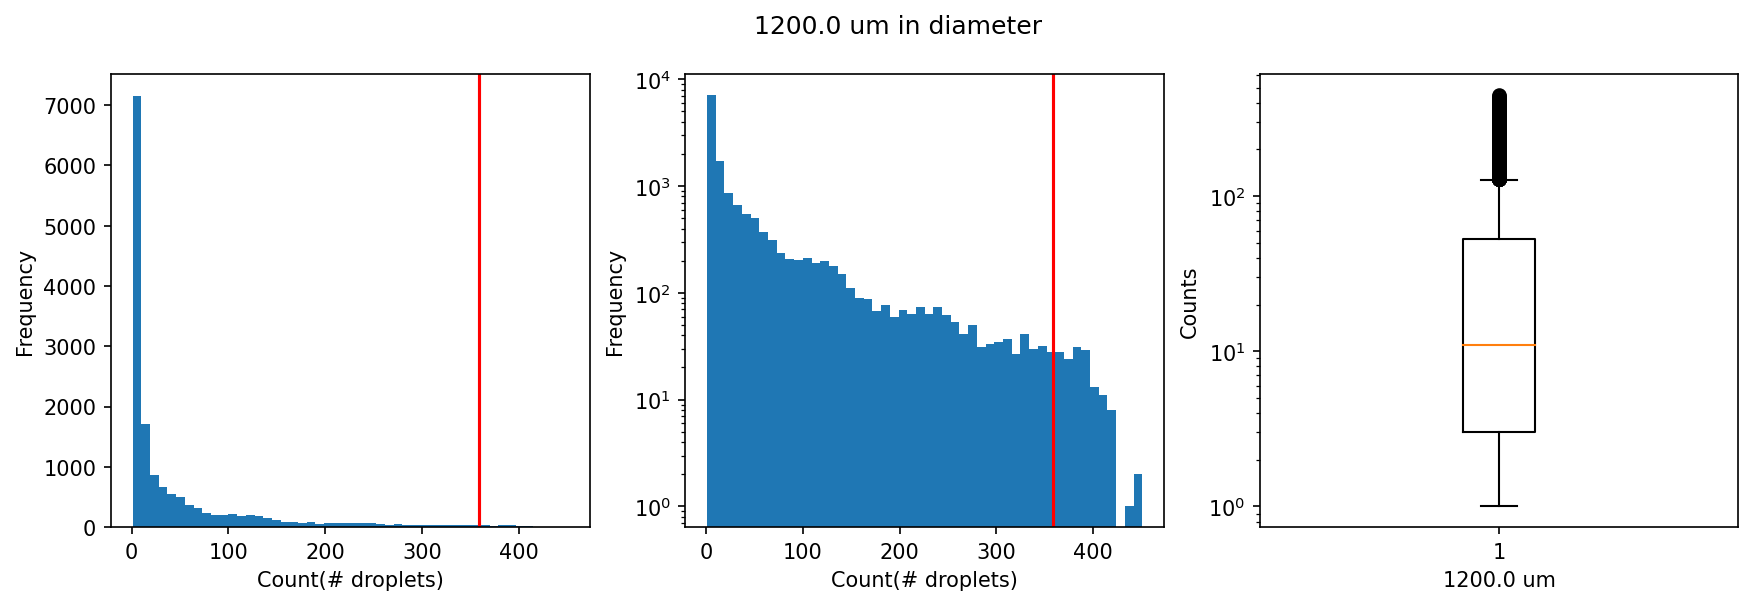

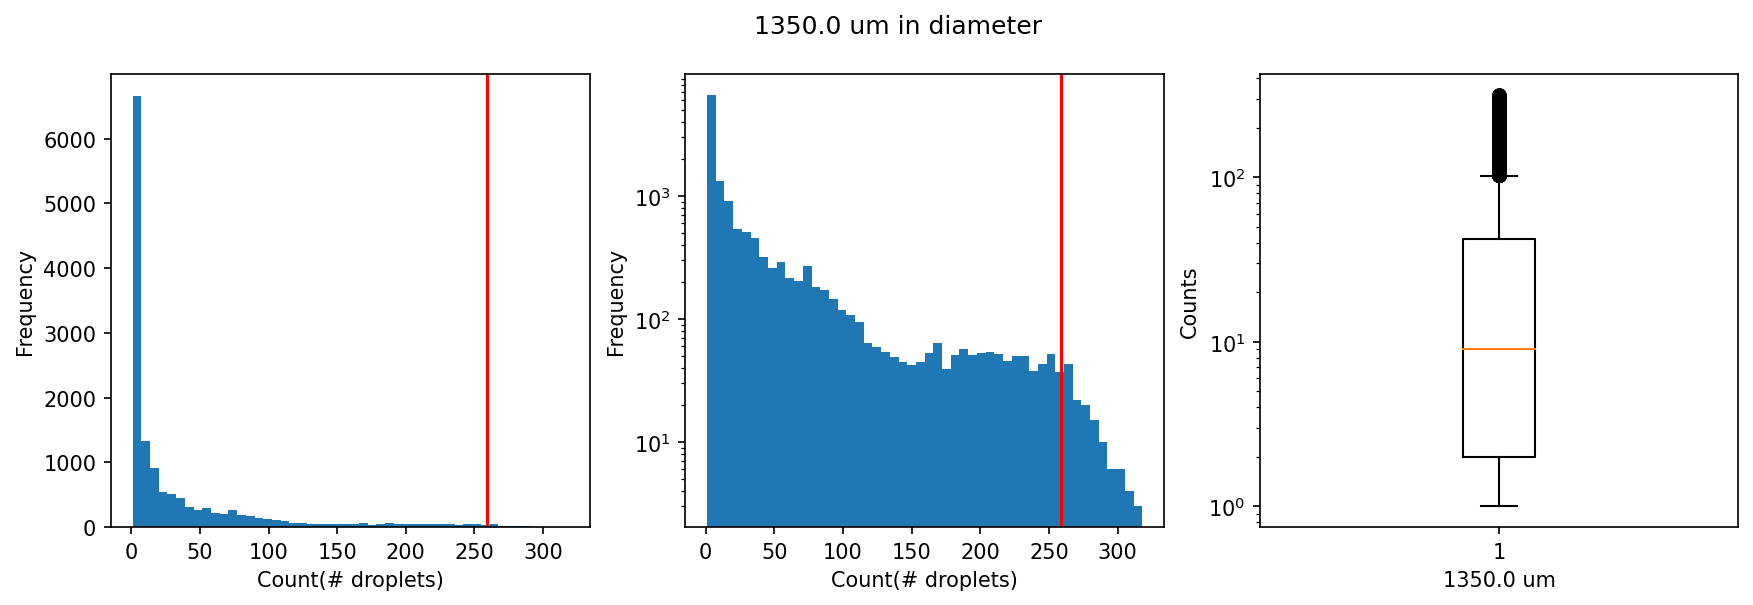

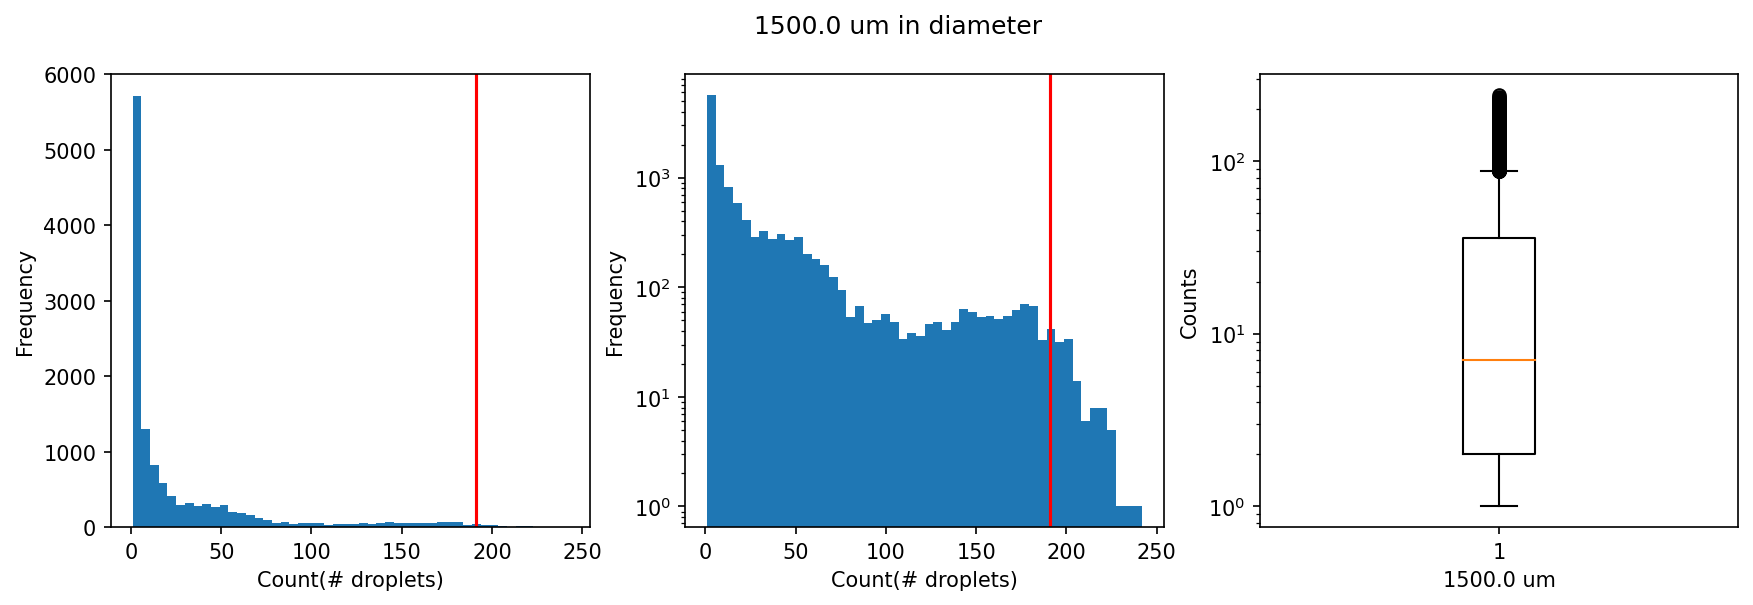

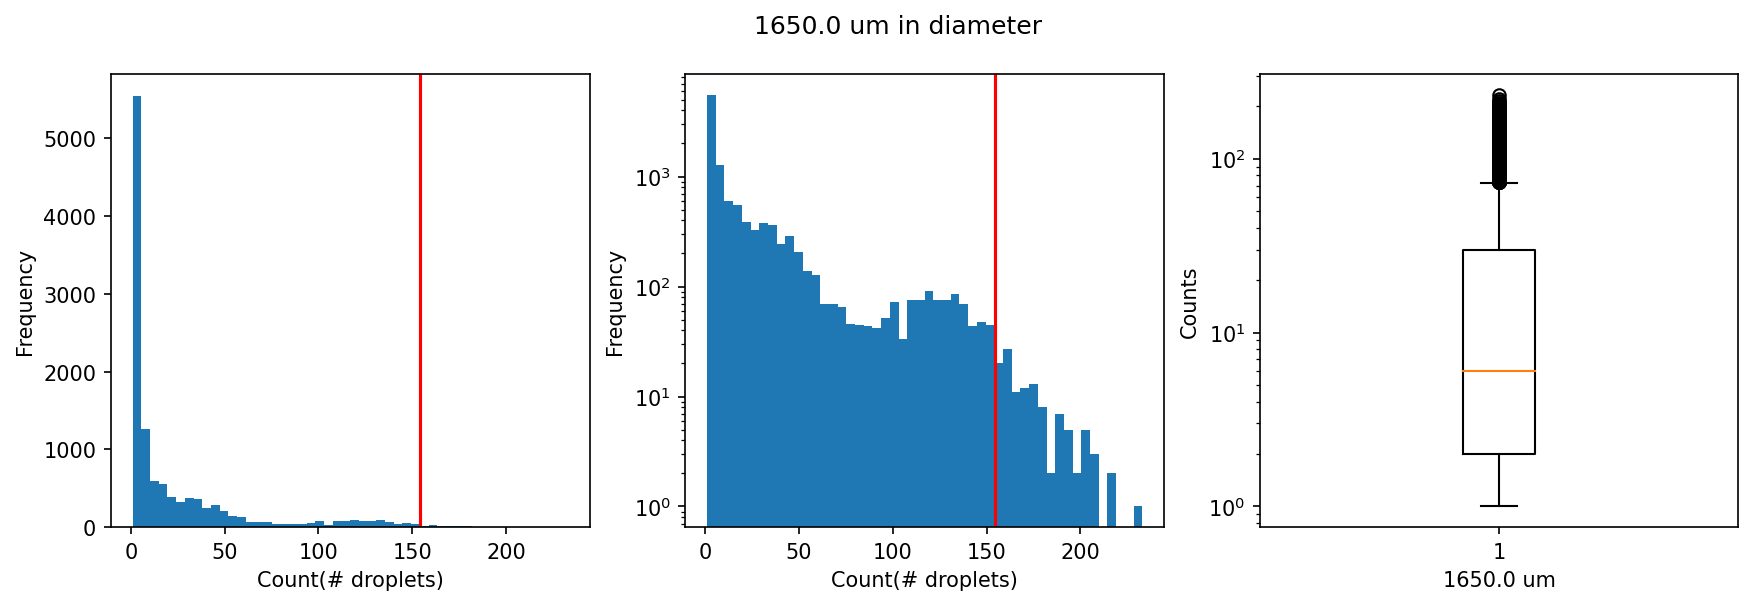

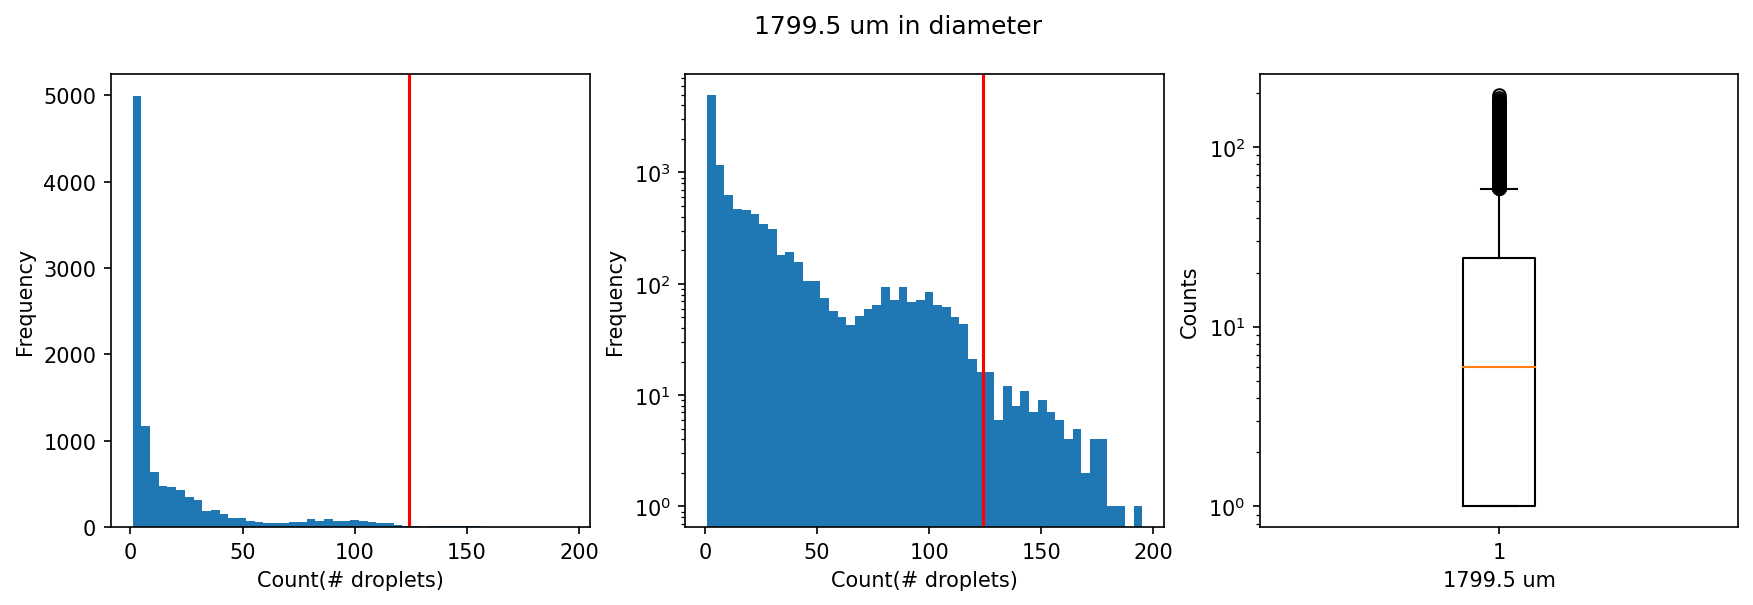

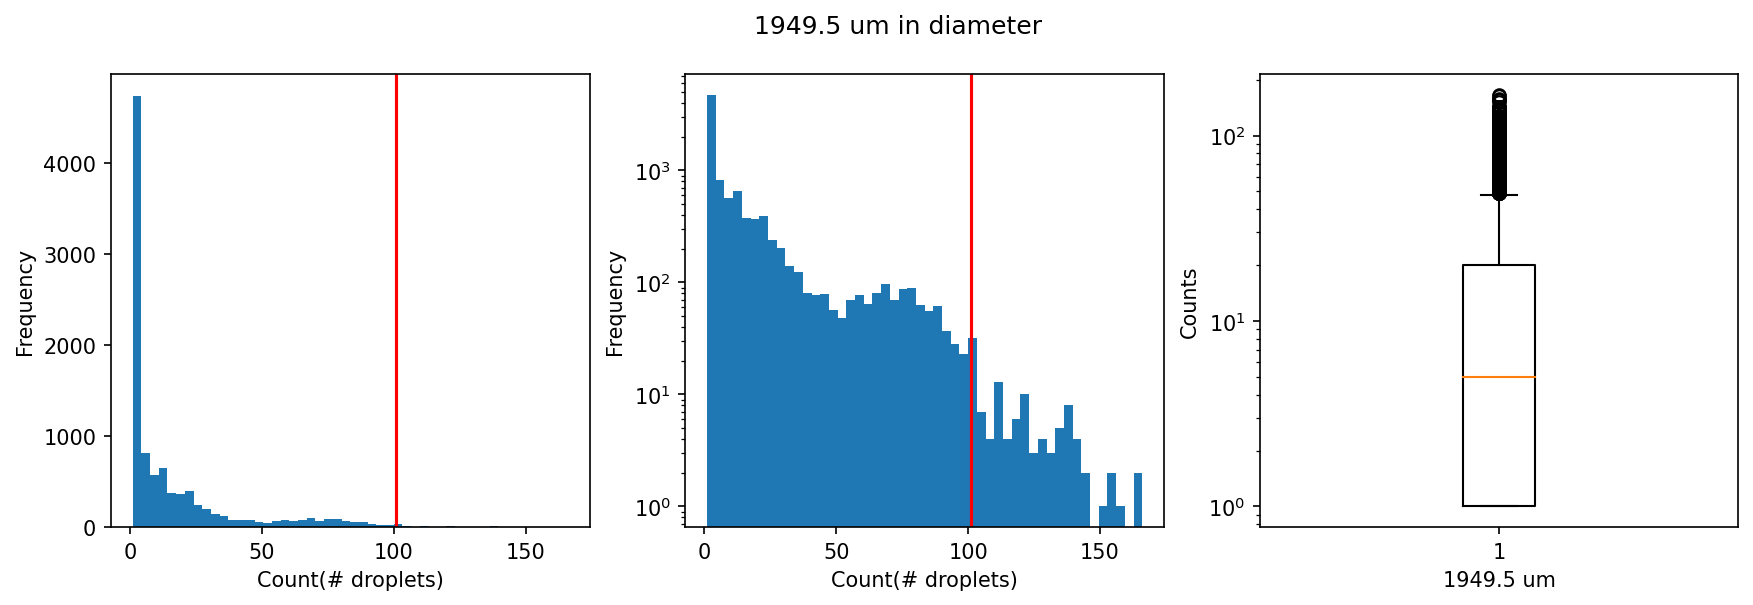

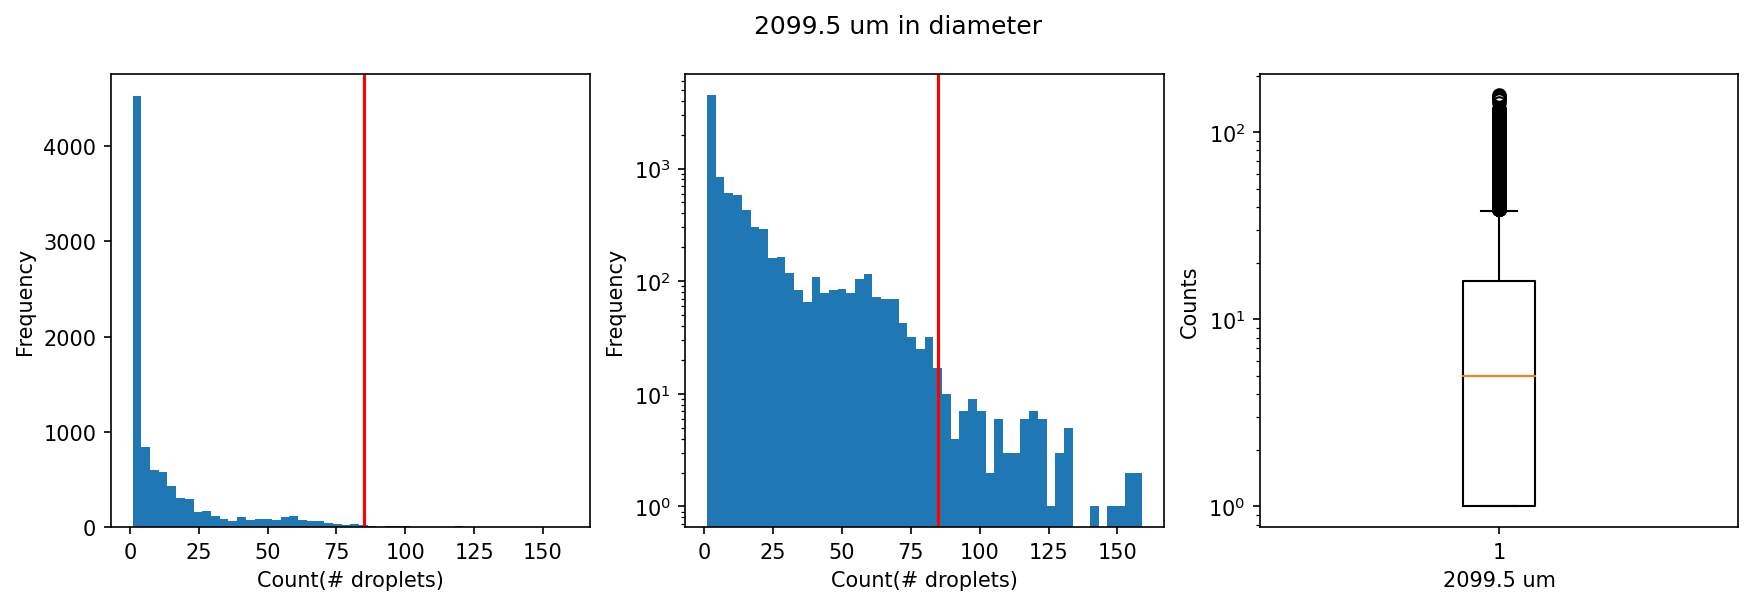

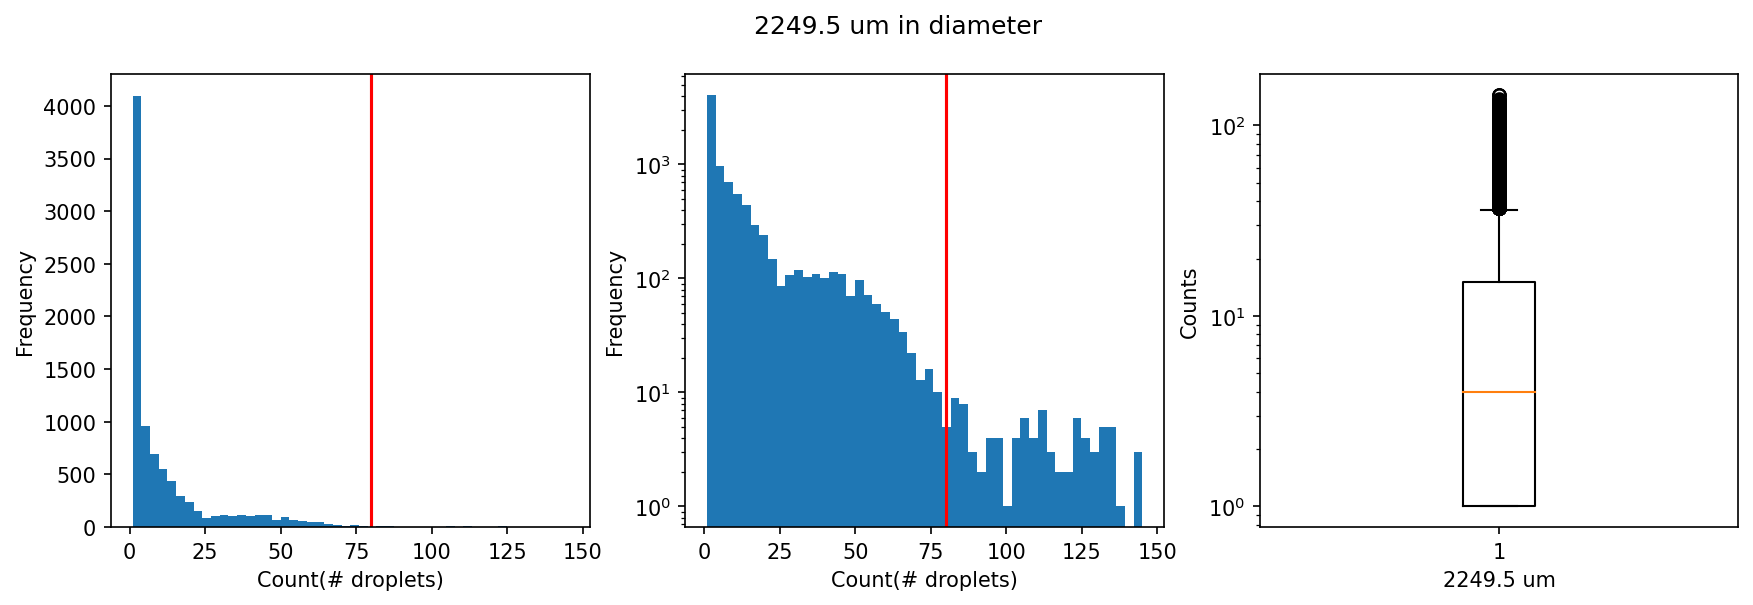

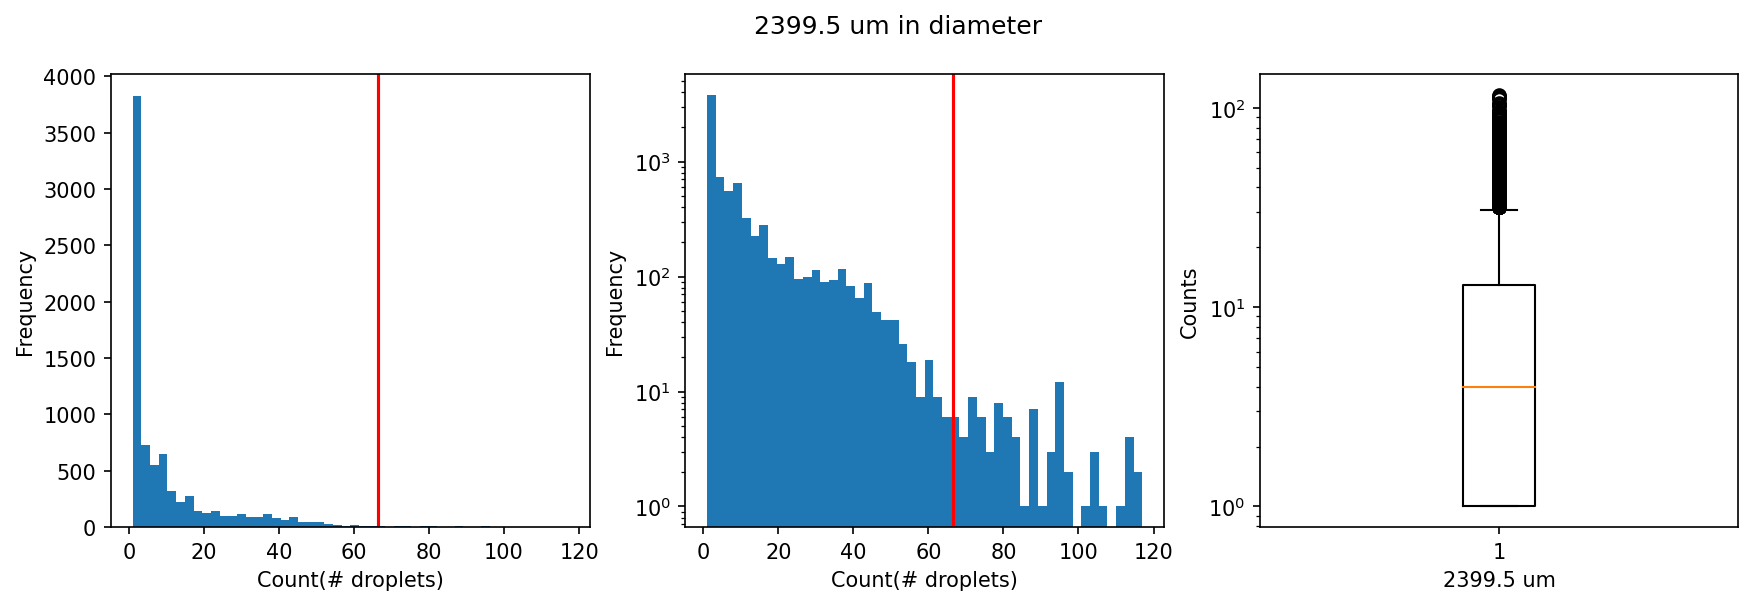

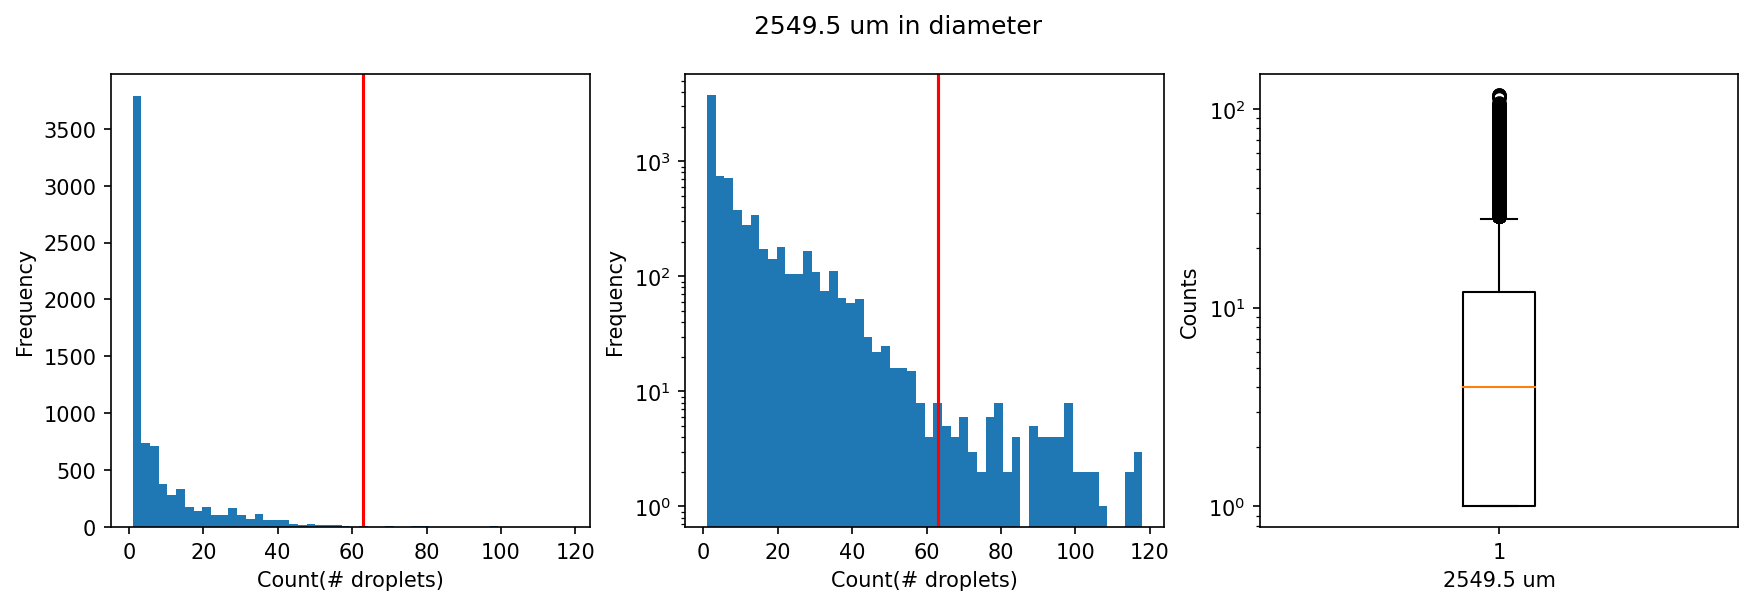

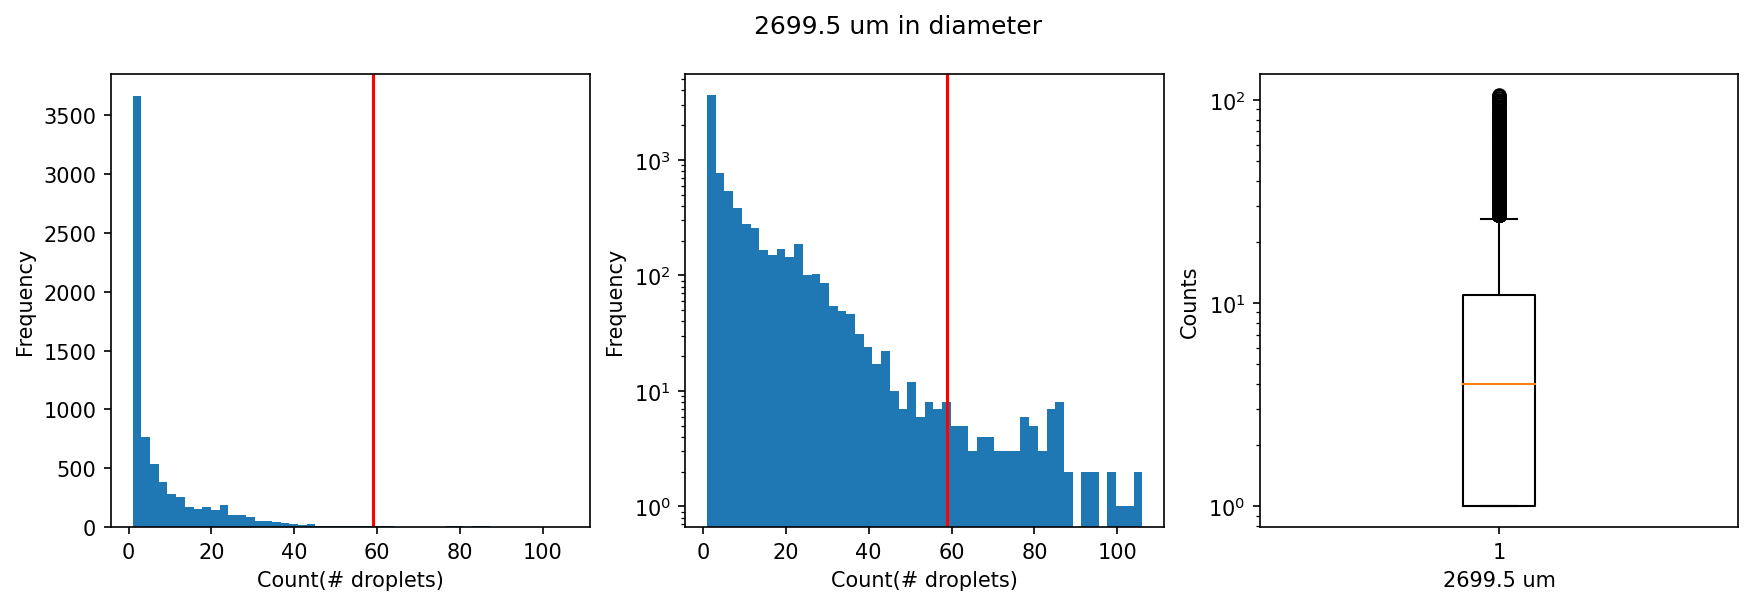

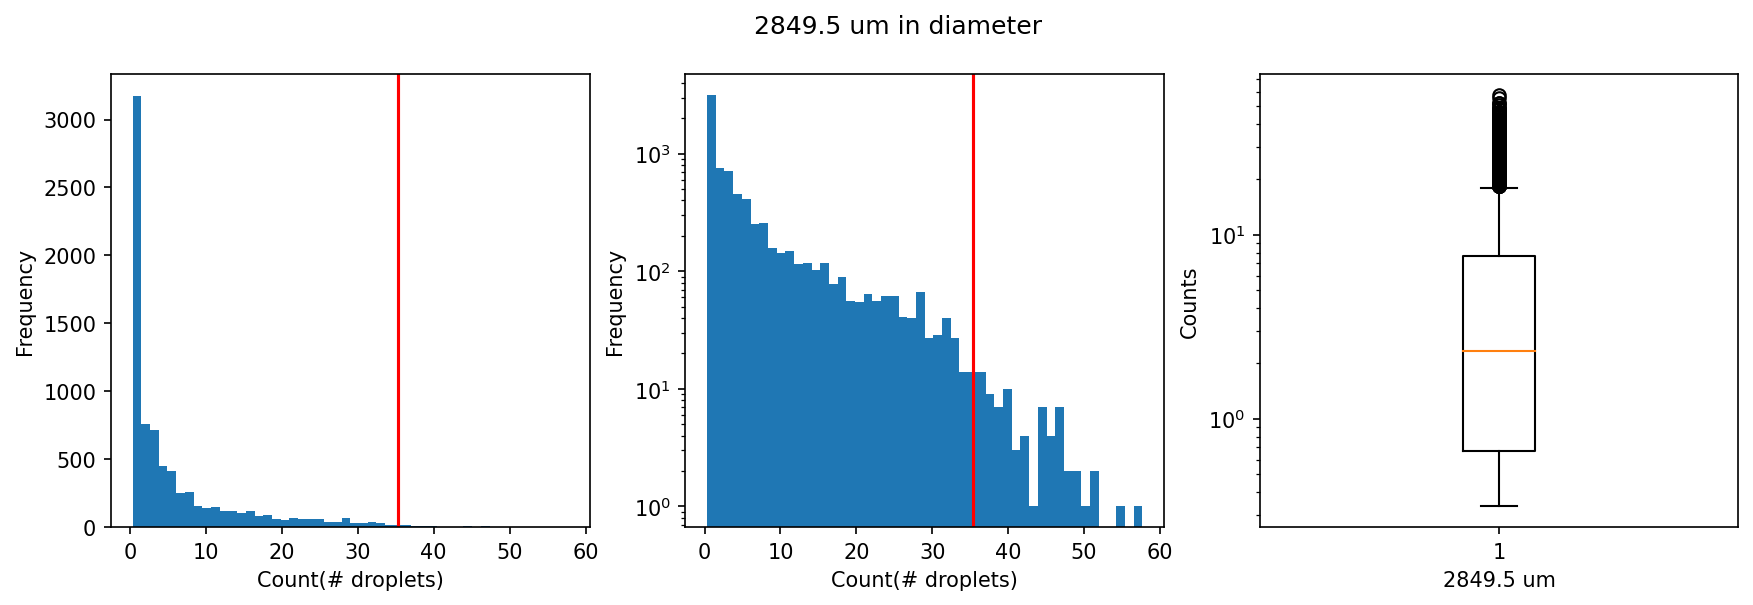

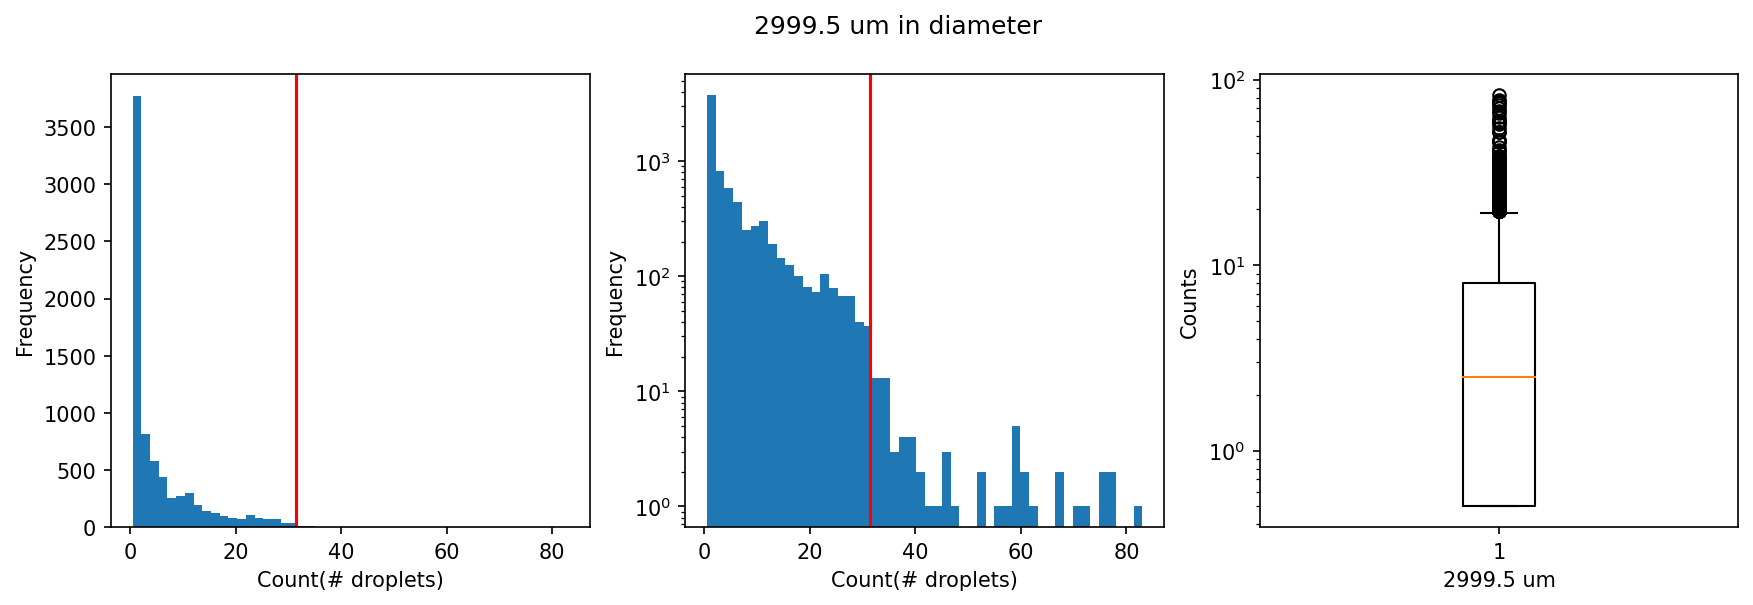

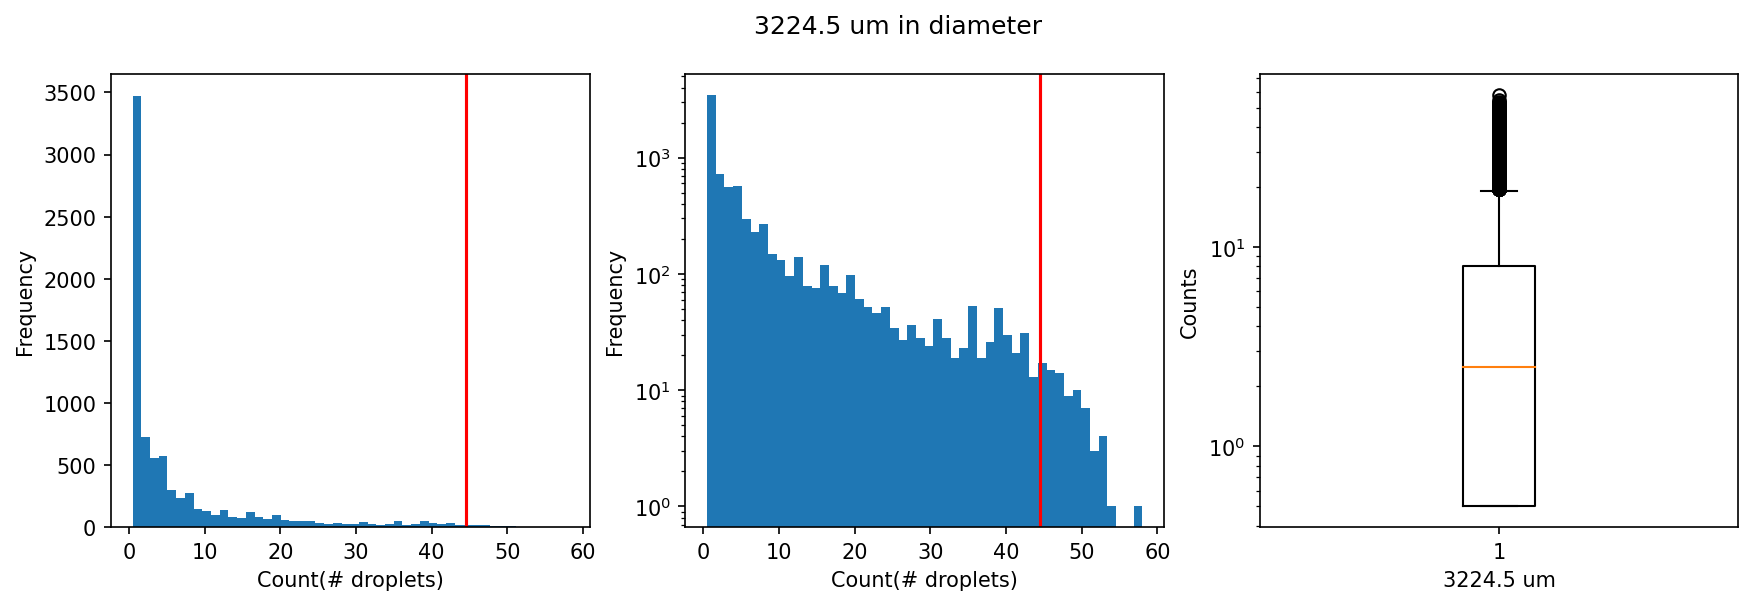

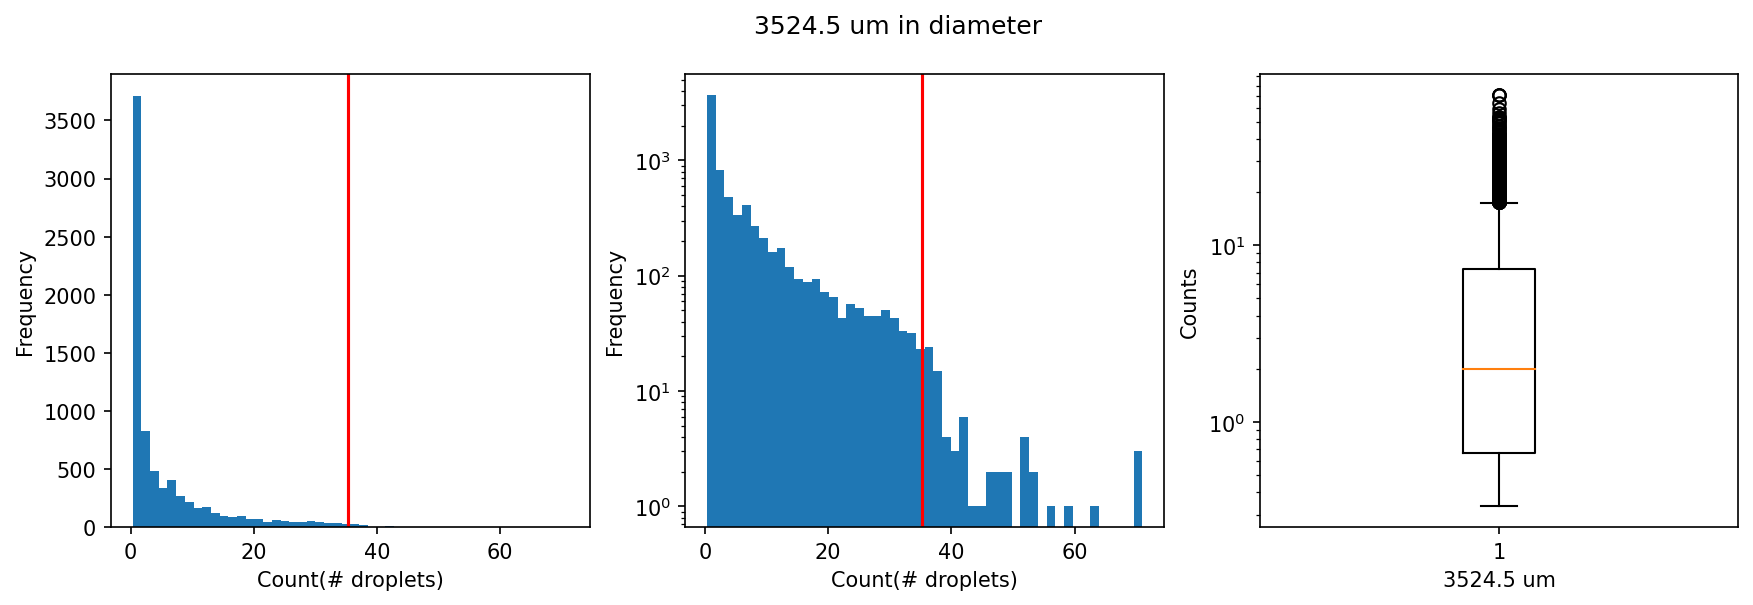

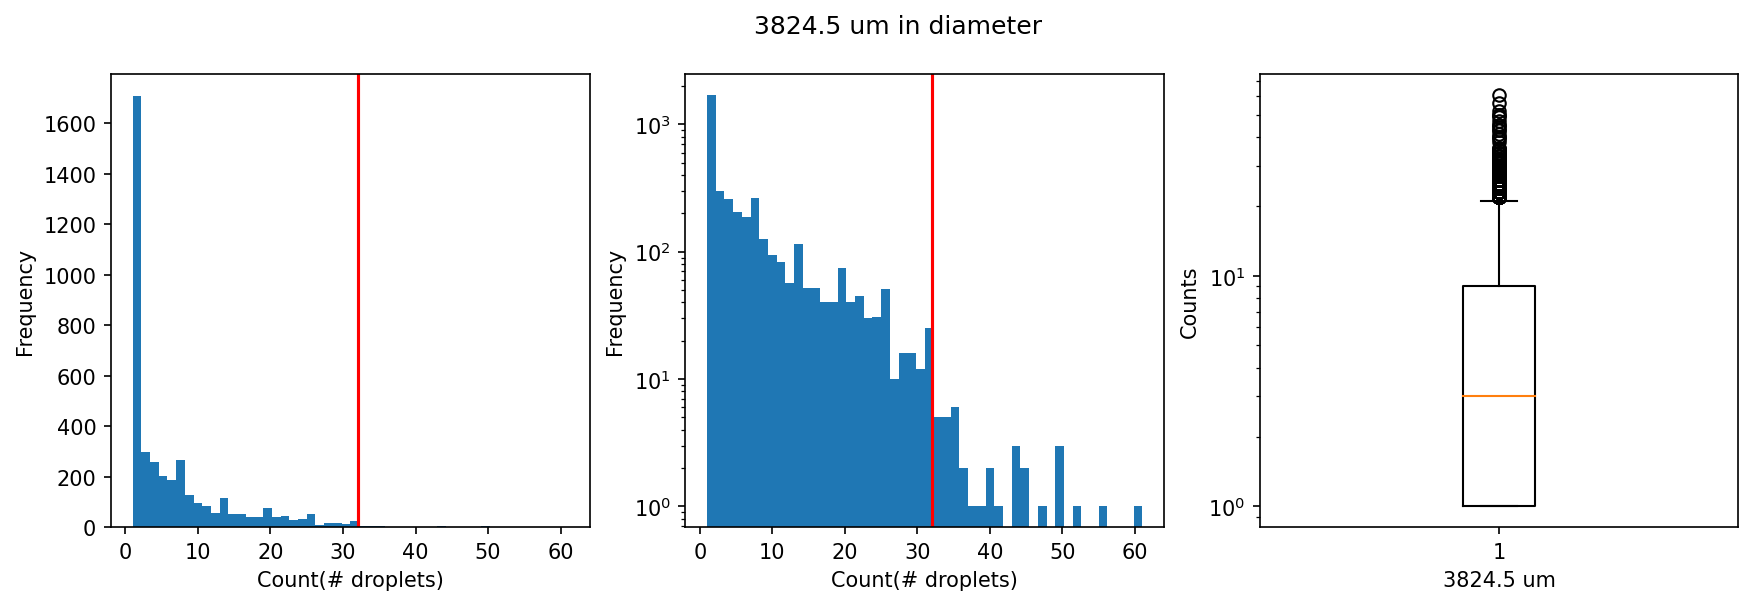

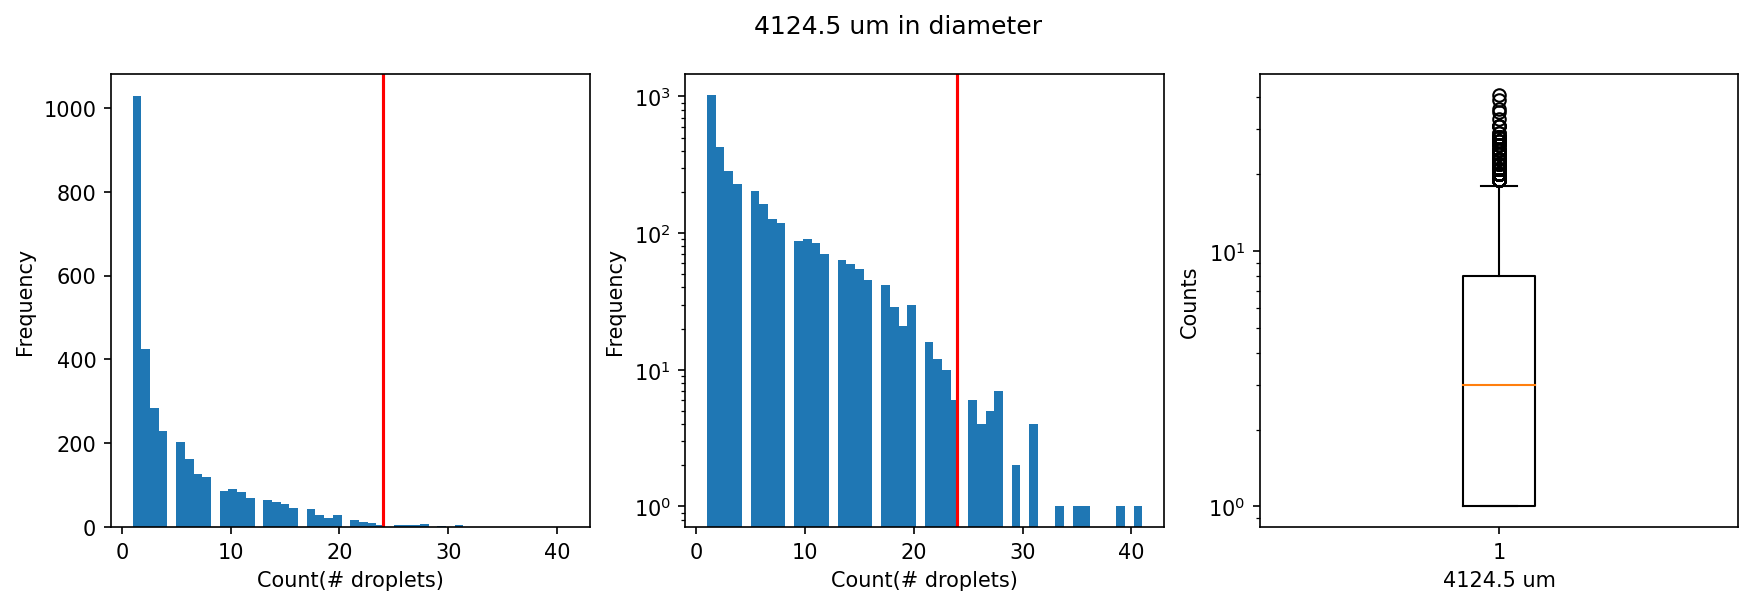

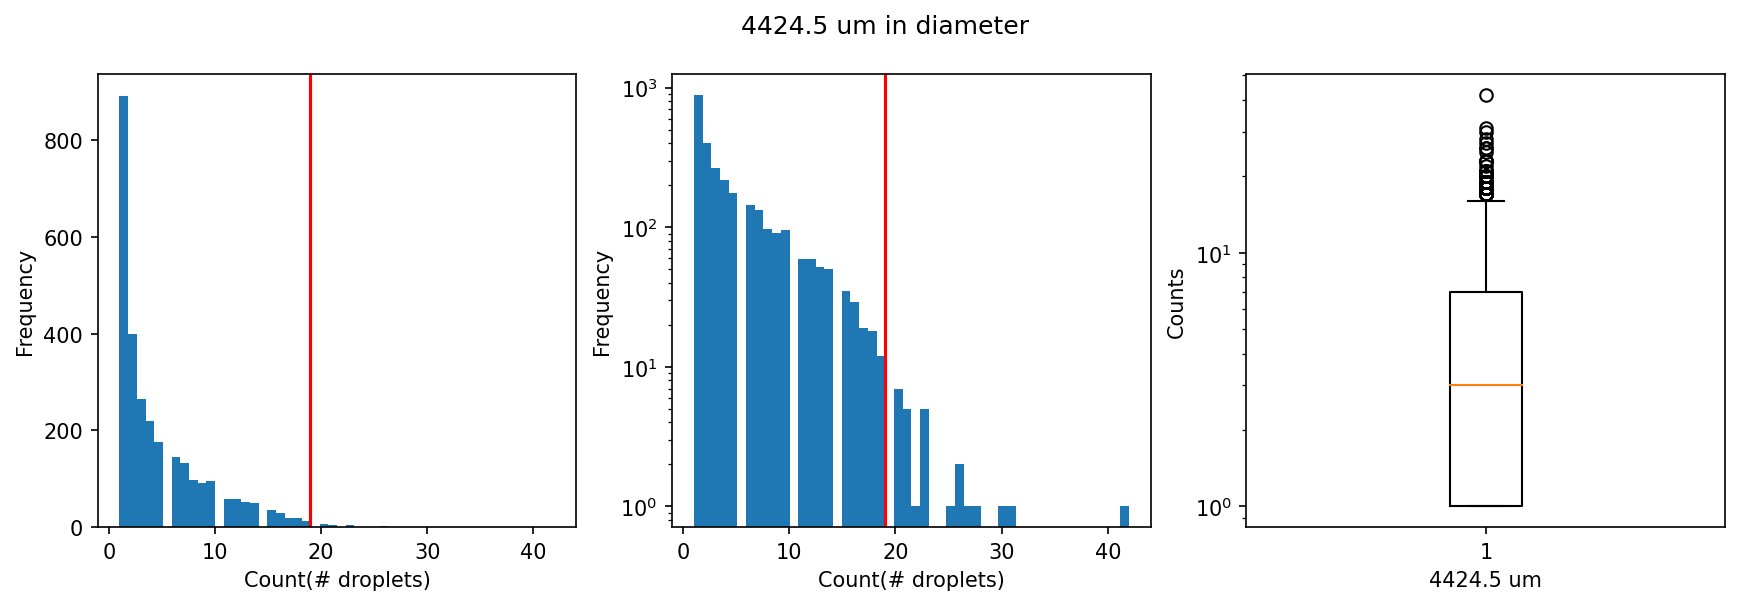

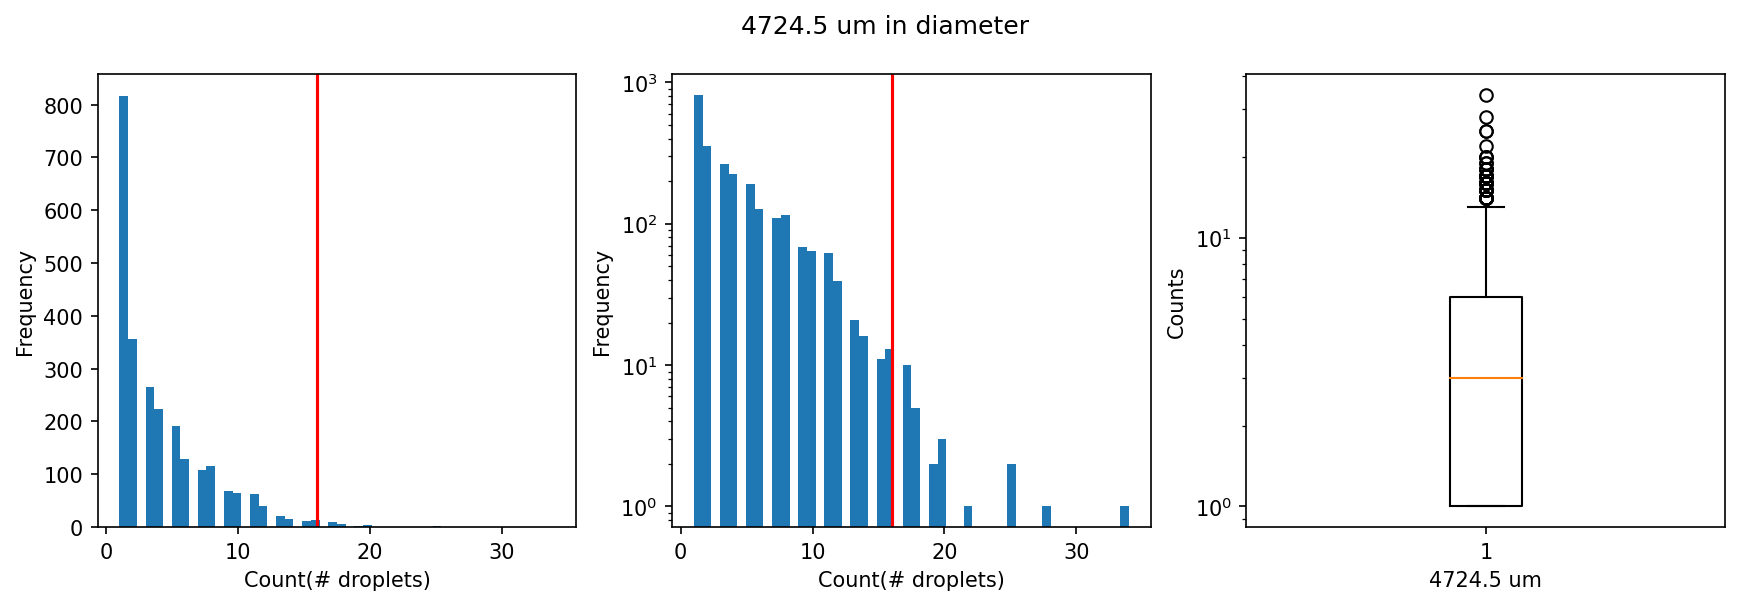

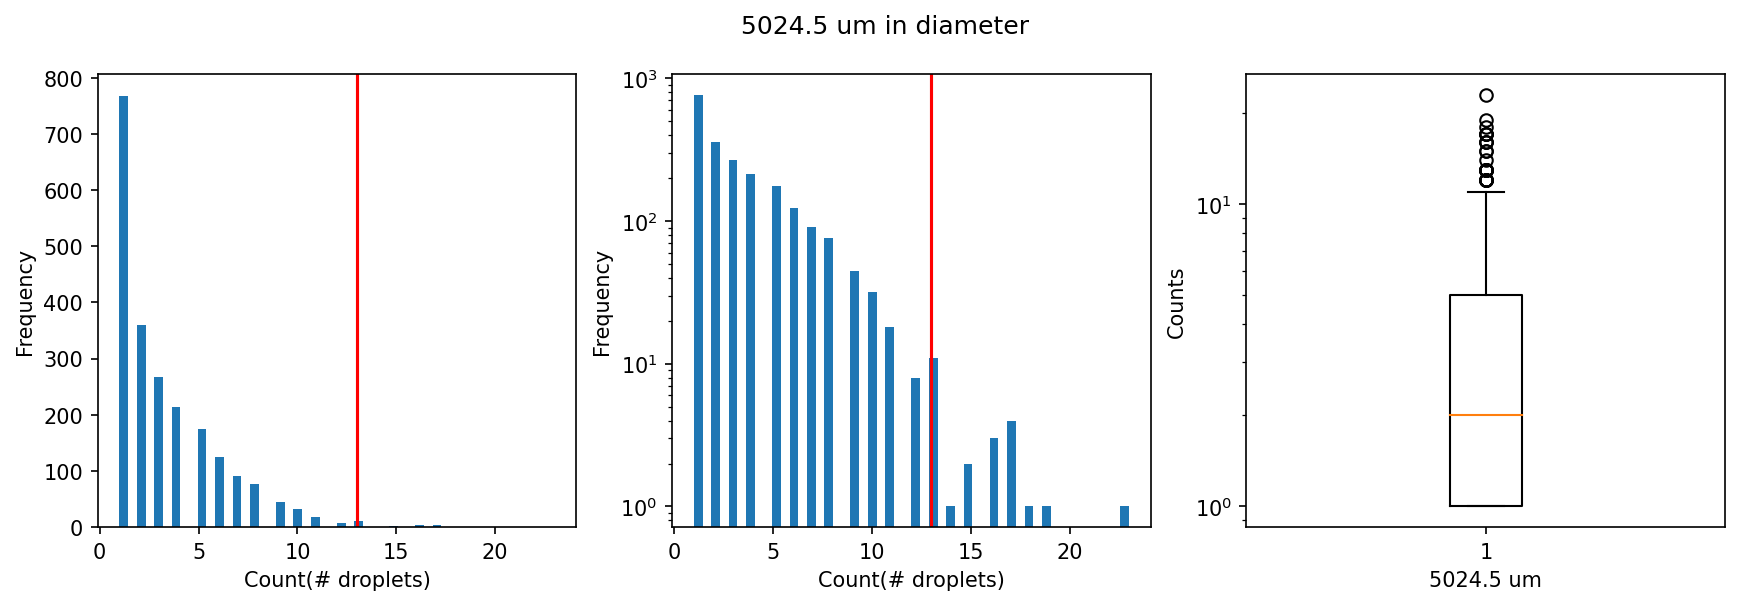

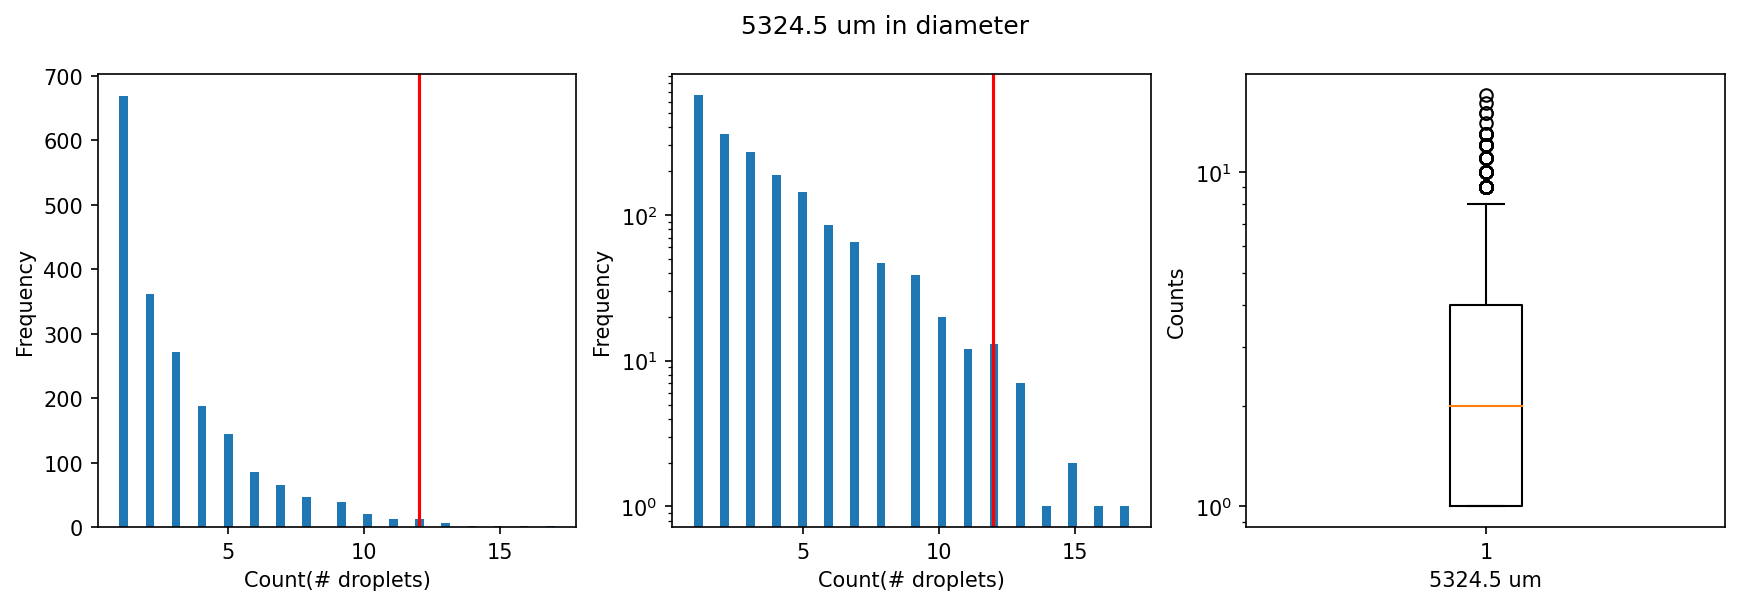

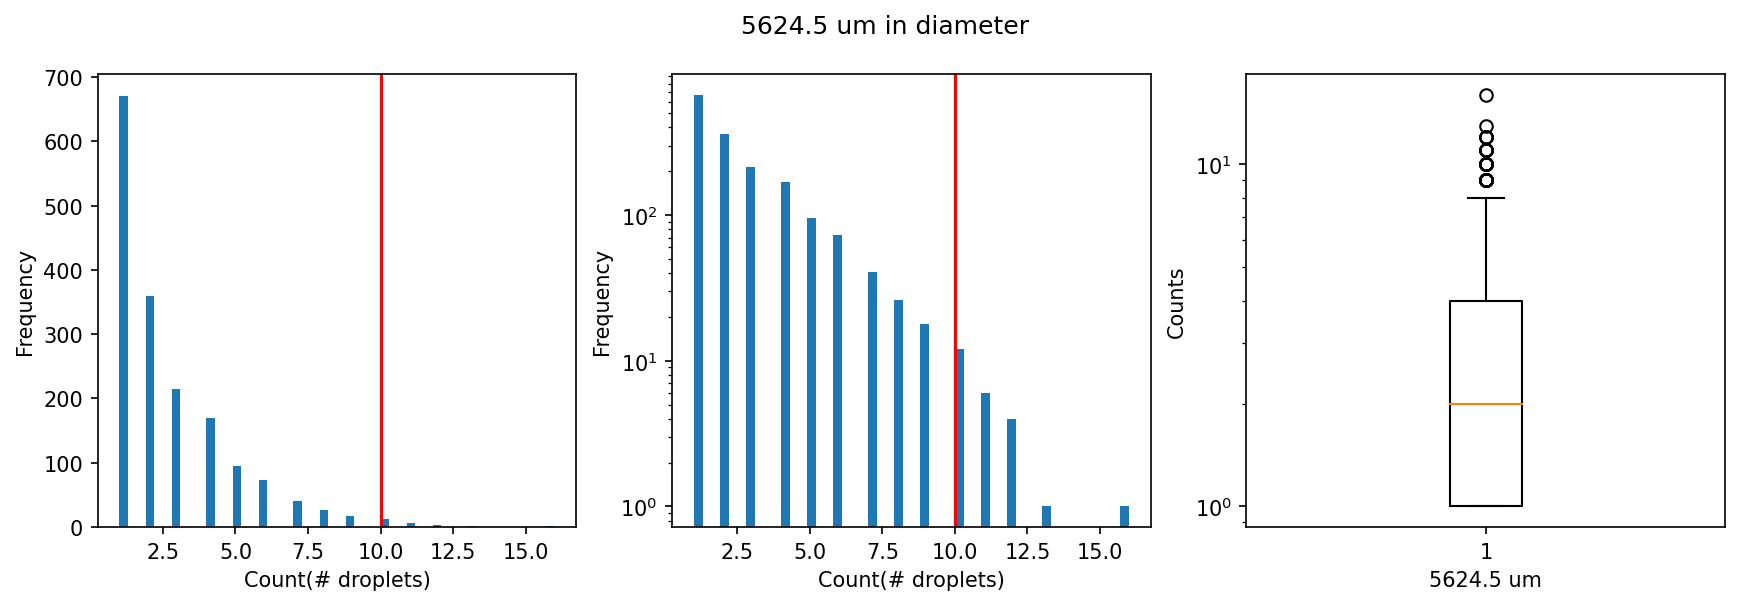

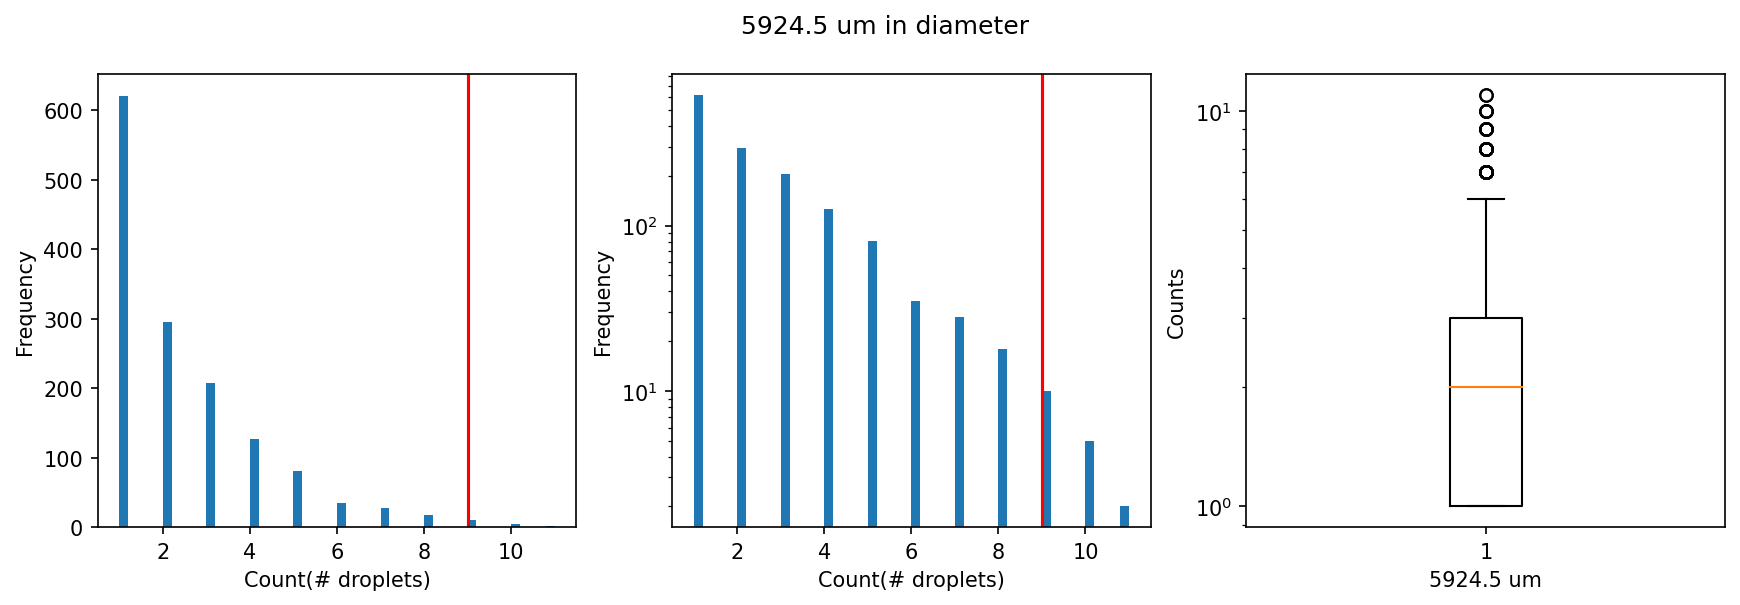

In [46]:
q = 0.99
for i in xr_hvps.diameter.sel(diameter=slice(150, 6000)):
    data =  xr_hvps.cnt_bin.sel(diameter=i)
    data = data[(~data.isnull()) & (data > 0)]
    qtl = data.compute().quantile([q], dim=['time'])
    fig, (ax, ax1, ax2) = plt.subplots(1,3, figsize=(14, 4), dpi=150)
    _ = ax.hist(data, bins=50)#, density=True)
    _ = ax1.hist(data, bins=50)#, density=True)
    _ = ax2.boxplot(data)
    
    ax.axvline(qtl.sel(quantile=q), 0, c='red')
    ax1.axvline(qtl.sel(quantile=q), 0, c='red')
    ax.set_ylabel('Frequency')
    ax1.set_ylabel('Frequency')
    ax.set_xlabel('Count(# droplets)')
    ax1.set_xlabel('Count(# droplets)')
    ax1.set_yscale('log')
    ax2.set_ylabel('Counts')
    ax2.set_yscale('log')
    ax2.set_xlabel(f'{i.values} um')
    fig.suptitle(f'{i.values} um in diameter')
    plt.show()

In [ ]:
for i in xr_2ds.diameter.sel(diameter=slice(10, 1200)):
    data =  xr_2ds.psd.sel(diameter=i)
    data = data[(~np.isnan(data) & (data > 0))]
    data_log = np.log10(data)
    fig, (ax, ax1, ax2) = plt.subplots(1,3, figsize=(14, 4))
    _ = ax.hist(data_log, bins=100)#, density=True)
    _ = ax1.hist(data_log, bins=100)#, density=True)
    _ = ax2.boxplot(data_log)
    ax1.set_yscale('log')
    fig.suptitle(f'{i.values} um in diameter')

In [ ]:
for i in xr_2ds.diameter.sel(diameter=slice(10, 1200)):
    data = data.where(~data.isnull())
    data = data.where(data > 0)
    data_log  = np.log10(data)
    qtls = data_log.compute().quantile([0., 0.95], dim='time')
    data_log = data_log.where(data_log > qtls.values[0])
    data_log = data_log.where(data_log < qtls.values[1])
    fig, (ax, ax1, ax2) = plt.subplots(1,3, figsize=(14, 4))
    _ = ax.hist(data_log, bins=100)#, density=True)
    _ = ax1.hist(data_log, bins=100)#, density=True)
    _ = ax2.boxplot(data_log[~np.isnan(data_log)])
    ax1.set_yscale('log')
    fig.suptitle(f'{i.values} um in diameter')

In [ ]:
psd = xr_2ds.psd
psd = psd.where(~psd.isnull())
psd = psd.where(psd > 0)
qtls = psd.compute().quantile([0.025, 0.975], dim='time')

In [ ]:
xr_2ds_filt = xr_2ds.where(psd > qtls.values[0])
xr_2ds_filt = xr_2ds.where(psd < qtls.values[1])

In [ ]:
event = xr_2ds_filt.sel(time=slice('2019-09-07 07:31:30', '2019-09-07 07:34:30'))
parms_res = pds_parameters(event)

In [ ]:
fig, ax = plt.subplots( figsize=(12,4), dpi=300, sharex=True)
cbar1 = ax.pcolormesh(parms_res.time, 
                       parms_res.diameter / 1e3, 
                       parms_res.lwc.T.values, 
                       vmin=0, vmax=1, cmap=my_cmap, shading='nearest')
ax11 = ax.twinx()
ax11.plot(parms_res.time, parms_res.lwc.sum('diameter'), c='k', ls='--', lw=0.5)

add_colorbar_outside(cbar1, ax, 'LWC (gr m-3)')
ax.set_yscale('log')
ax.set_ylim(0.01, 10)

In [ ]:
for _idx, data in xr_2ds_filt.groupby('time.day'):

    fig, ax1 = plt.subplots(figsize=(12, 3))
    cbar = ax1.pcolormesh(data.time.values, data.diameter / 1e3, 
                   np.log10(data.psd.T.values * 1e6), 
                      vmin=0, vmax=10, cmap=my_cmap)
    ax1.set_yscale('log')
    params = pds_parameters(data)
    lwc = params.lwc.where(params.lwc >0.1, 0)
    ax11 = ax1.twinx()
    ax11.plot(lwc.time, lwc.sum('diameter'))
    add_colorbar_outside(cbar, ax1, 'Log10 (N(D))')
    ax1.set_xlabel('Time (UTC)')
    ax1.set_ylabel('Diameter (mm)')
    ax11.set_ylabel('LWC (g m-3)')
    title = f"{pd.to_datetime(data.time.values[0]): %Y-%m-%d} UTC - {data.attrs['aircraft']}"
    fig.suptitle(title, fontsize=14, fontweight='bold', y=0.99)

### By events

In [ ]:
event = xr_2ds_filt.sel(time=slice('2019-09-07 07:31:30', '2019-09-07 07:45:30'))
parms_res = pds_parameters(event)

In [ ]:
fig, (ax, ax1) = plt.subplots(2, 1, figsize=(12,6), dpi=300, sharex=True)

cbar = ax.pcolormesh(event.time, 
                       event.diameter / 1e3, 
                       np.log10(event.psd.T.values * 1e6), 
                       vmin=0, vmax=10, cmap=my_cmap, shading='nearest')

cbar1 = ax1.pcolormesh(parms_res.time, 
                       parms_res.diameter / 1e3, 
                       parms_res.lwc.T.values, 
                       vmin=0, vmax=1, cmap=my_cmap, shading='nearest')
ax11 = ax1.twinx()
ax11.plot(parms_res.time, parms_res.lwc.sum('diameter'), c='k', ls='--', lw=0.8)

add_colorbar_outside(cbar1, ax1, 'LWC (gr m-3)')
add_colorbar_outside(cbar, ax, 'Log10(N(D))')
ax.set_yscale('log')
ax1.set_yscale('log')
ax1.set_ylim(0.01, 10)
ax.set_ylim(0.01, 10)

In [ ]:
for i in xr_2ds_filt.sel(time=slice('2019-09-07 07:33:55', '2019-09-07 07:34:05')).time:
    fig, (ax, ax1) = plt.subplots(1,2, figsize=(12, 5))
    
    y = xr_fssp.psd.sel(time=i) * 1e6
    y = y.where(y > 0, np.nan)
    
    ax.step(x=xr_fssp.diameter * 1e-3, y=y, where='mid', c='r', lw=1, label= 'FFSP')
    ax1.step(x=xr_fssp.diameter * 1e-3, y=y, where='mid', c='r', lw=1, label= 'FFSP')
    
    y = xr_fcdp.psd.sel(time=i) * 1e6
    y = y.where(y > 0, np.nan)

    ax.step(x=xr_fcdp.diameter * 1e-3, y=y, where='mid', c='brown', lw=1, label= 'FCDP')
    ax1.step(x=xr_fcdp.diameter * 1e-3, y=y, where='mid', c='brown', lw=1, label= 'FCDP')
    
    y = xr_2ds.psd.sel(time=i) * 1e6 
    y = y.where(y > 0, np.nan)
    y_filt = xr_2ds_filt.psd.sel(time=i) * 1e6
    y_filt = y_filt.where(y > 0, np.nan)
    ax.step(x=xr_2ds.diameter * 1e-3, y=y, where='mid', label='2DS', c='k')
    ax1.step(x=xr_2ds_filt.diameter * 1e-3, y=y_filt, where='mid', label='2DS', c='k')

    y = xr_hvps.psd.sel(time=i) * 1e6
    y = y.where(y > 0, np.nan)
    
    ax.step(x=xr_hvps.diameter* 1e-3, y=y, where='mid', label='HVPS', c='b')
    ax1.step(x=xr_hvps.diameter* 1e-3, y=y, where='mid', label='HVPS', c='b')
    
    ax1.vlines(x=xr_fssp.diameter.min() * 1e-3, ymin=1e0, ymax=1e12, colors='C0', linestyles='dashed')
    ax1.vlines(x=xr_fssp.diameter.max() * 1e-3, ymin=1e0, ymax=1e12, colors='C0', linestyles='dashed')
    
    ax1.vlines(x=xr_2ds.diameter.min() * 1e-3, ymin=1e0, ymax=1e12, colors='C1', linestyles='dashed')
    ax1.vlines(x=xr_2ds.diameter.max() * 1e-3, ymin=1e0, ymax=1e12, colors='C1', linestyles='dashed')
    
    ax1.vlines(x=xr_hvps.diameter.min() * 1e-3, ymin=1e0, ymax=1e12, colors='C2', linestyles='dashed')
    ax1.vlines(x=xr_hvps.diameter.max() * 1e-3, ymin=1e0, ymax=1e12, colors='C2', linestyles='dashed')
    
    ax.vlines(x=xr_fssp.diameter.min() * 1e-3, ymin=1e0, ymax=1e12, colors='C0', linestyles='dashed')
    ax.vlines(x=xr_fssp.diameter.max() * 1e-3, ymin=1e0, ymax=1e12, colors='C0', linestyles='dashed')
    
    ax.vlines(x=xr_2ds.diameter.min() * 1e-3, ymin=1e0, ymax=1e12, colors='C1', linestyles='dashed')
    ax.vlines(x=xr_2ds.diameter.max() * 1e-3, ymin=1e0, ymax=1e12, colors='C1', linestyles='dashed')
    
    ax.vlines(x=xr_hvps.diameter.min() * 1e-3, ymin=1e0, ymax=1e12, colors='C2', linestyles='dashed')
    ax.vlines(x=xr_hvps.diameter.max() * 1e-3, ymin=1e0, ymax=1e12, colors='C2', linestyles='dashed')
    
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.legend()

    ax1.set_yscale('log')
    ax1.set_xscale('log')
    ax1.legend()
    ax1.grid(which='both')
    ax1.grid(which='both')
    ax1.set_xlabel('Particle size (mm)')
    ax.grid(which='both')
    ax.grid(which='both')
    ax.set_xlabel('Particle size (mm)')
    title = f"{pd.to_datetime(i.values): %Y-%m-%d %X} UTC - {aircraft}"
    fig.suptitle(title, fontsize=14, fontweight='bold', y=0.99)
#     ax1.set_ylabel('Concentration (# m-3 m-1)')
    ax1.grid(which='both')
    ax.grid(which='both')
    plt.show()

In [ ]:
for i in xr_2ds_filt.sel(time=slice('2019-09-07 07:42:19', '2019-09-07 07:42:20')).time:
    fig, (ax, ax1) = plt.subplots(1,2, figsize=(12, 5))
    
    y = xr_fssp.psd.sel(time=i) * 1e6
    y = y.where(y > 0, np.nan)
    
    ax.step(x=xr_fssp.diameter * 1e-3, y=y, where='mid', c='r', lw=1, label= 'FFSP')
    ax1.step(x=xr_fssp.diameter * 1e-3, y=y, where='mid', c='r', lw=1, label= 'FFSP')
    
    y = xr_fcdp.psd.sel(time=i) * 1e6
    y = y.where(y > 0, np.nan)

    ax.step(x=xr_fcdp.diameter * 1e-3, y=y, where='mid', c='brown', lw=1, label= 'FCDP')
    ax1.step(x=xr_fcdp.diameter * 1e-3, y=y, where='mid', c='brown', lw=1, label= 'FCDP')
    
    y = xr_2ds.psd.sel(time=i) * 1e6 
    y = y.where(y > 0, np.nan)
    y_filt = xr_2ds_filt.psd.sel(time=i) * 1e6
    y_filt = y_filt.where(y > 0, np.nan)
    ax.step(x=xr_2ds.diameter * 1e-3, y=y, where='mid', label='2DS', c='k')
    ax1.step(x=xr_2ds_filt.diameter * 1e-3, y=y_filt, where='mid', label='2DS', c='k')

    y = xr_hvps.psd.sel(time=i) * 1e6
    y = y.where(y > 0, np.nan)
    
    ax.step(x=xr_hvps.diameter* 1e-3, y=y, where='mid', label='HVPS', c='b')
    ax1.step(x=xr_hvps.diameter* 1e-3, y=y, where='mid', label='HVPS', c='b')
    
    ax1.vlines(x=xr_fssp.diameter.min() * 1e-3, ymin=1e0, ymax=1e12, colors='C0', linestyles='dashed')
    ax1.vlines(x=xr_fssp.diameter.max() * 1e-3, ymin=1e0, ymax=1e12, colors='C0', linestyles='dashed')
    
    ax1.vlines(x=xr_2ds.diameter.min() * 1e-3, ymin=1e0, ymax=1e12, colors='C1', linestyles='dashed')
    ax1.vlines(x=xr_2ds.diameter.max() * 1e-3, ymin=1e0, ymax=1e12, colors='C1', linestyles='dashed')
    
    ax1.vlines(x=xr_hvps.diameter.min() * 1e-3, ymin=1e0, ymax=1e12, colors='C2', linestyles='dashed')
    ax1.vlines(x=xr_hvps.diameter.max() * 1e-3, ymin=1e0, ymax=1e12, colors='C2', linestyles='dashed')
    
    ax.vlines(x=xr_fssp.diameter.min() * 1e-3, ymin=1e0, ymax=1e12, colors='C0', linestyles='dashed')
    ax.vlines(x=xr_fssp.diameter.max() * 1e-3, ymin=1e0, ymax=1e12, colors='C0', linestyles='dashed')
    
    ax.vlines(x=xr_2ds.diameter.min() * 1e-3, ymin=1e0, ymax=1e12, colors='C1', linestyles='dashed')
    ax.vlines(x=xr_2ds.diameter.max() * 1e-3, ymin=1e0, ymax=1e12, colors='C1', linestyles='dashed')
    
    ax.vlines(x=xr_hvps.diameter.min() * 1e-3, ymin=1e0, ymax=1e12, colors='C2', linestyles='dashed')
    ax.vlines(x=xr_hvps.diameter.max() * 1e-3, ymin=1e0, ymax=1e12, colors='C2', linestyles='dashed')
    
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.legend()

    ax1.set_yscale('log')
    ax1.set_xscale('log')
    ax1.legend()
    ax1.grid(which='both')
    ax1.grid(which='both')
    ax1.set_xlabel('Particle size (mm)')
    ax.grid(which='both')
    ax.grid(which='both')
    ax.set_xlabel('Particle size (mm)')
    title = f"{pd.to_datetime(i.values): %Y-%m-%d %X} UTC - {aircraft}"
    fig.suptitle(title, fontsize=14, fontweight='bold', y=0.99)
#     ax1.set_ylabel('Concentration (# m-3 m-1)')
    ax1.grid(which='both')
    ax.grid(which='both')
    plt.show()

In [ ]:
event = xr_2ds.sel(time=slice('2019-09-07 07:33:50', '2019-09-07 07:34:05'))

In [ ]:
for i in event.diameter:
    fig, ax = plt.subplots()
    ax.hist(event.cnt_bin.sel(diameter=i))
    ax.set_yscale('log')
    fig.suptitle(f'{i.values} um in diameter')


In [ ]:
qtls = xr_2ds.cnt_bin.where(xr_2ds.cnt_bin > 0).compute().quantile([0.025, 0.975], dim='time')

In [ ]:
event.cnt_bin.where(event.cnt_bin > 0).sel(diameter=1155).compute().plot()

In [ ]:
xr_2ds.diameter.values

In [ ]:
fig, ax = plt.subplots()
xr_2ds.cnt_bin.where(xr_2ds.cnt_bin > 0).sel(time='2019-09-07 07:34:03').plot.step(ax=ax)
# ax.set_yscale('log')
ax.set_xscale('log')

In [ ]:
fig, ax = plt.subplots()
ax.step(xr_2ds.diameter, 
        xr_2ds.psd.where(xr_2ds.cnt_bin > 0).sel(time='2019-09-07 07:34:03'), 
        )
ax.step(xr_hvps.diameter, 
        xr_hvps.psd.where(xr_hvps.cnt_bin > 0).sel(time='2019-09-07 07:34:03'), 
        )
# ax.step(xr_comb_800.diameter, 
#         xr_comb_800.psd.where(xr_comb_800.psd > 0).sel(time='2019-09-07 07:34:03'), 
#         )
# ax.step(xr_hvps.psd.where(xr_2ds.cnt_bin > 0).sel(time='2019-09-07 07:34:03'))
ax.set_yscale('log')
ax.set_xscale('log')
ax.grid(which='both')

In [ ]:
xr_comb_800.sel(time='2019-09-07 07:30').time.values

In [ ]:
fig, ax = plt.subplots()
ax.step(xr_hvps.diameter, 
        xr_hvps.psd.where(xr_hvps.cnt_bin > 0).sel(time='2019-09-07 07:34:03'), 
        )
# ax.step(xr_hvps.psd.where(xr_2ds.cnt_bin > 0).sel(time='2019-09-07 07:34:03'))
ax.set_yscale('log')
ax.set_xscale('log')

In [ ]:
print(xr_2ds.psd.sel(time='2019-09-07 07:34:03').to_dataframe().tail(10))

In [ ]:
xr_2ds.cnt_bin.sel(time='2019-09-07 07:34:03').to_dataframe().tail(10)

In [ ]:
xr_2ds.cnt_bin.sel(time='2019-09-07 07:34:03').rolling(diameter=2, center=True).std()